## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.0])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

In [9]:
N_countsSimulator.N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [10]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [11]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00, 6.08545608e-01,
       3.49206956e-01, 6.02381608e-02, 5.27041633e-03, 2.70962833e-04])

## Set up simulator

In [12]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [13]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [14]:
#N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data =  N_countsSimulator.simulation(theta_fiducial, 1)
N_counts_data

array([20104, 61296, 78932, 70436, 50010,  2619,  6222,  5741,  3576,
        1761,   103,   162,    78,    43,     8])

In [15]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(N_counts_data)
print(n_data_points)

2
15


In [16]:
Finv = np.array([[ 7.49378517e-07, -9.02737058e-07], [-9.02737058e-07,  1.32527761e-06]])

## Define ensemble of NDEs

In [17]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2)]

## Create DELFI object

In [18]:
DelfiEnsemble0 = delfi.Delfi(N_counts_data, prior, NDEs, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_seed1_15000sims_3NDEs_2/")

## Sequential Neural Likelihood

In [19]:
n_initial = 100 
n_batch = 100 
n_populations = 150

Population 1/150
Sampling proposal density...
Done.


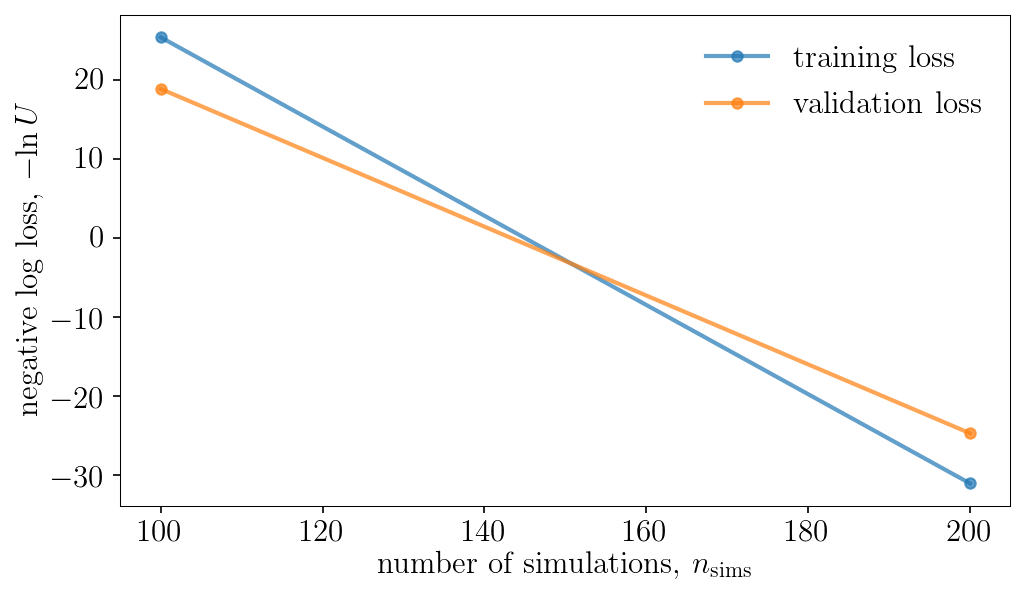

Population 2/150
Sampling proposal density...
Done.


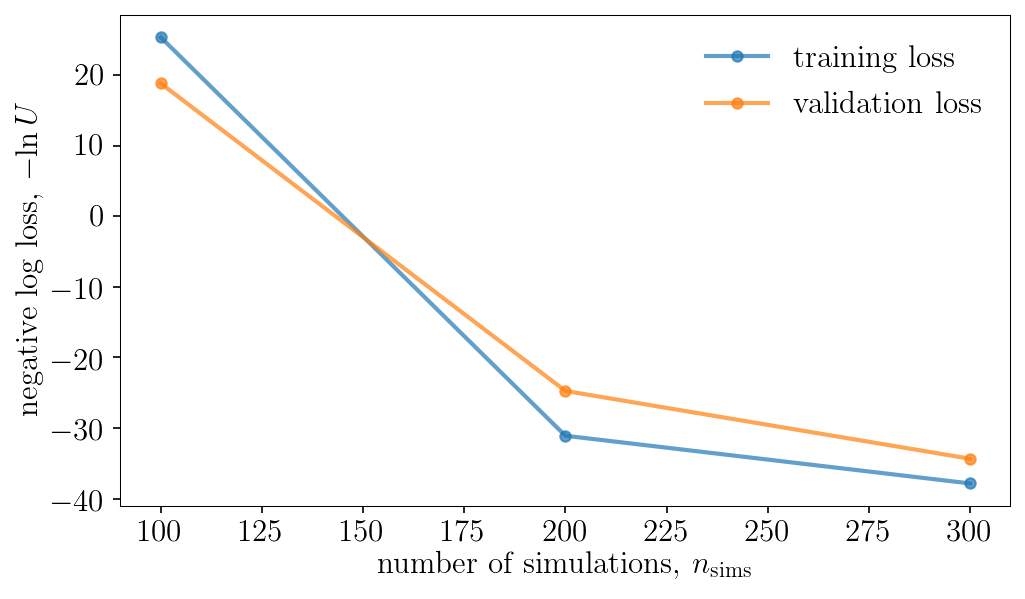

Population 3/150
Sampling proposal density...
Done.


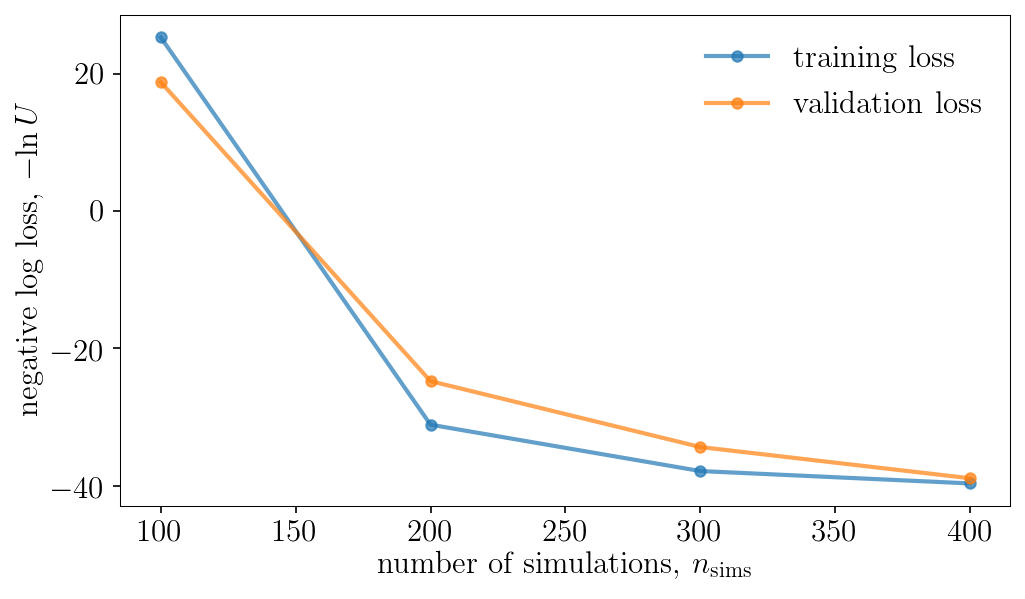

Population 4/150
Sampling proposal density...
Done.


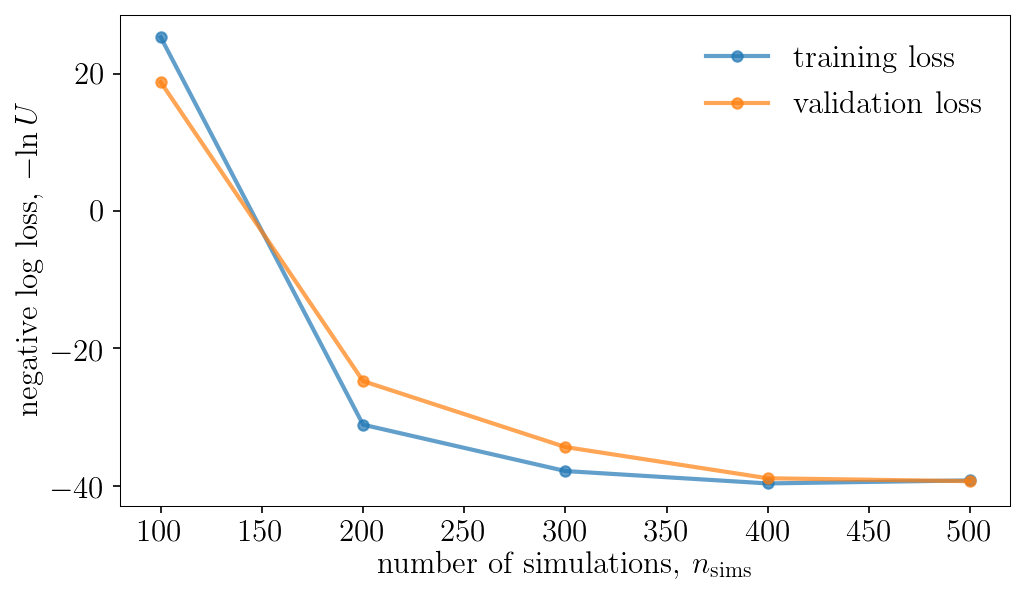

Population 5/150
Sampling proposal density...
Done.


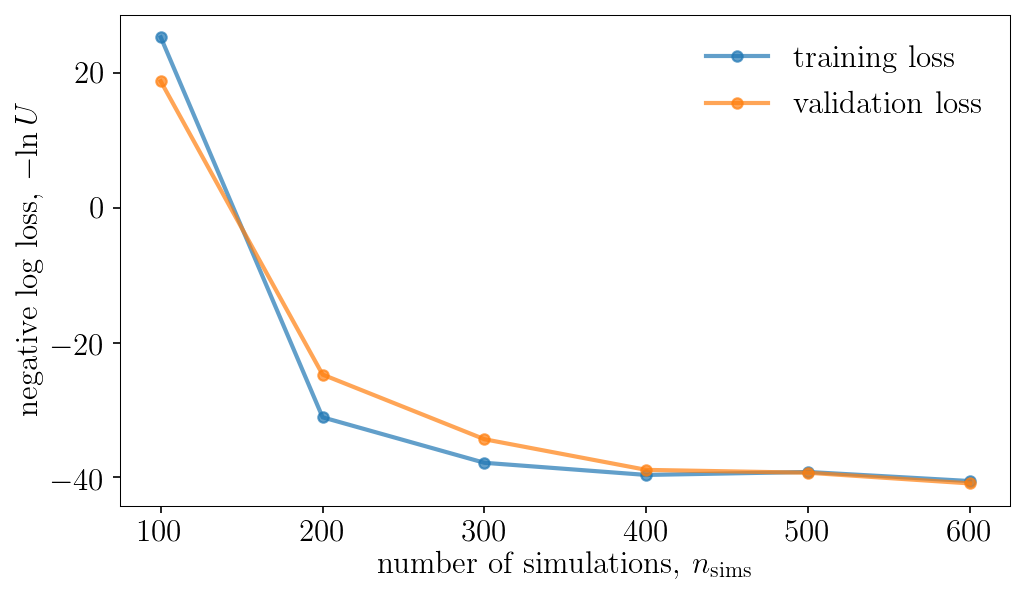

Population 6/150
Sampling proposal density...
Done.


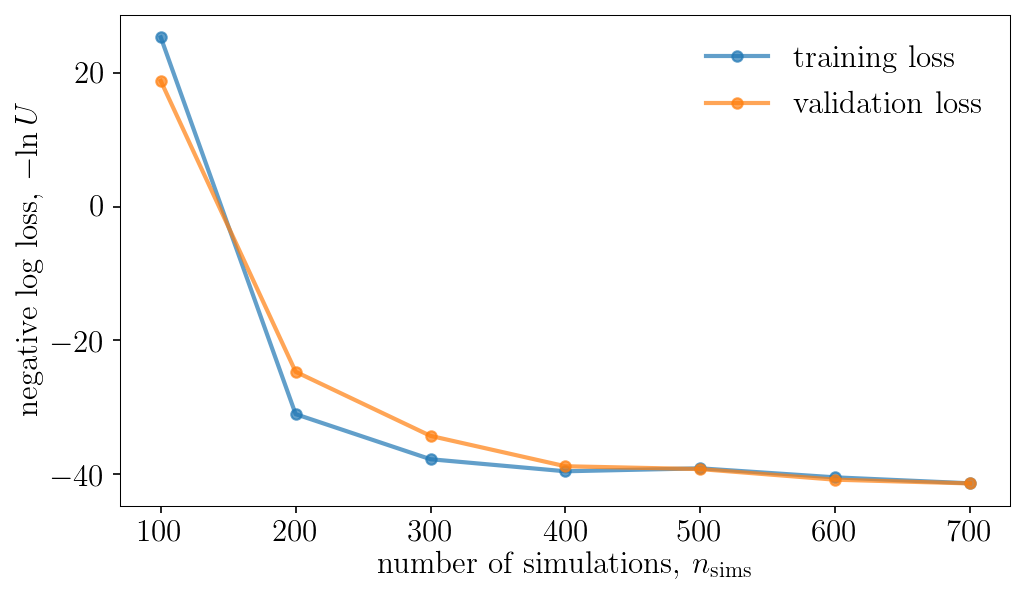

Population 7/150
Sampling proposal density...
Done.


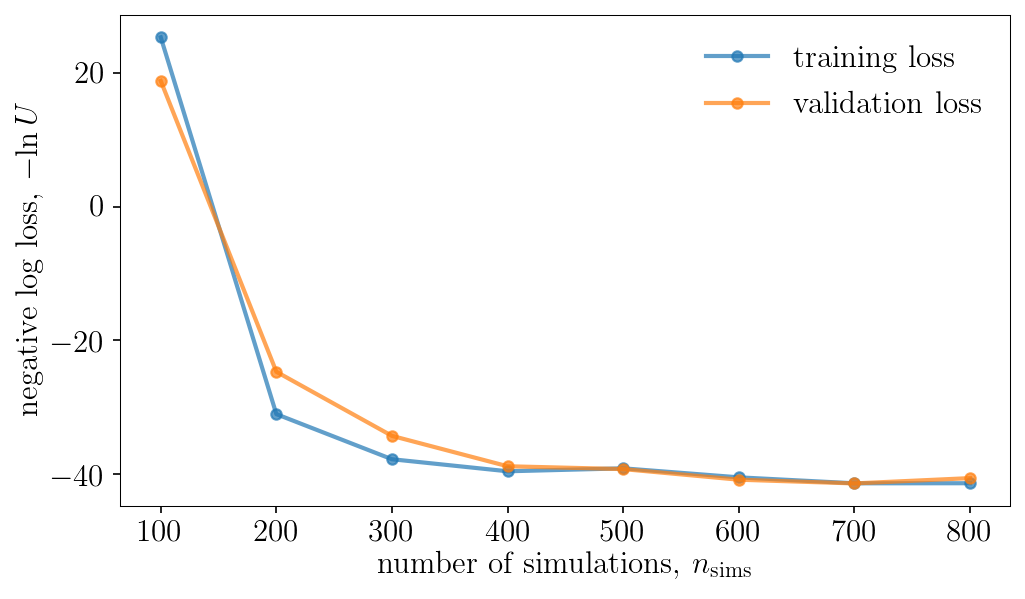

Population 8/150
Sampling proposal density...
Done.


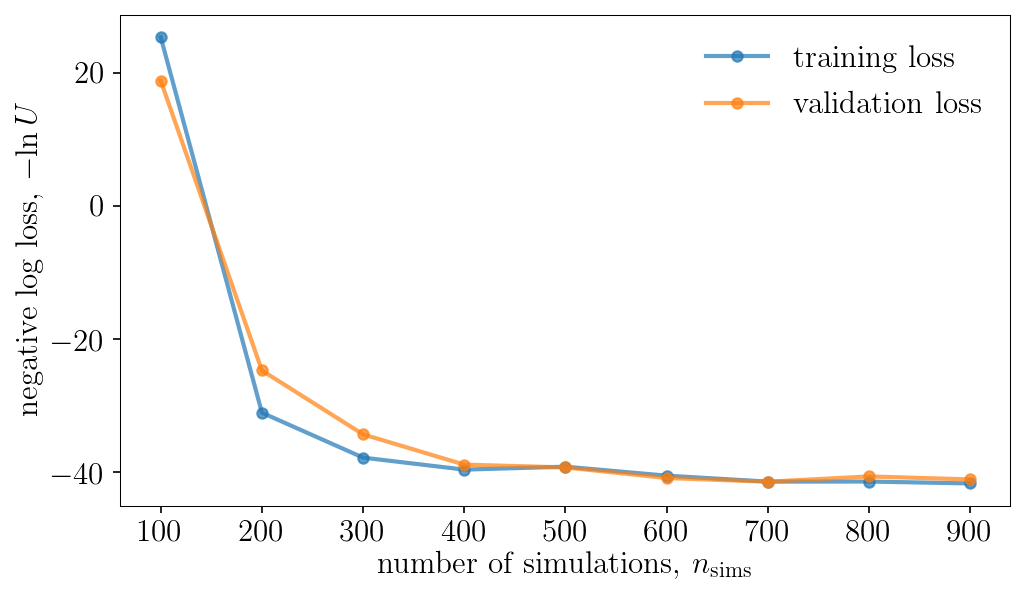

Population 9/150
Sampling proposal density...
Done.


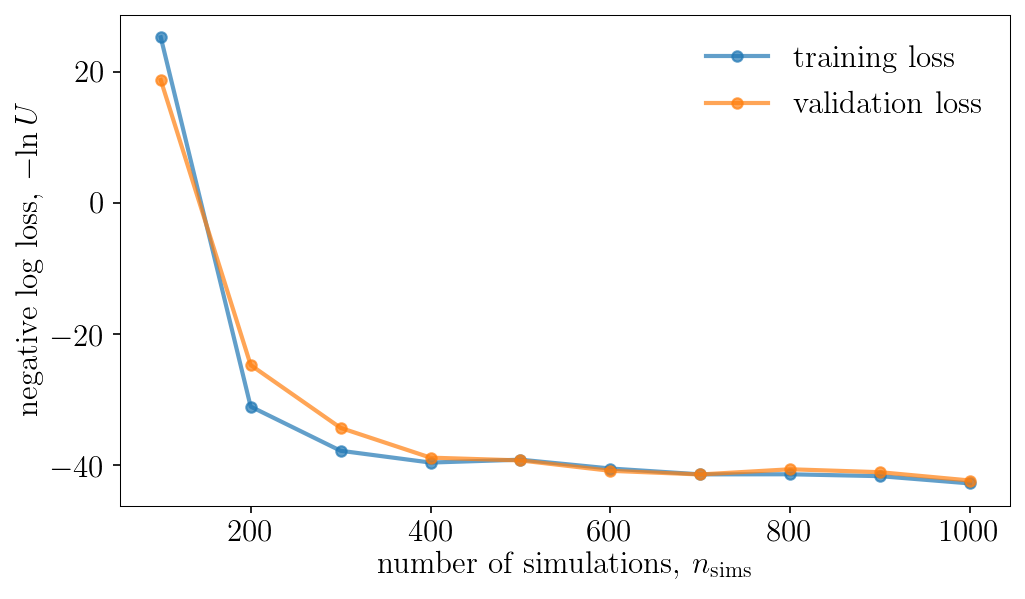

Population 10/150
Sampling proposal density...
Done.


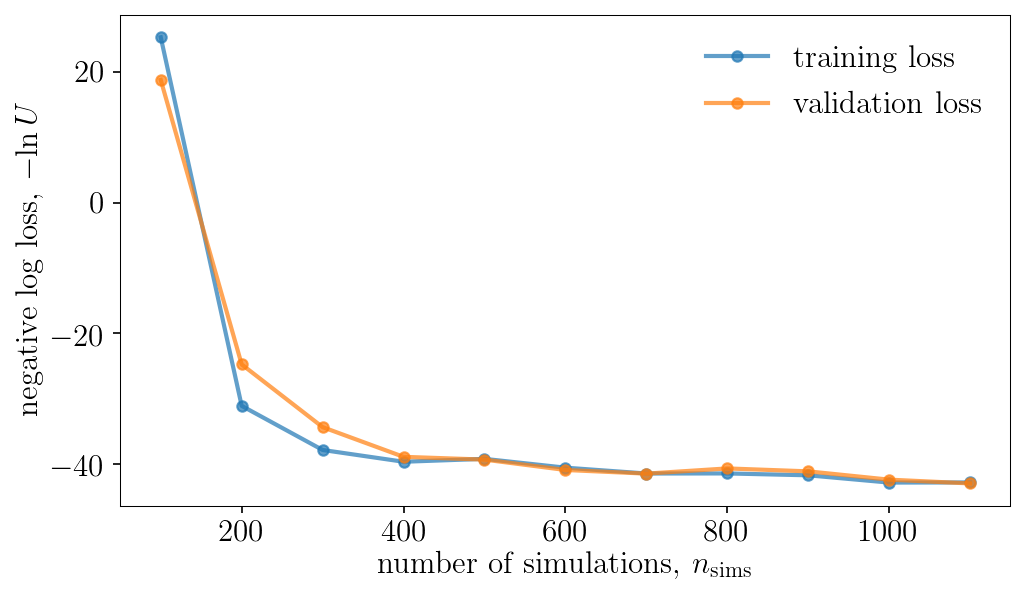

Population 11/150
Sampling proposal density...
Done.


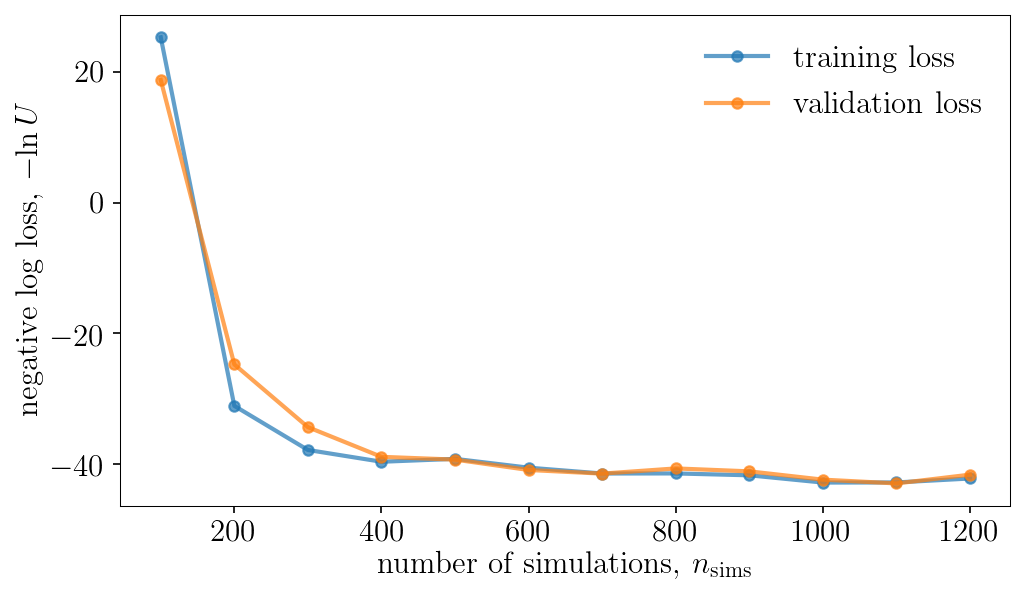

Population 12/150
Sampling proposal density...
Done.


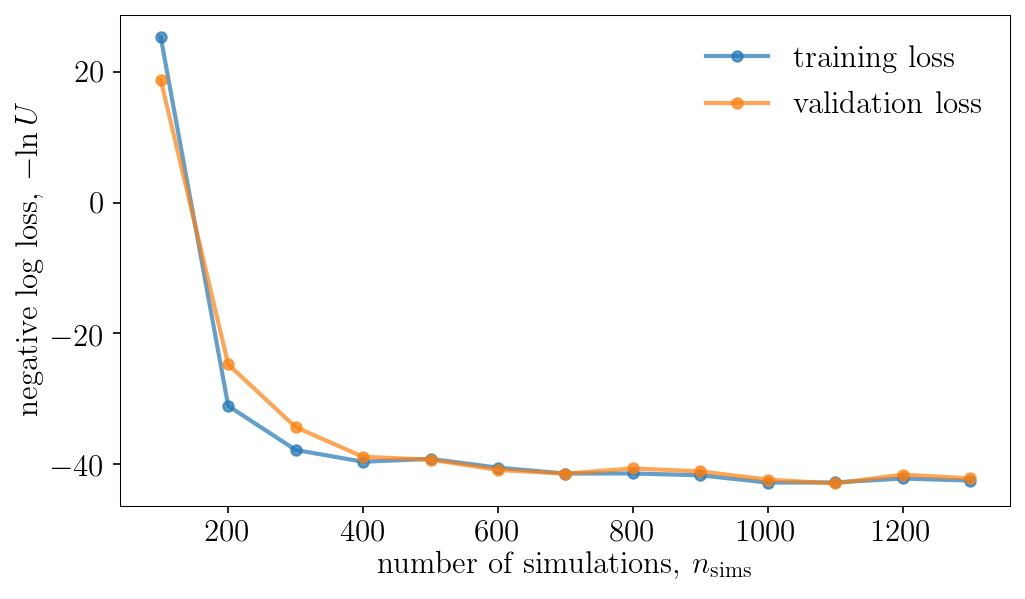

Population 13/150
Sampling proposal density...
Done.


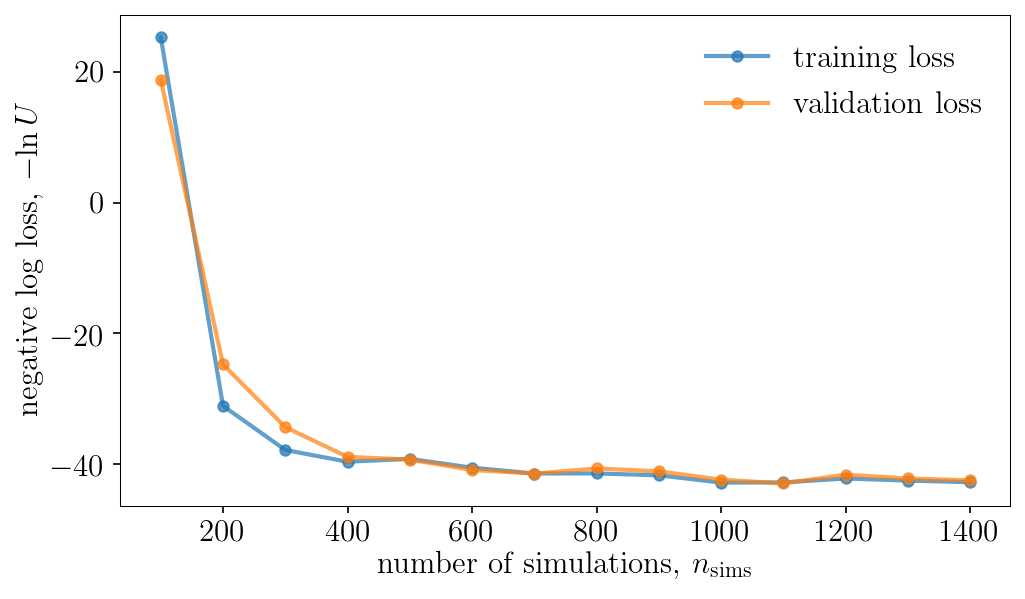

Population 14/150
Sampling proposal density...
Done.


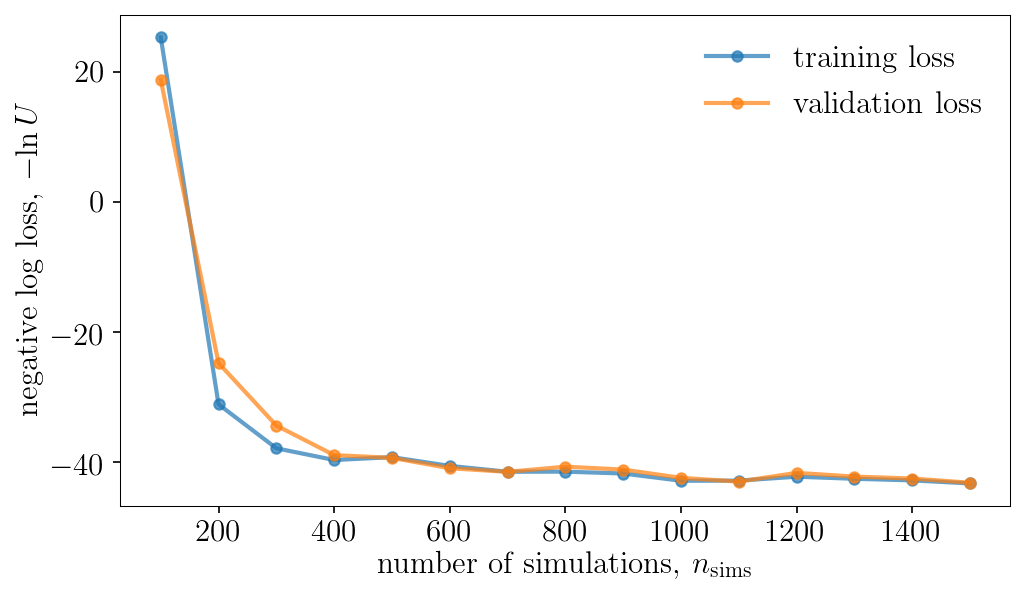

Population 15/150
Sampling proposal density...
Done.


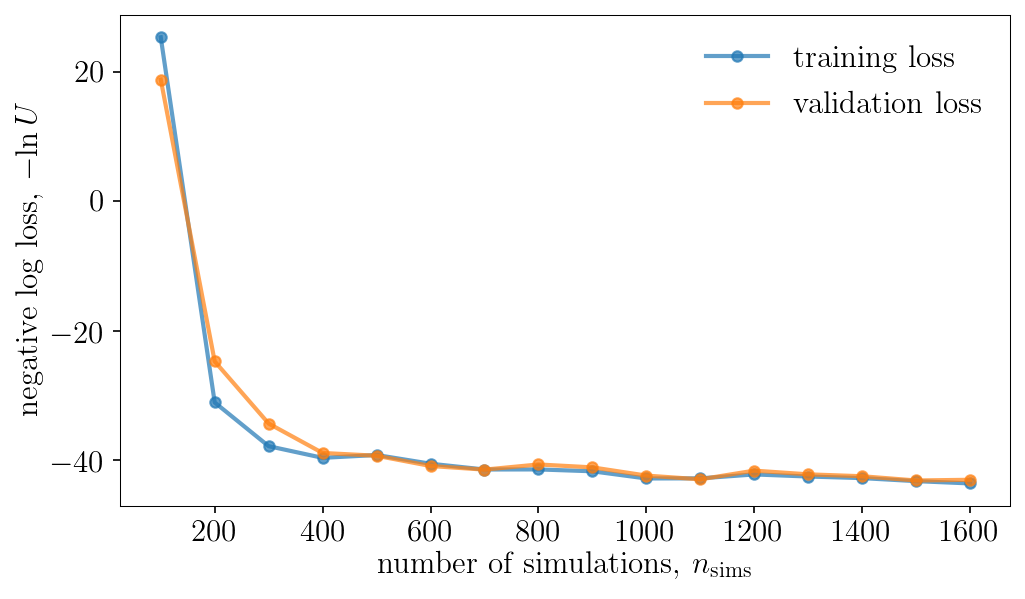

Population 16/150
Sampling proposal density...
Done.


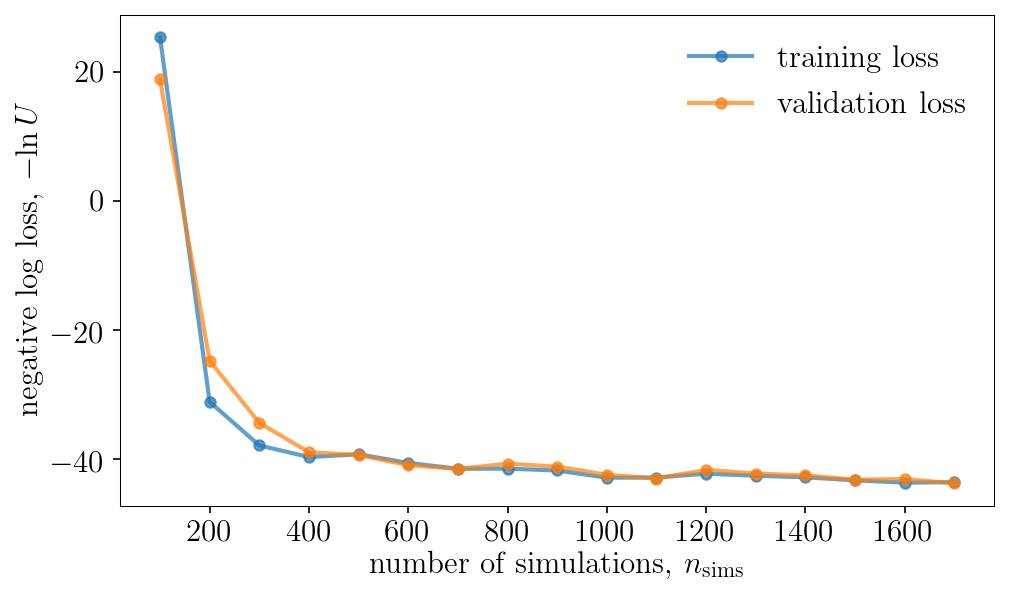

Population 17/150
Sampling proposal density...
Done.


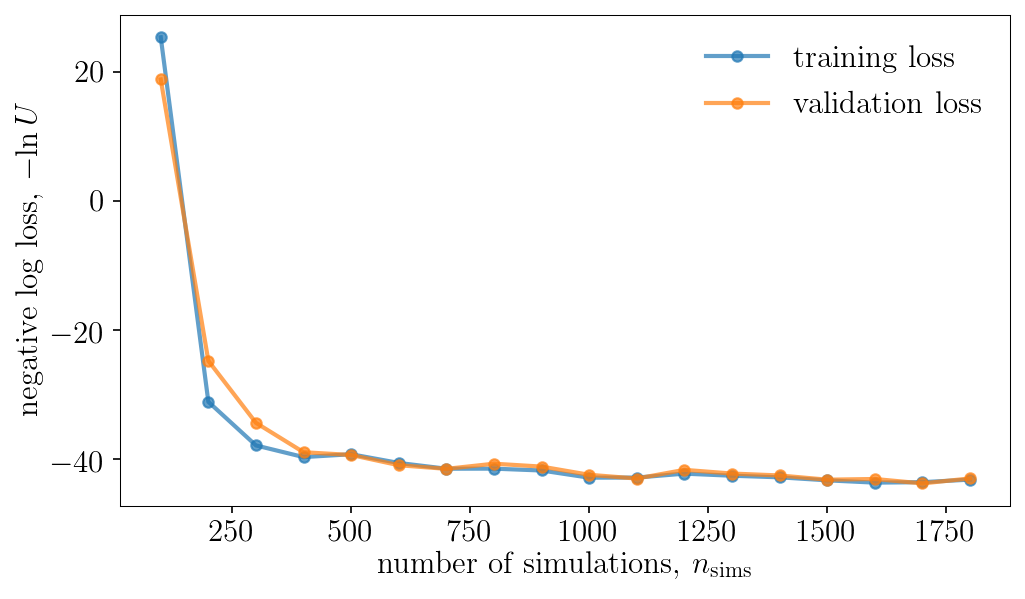

Population 18/150
Sampling proposal density...
Done.


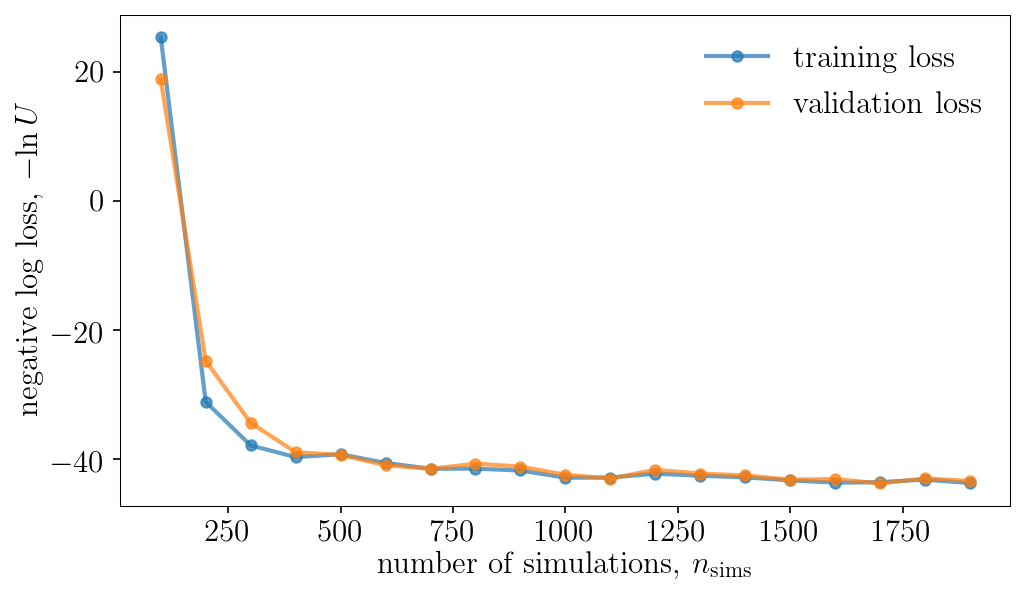

Population 19/150
Sampling proposal density...
Done.


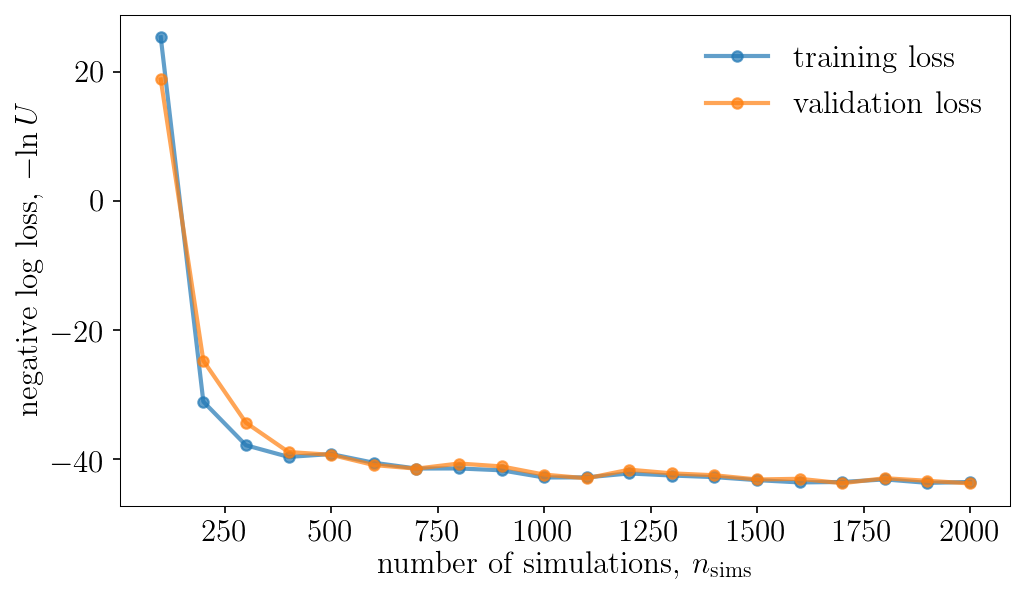

Population 20/150
Sampling proposal density...
Done.


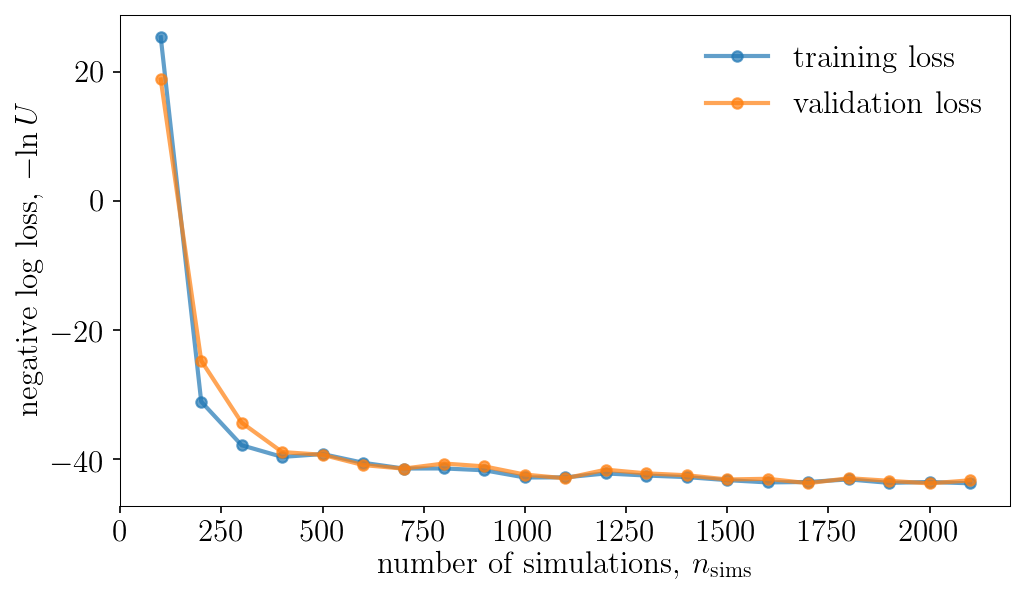

Population 21/150
Sampling proposal density...
Done.


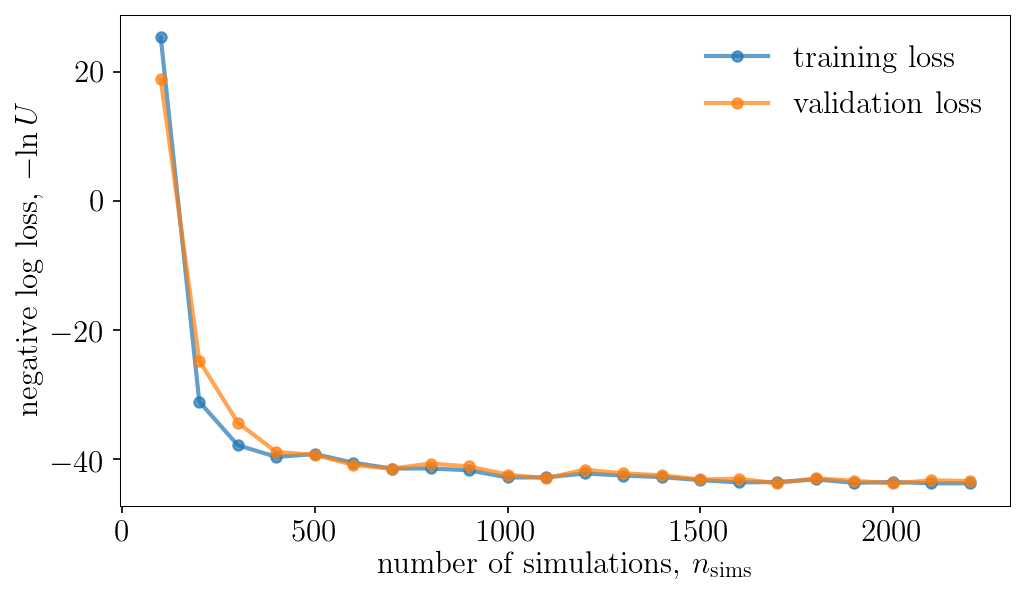

Population 22/150
Sampling proposal density...
Done.


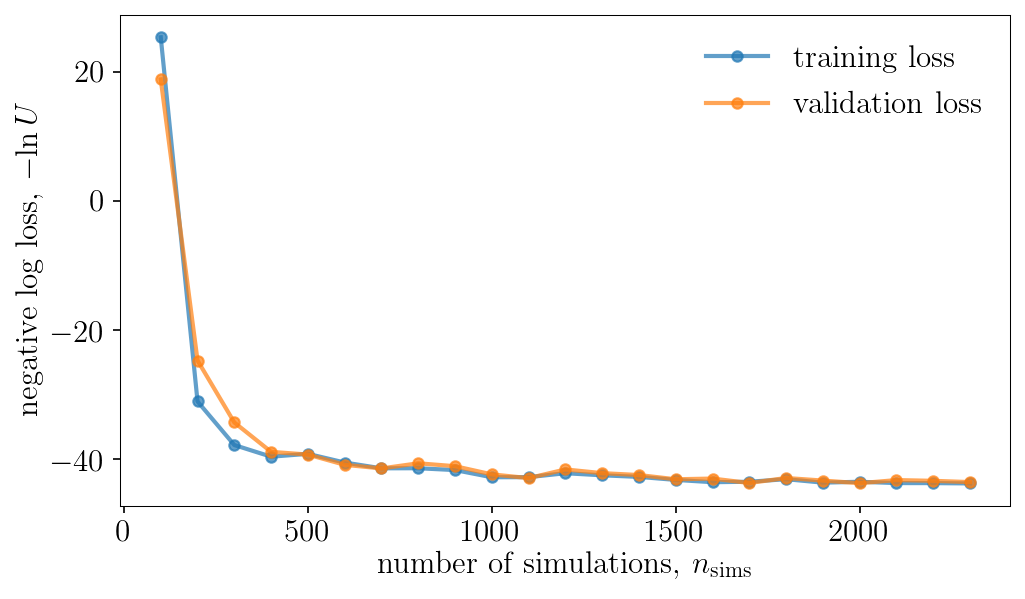

Population 23/150
Sampling proposal density...
Done.


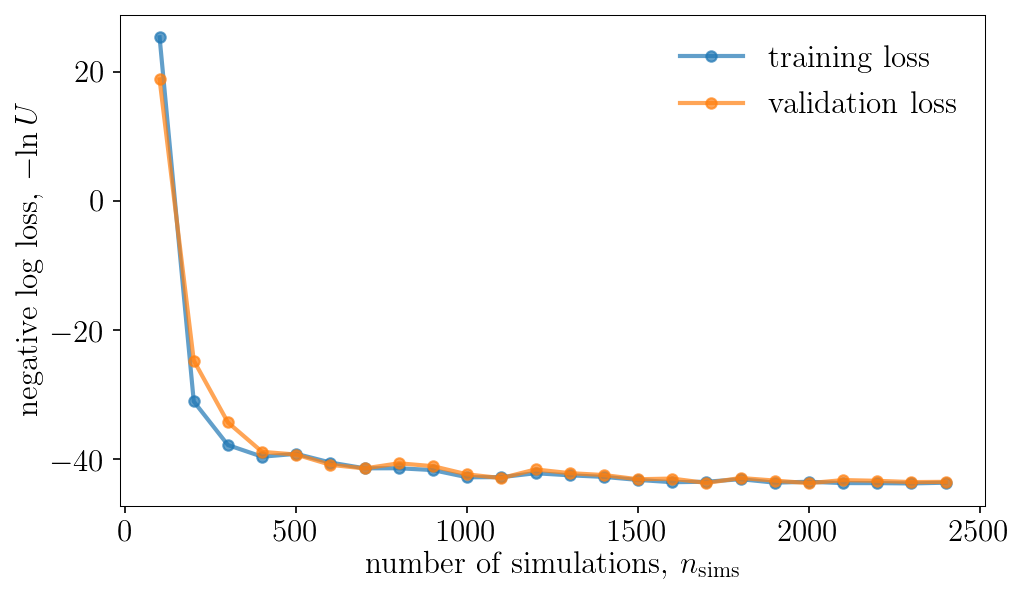

Population 24/150
Sampling proposal density...
Done.


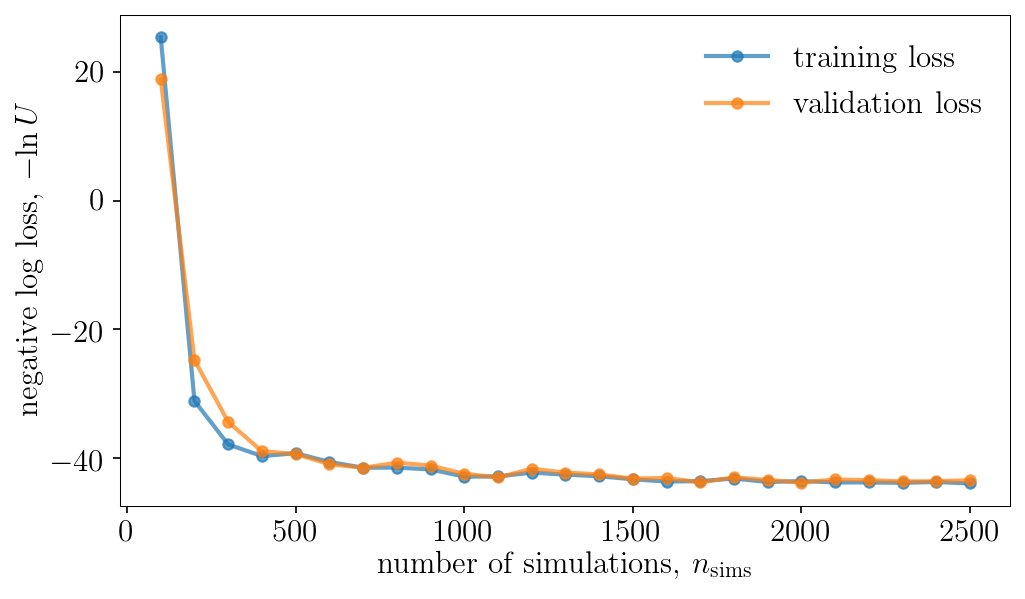

Population 25/150
Sampling proposal density...
Done.


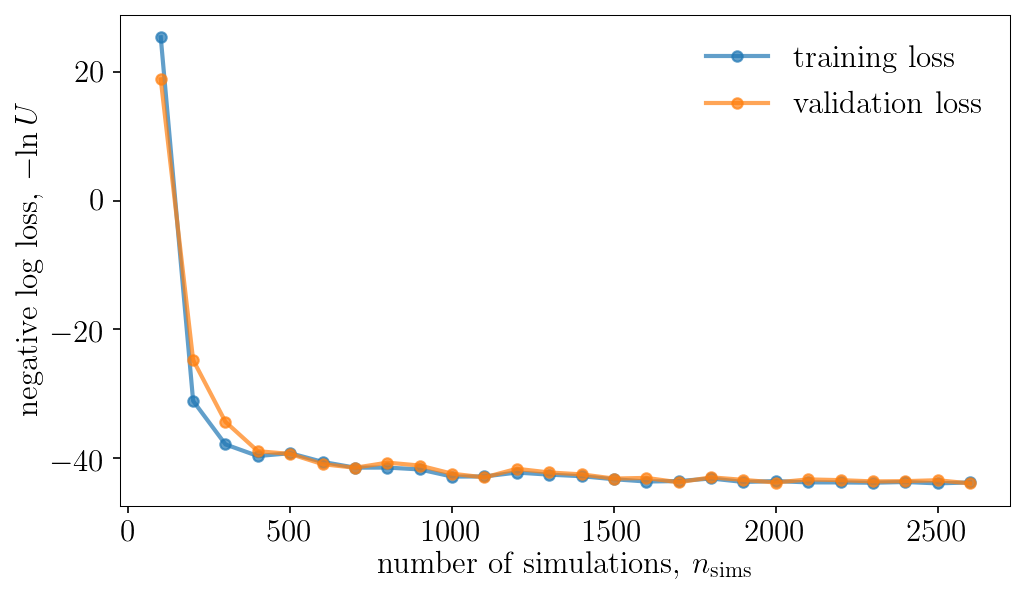

Population 26/150
Sampling proposal density...
Done.


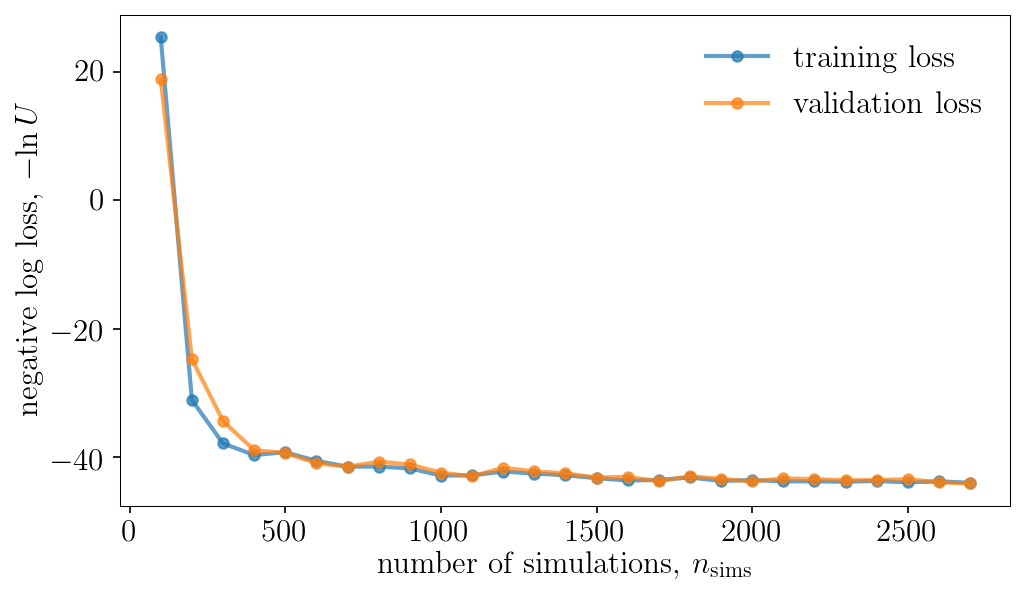

Population 27/150
Sampling proposal density...
Done.


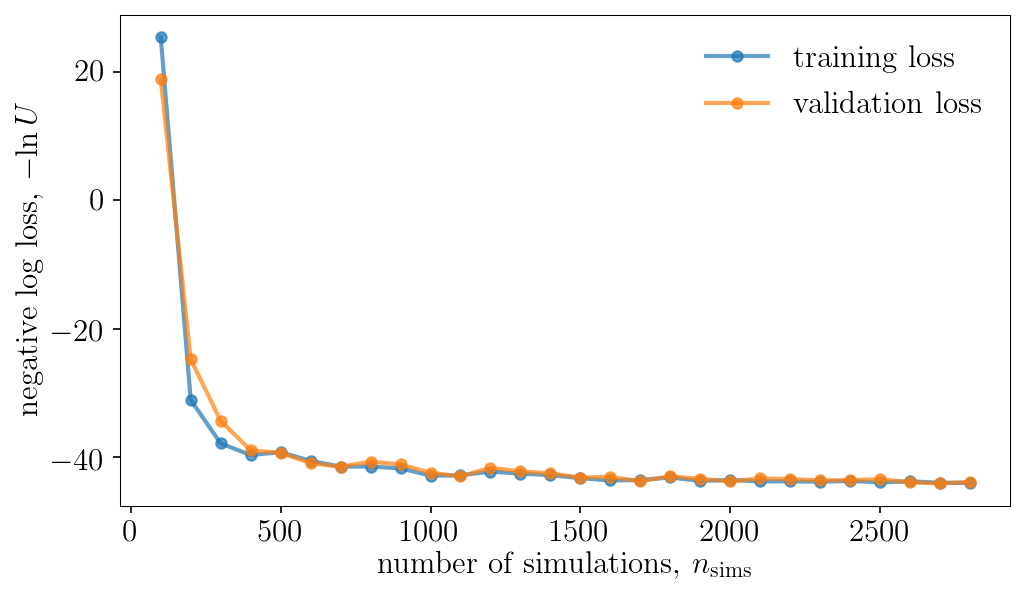

Population 28/150
Sampling proposal density...
Done.


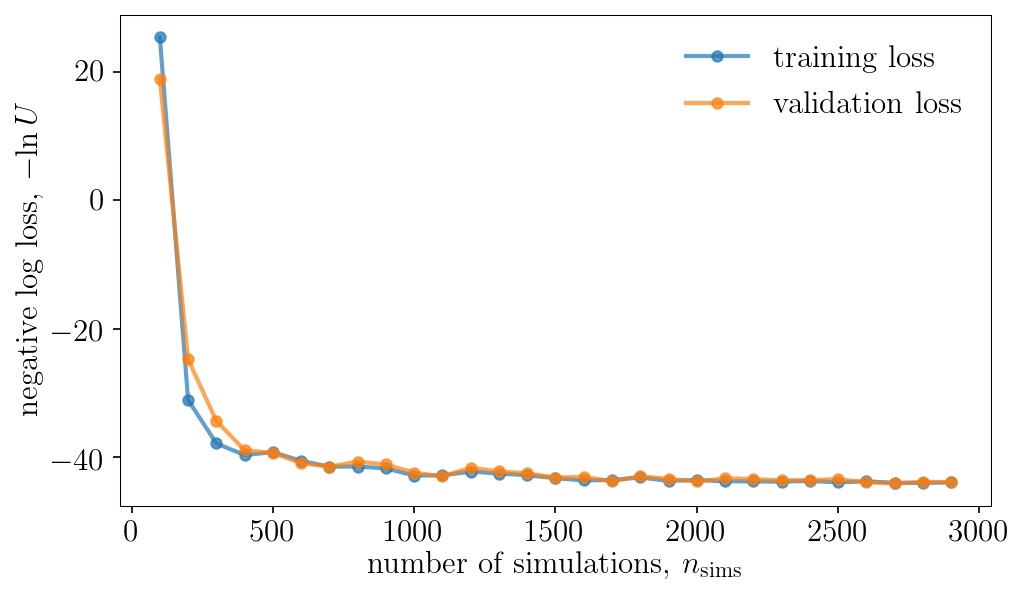

Population 29/150
Sampling proposal density...
Done.


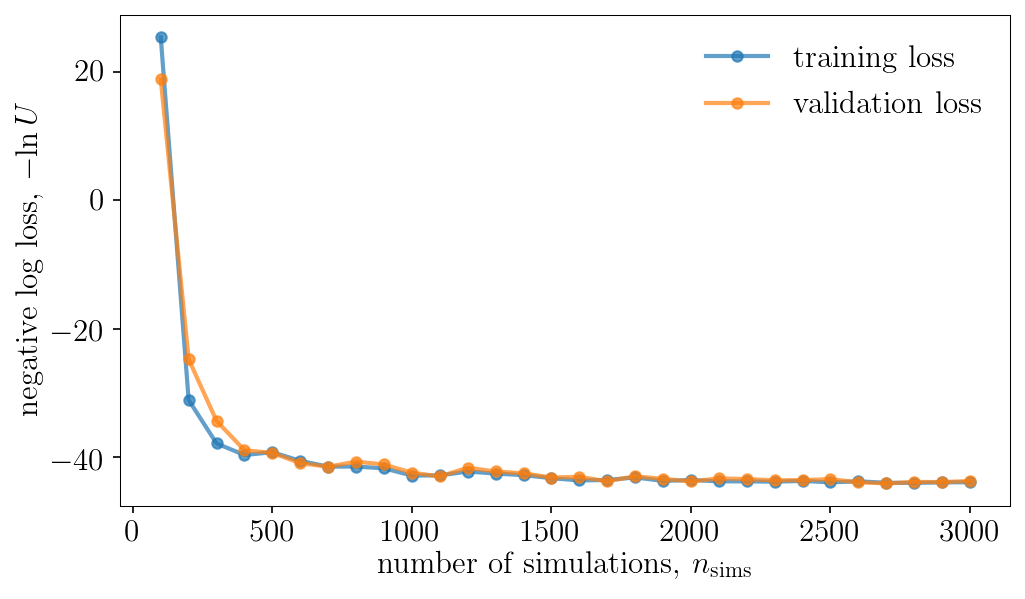

Population 30/150
Sampling proposal density...
Done.


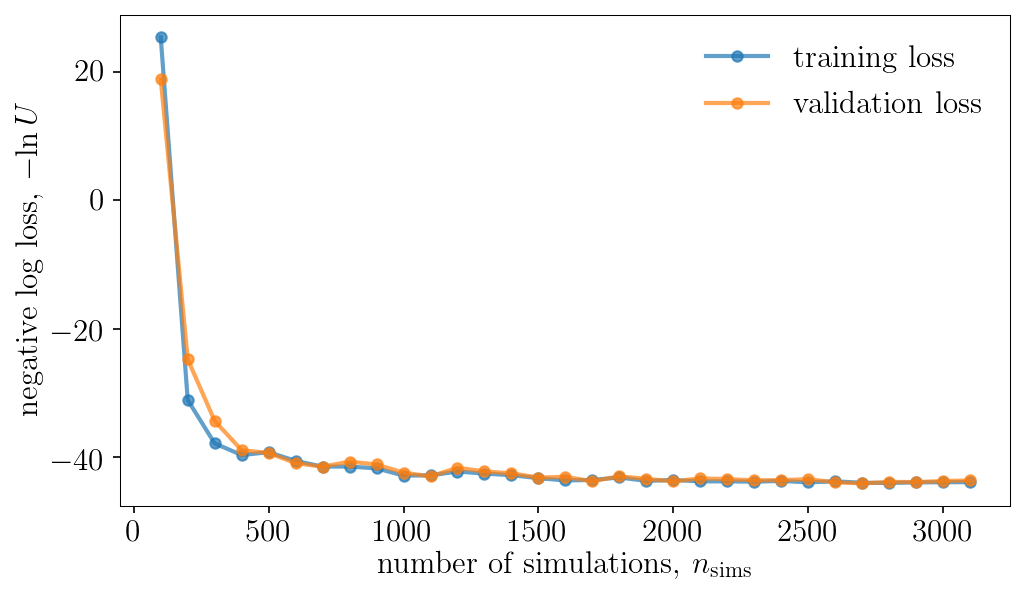

Population 31/150
Sampling proposal density...
Done.


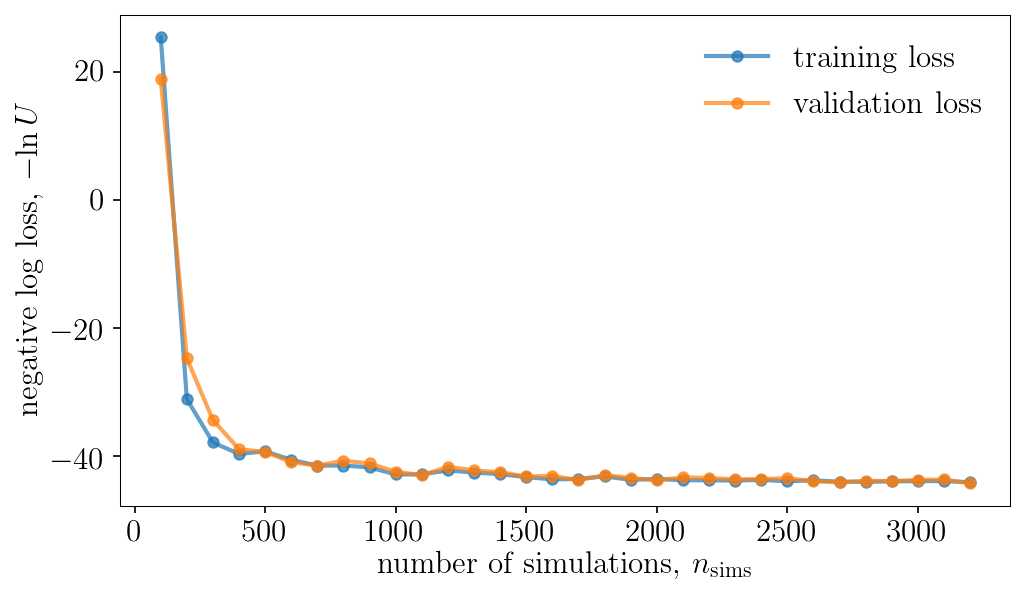

Population 32/150
Sampling proposal density...
Done.


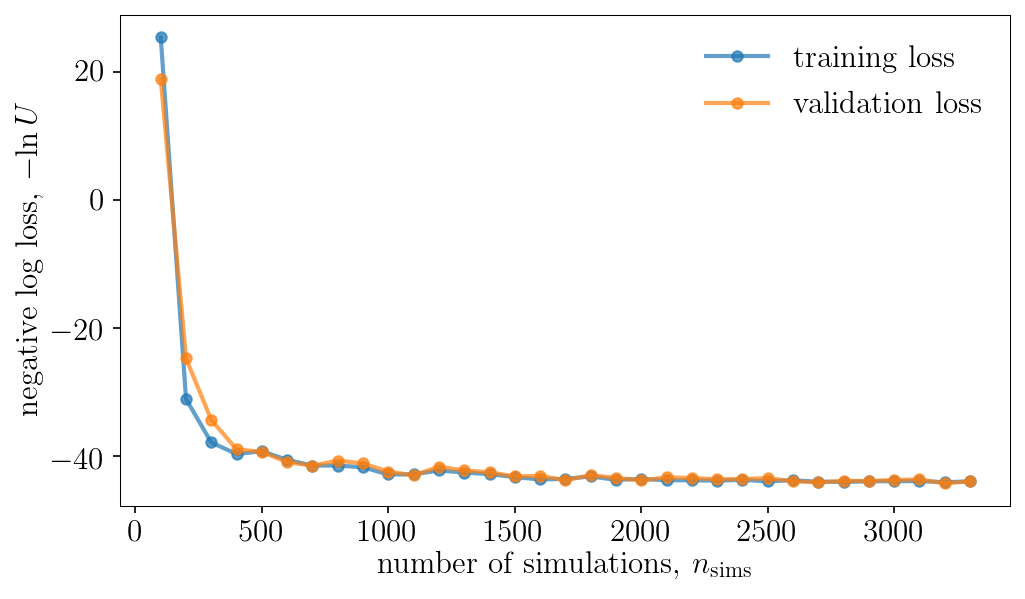

Population 33/150
Sampling proposal density...
Done.


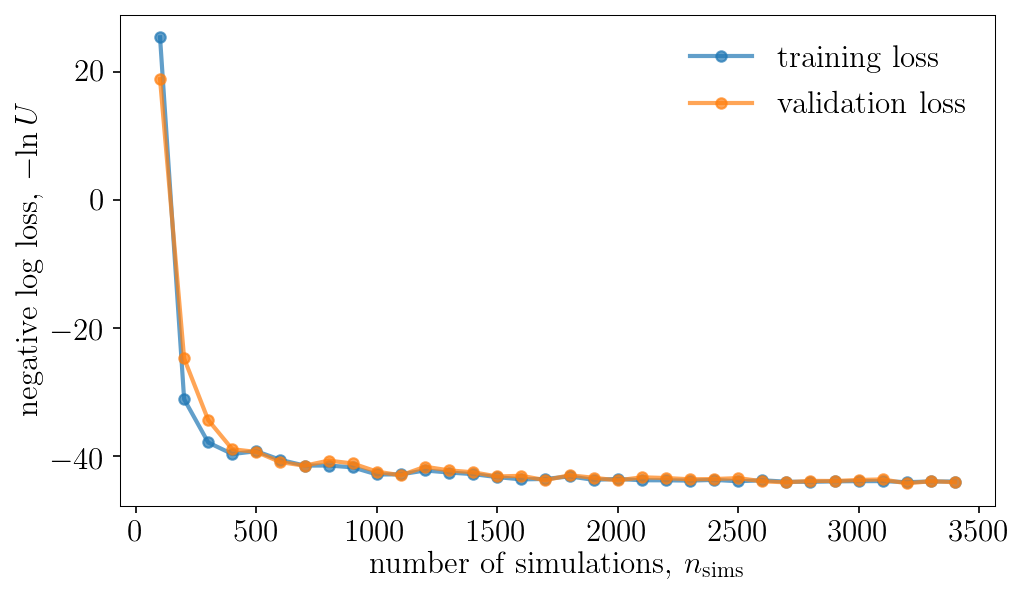

Population 34/150
Sampling proposal density...
Done.


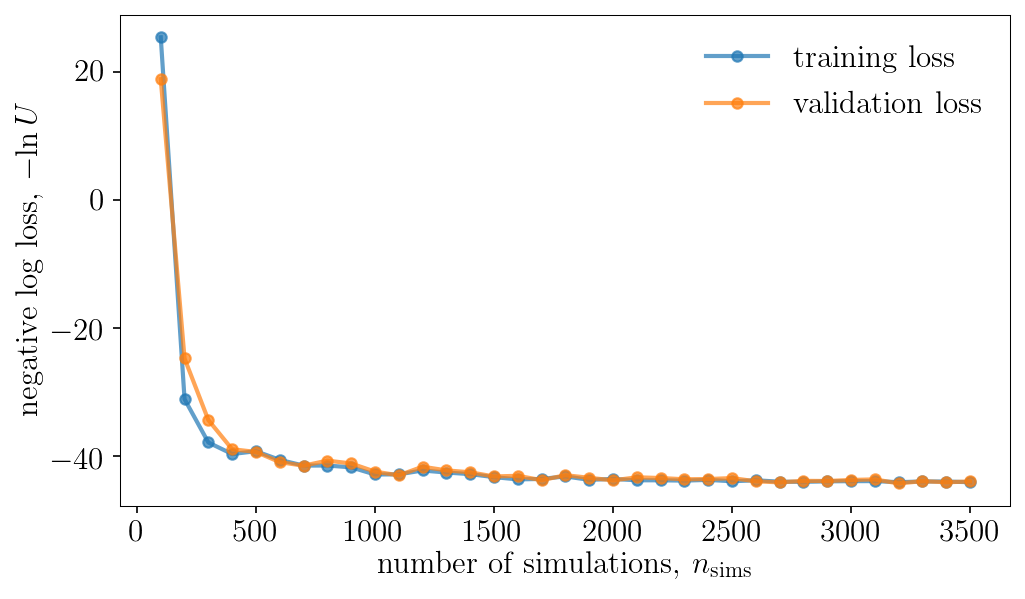

Population 35/150
Sampling proposal density...
Done.


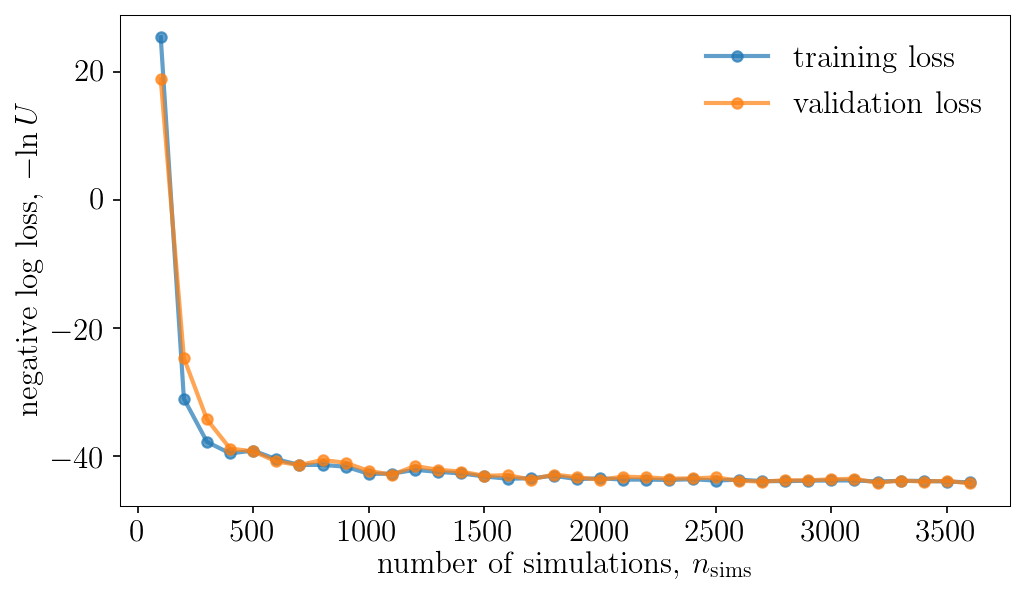

Population 36/150
Sampling proposal density...
Done.


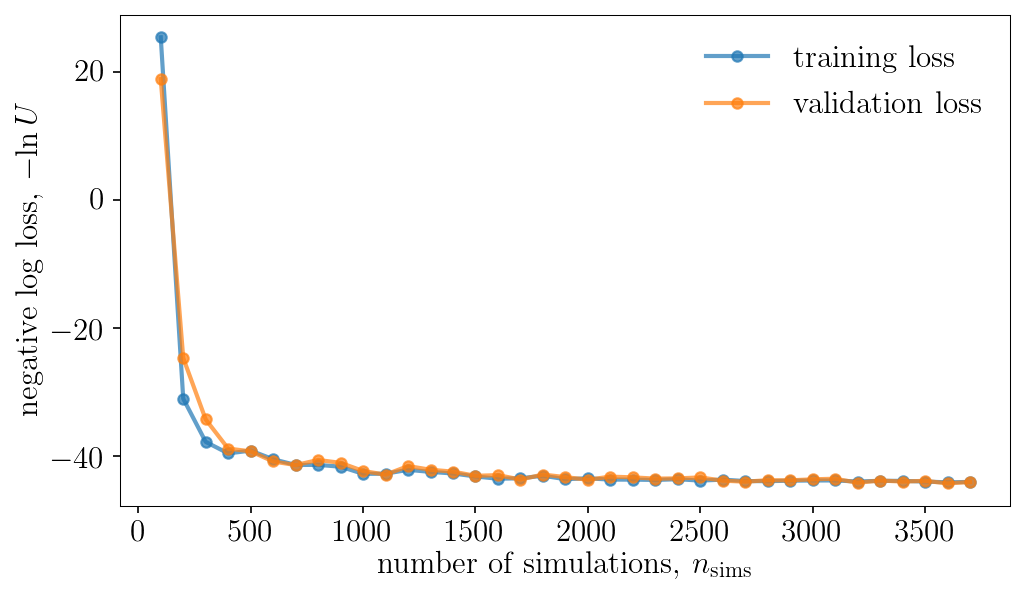

Population 37/150
Sampling proposal density...
Done.


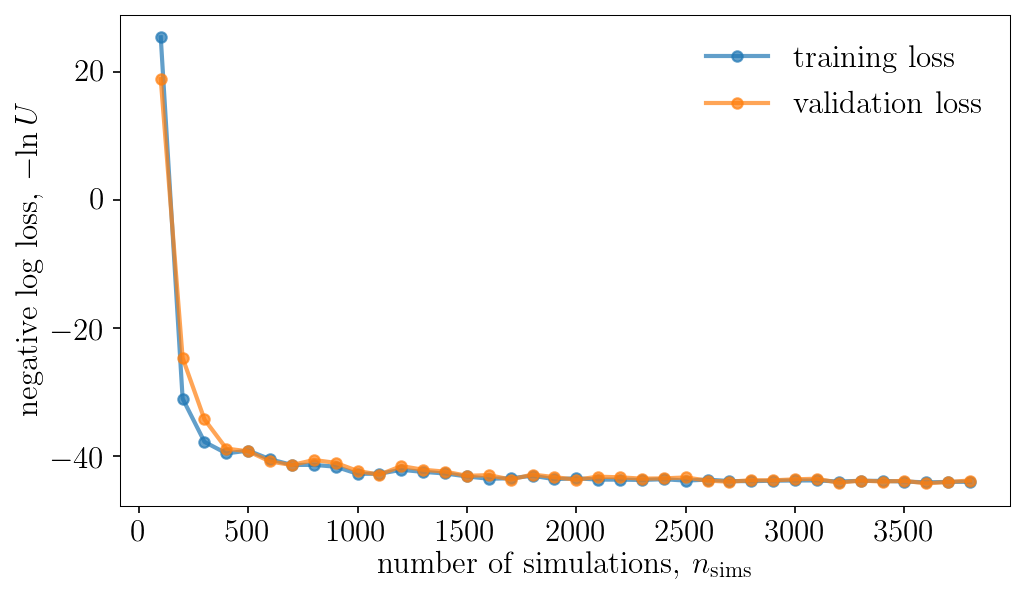

Population 38/150
Sampling proposal density...
Done.


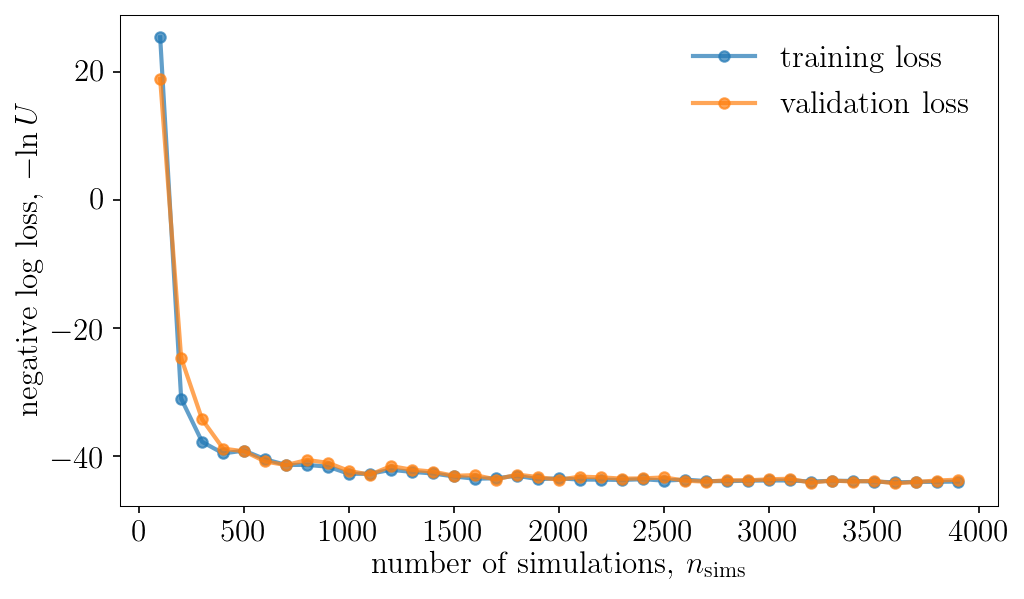

Population 39/150
Sampling proposal density...
Done.


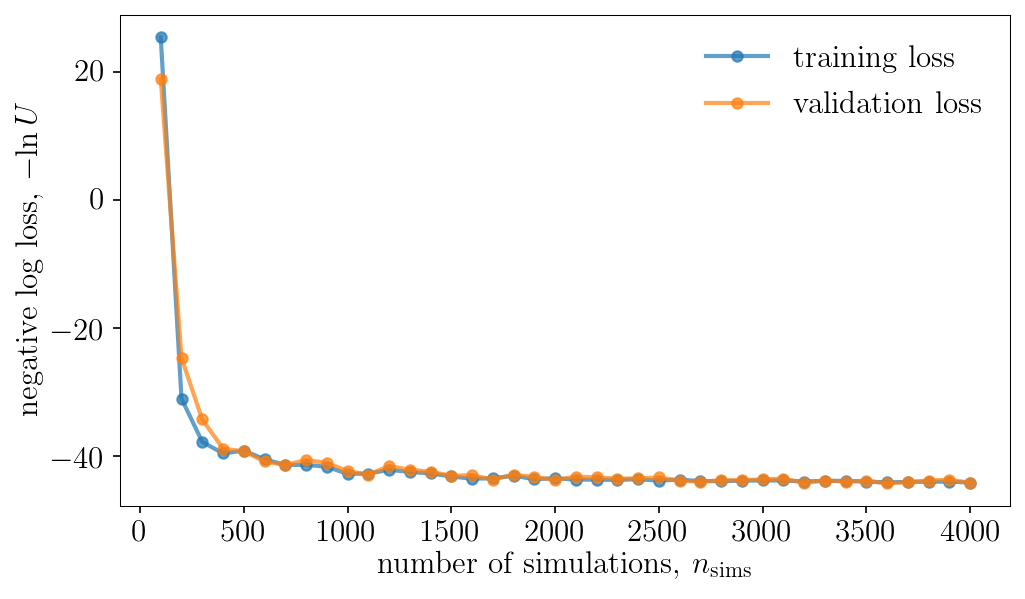

Population 40/150
Sampling proposal density...
Done.


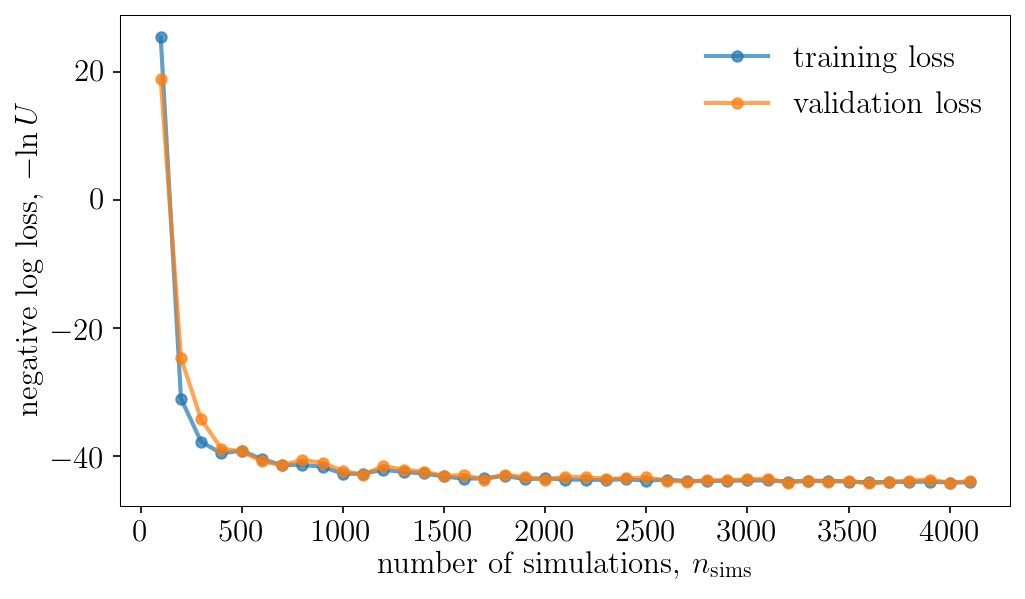

Population 41/150
Sampling proposal density...
Done.


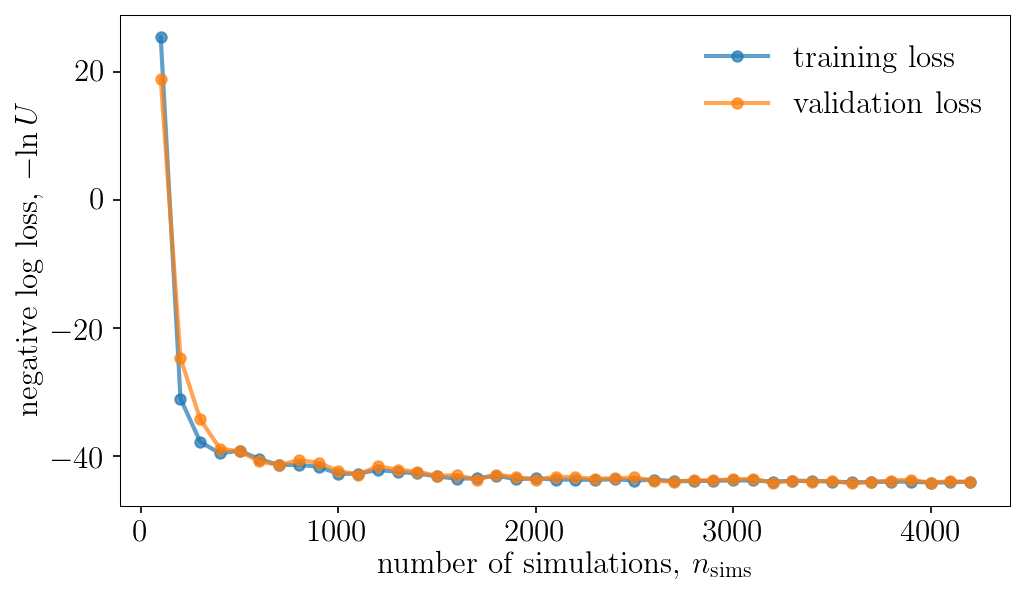

Population 42/150
Sampling proposal density...
Done.


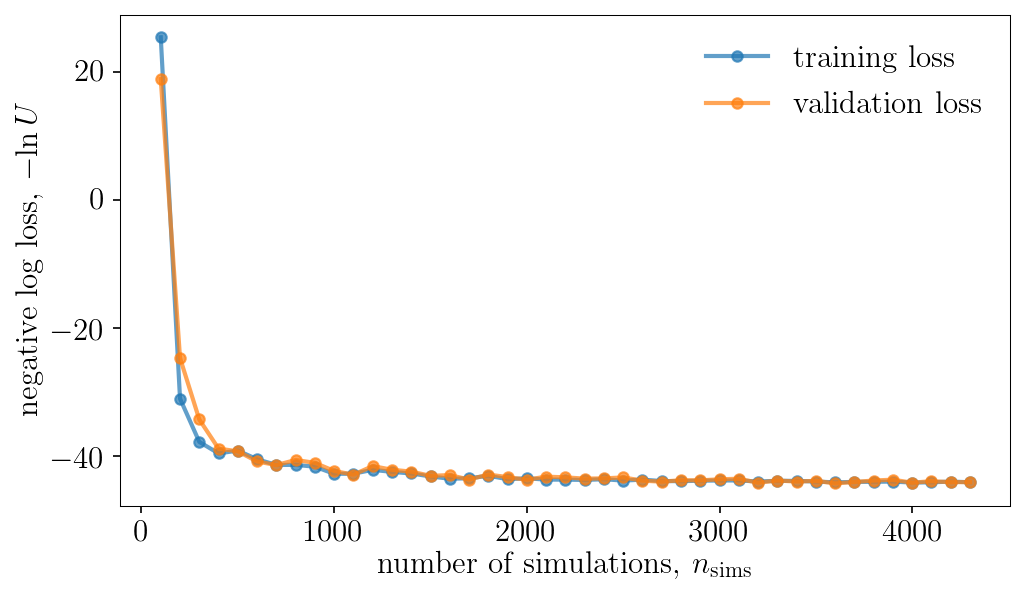

Population 43/150
Sampling proposal density...
Done.


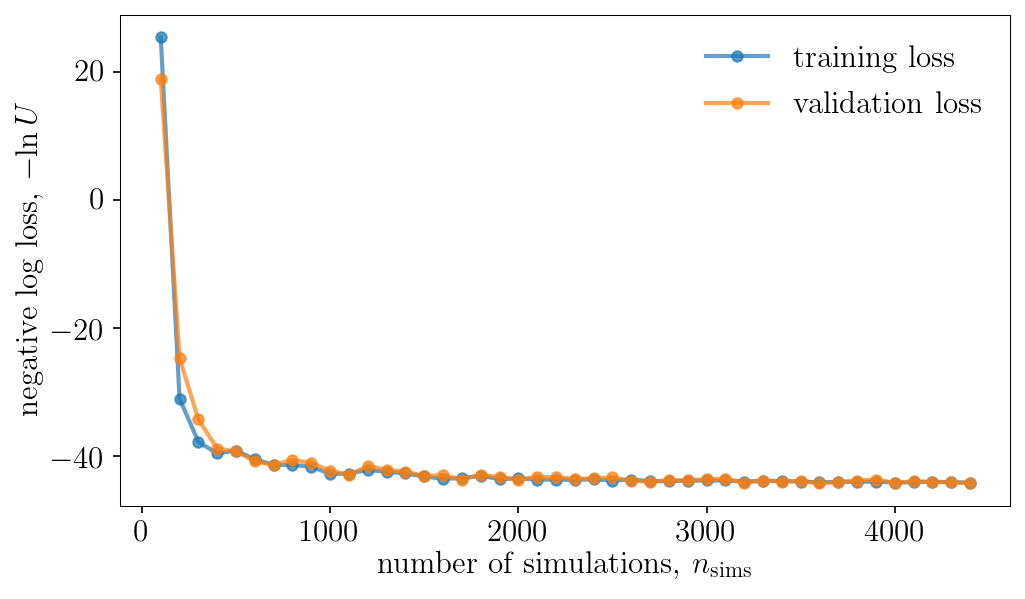

Population 44/150
Sampling proposal density...
Done.


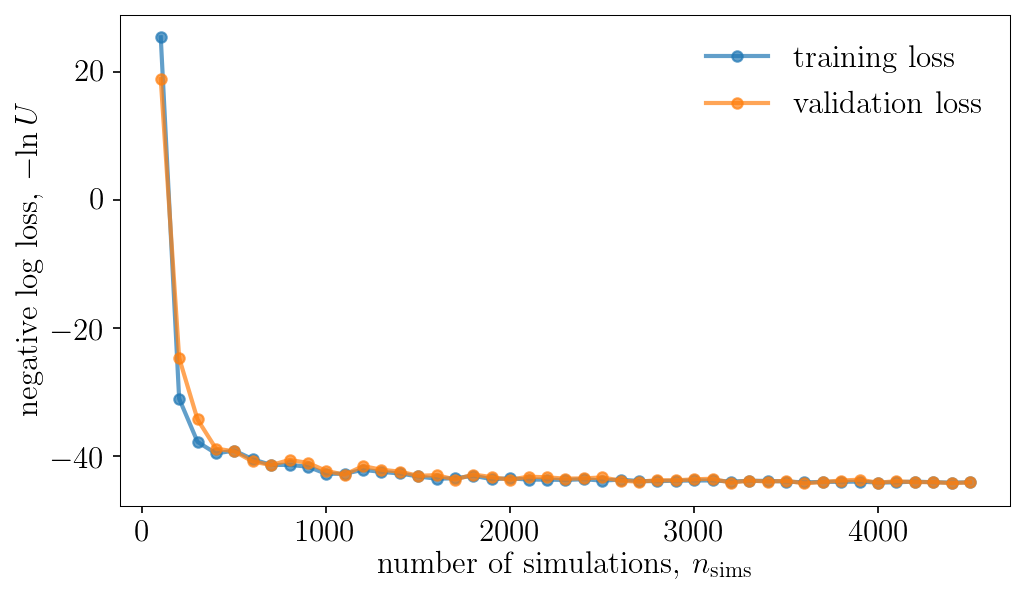

Population 45/150
Sampling proposal density...
Done.


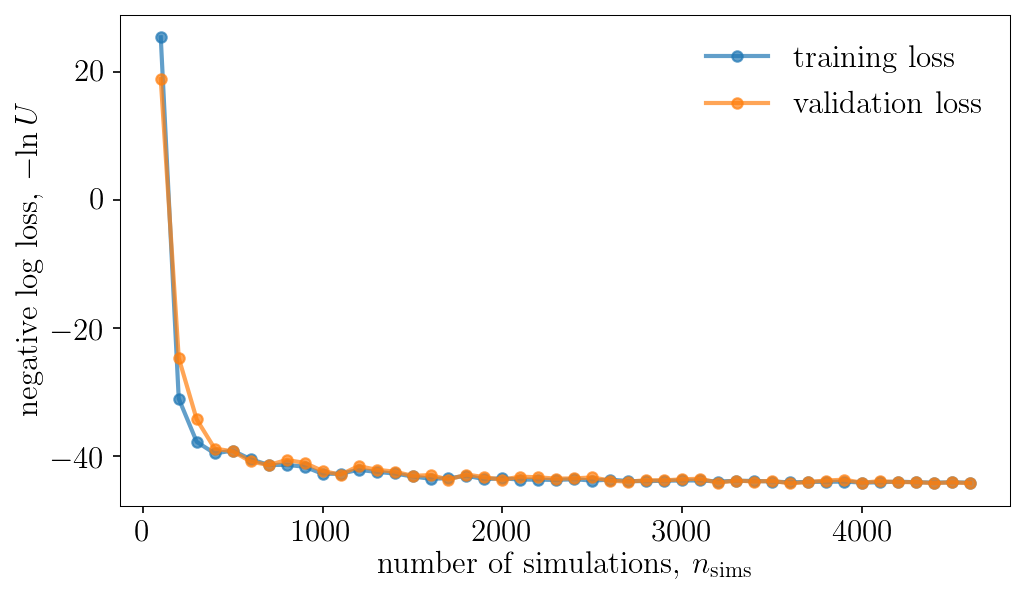

Population 46/150
Sampling proposal density...
Done.


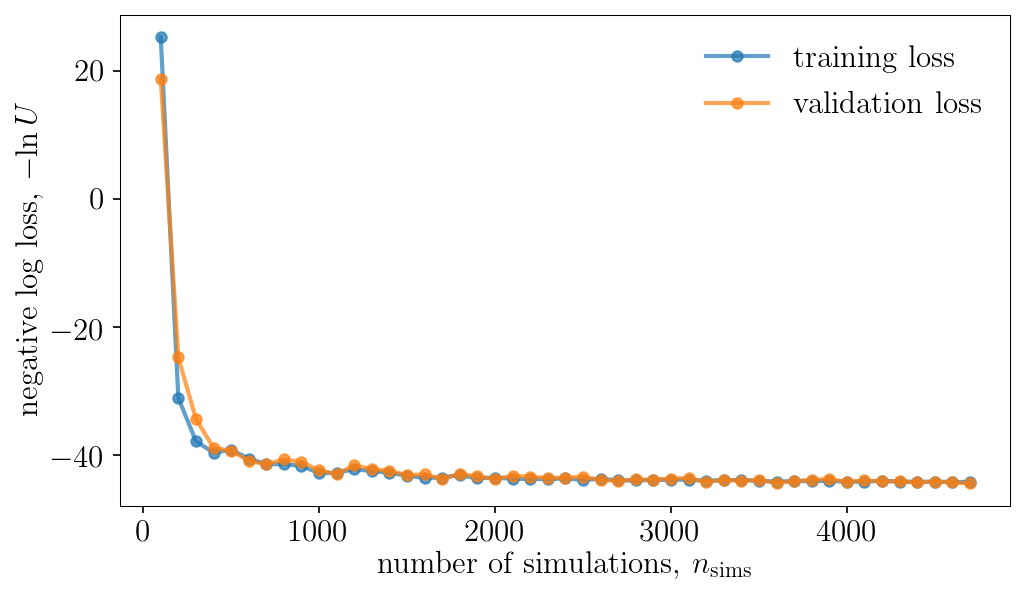

Population 47/150
Sampling proposal density...
Done.


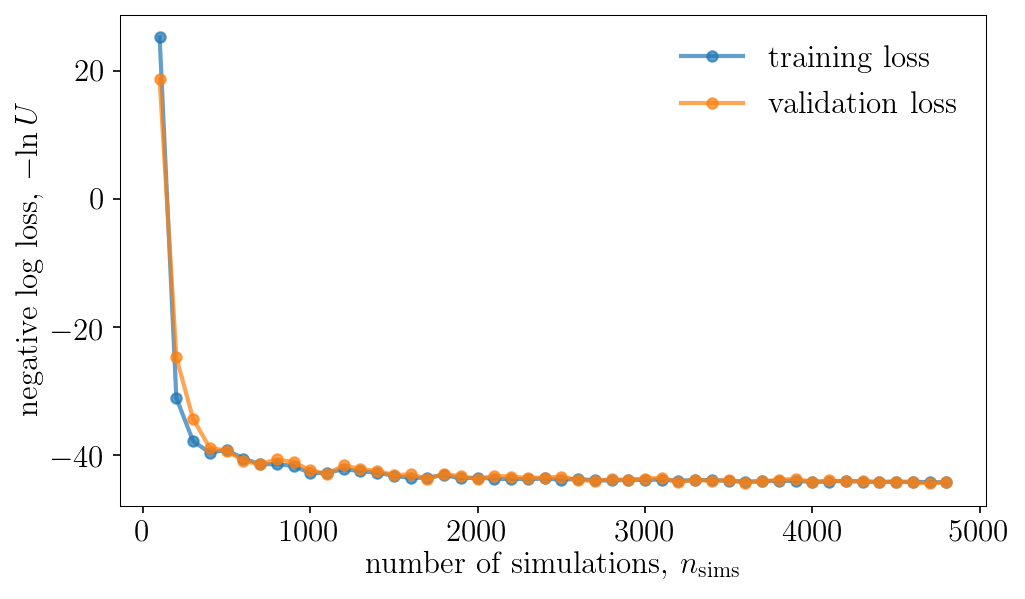

Population 48/150
Sampling proposal density...
Done.


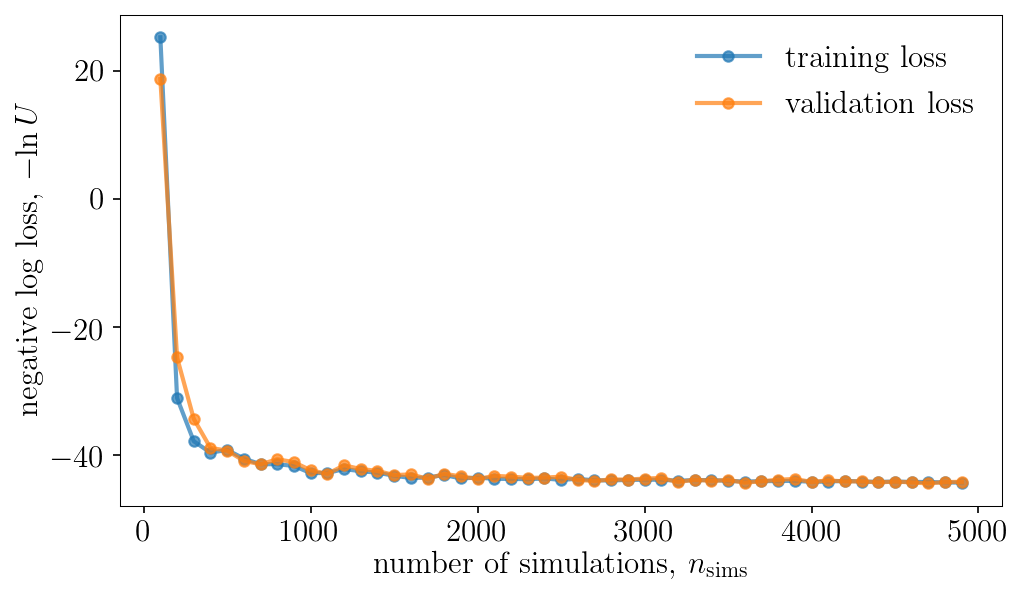

Population 49/150
Sampling proposal density...
Done.


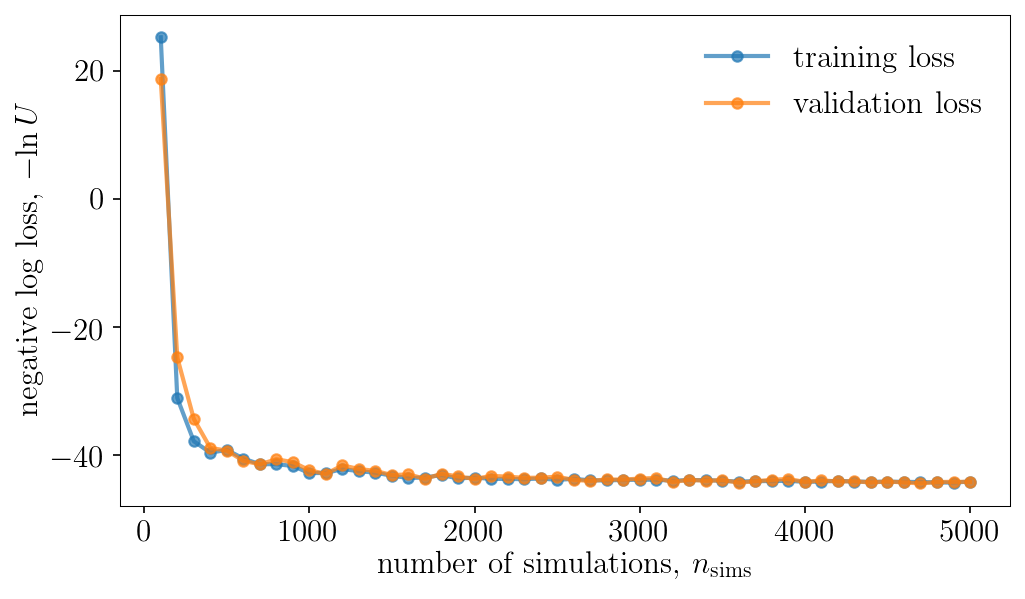

Population 50/150
Sampling proposal density...
Done.


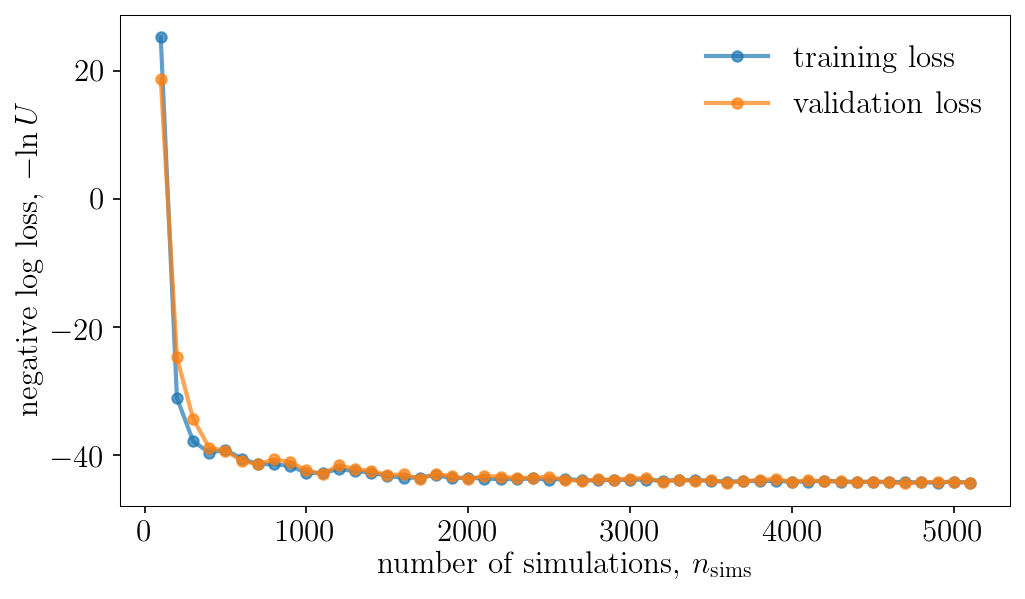

Population 51/150
Sampling proposal density...
Done.


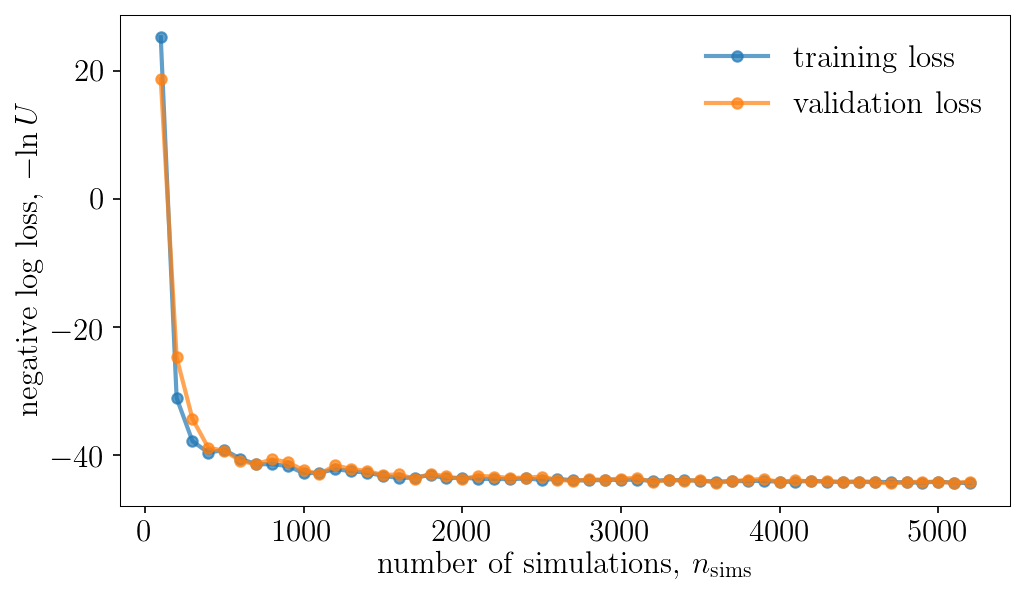

Population 52/150
Sampling proposal density...
Done.


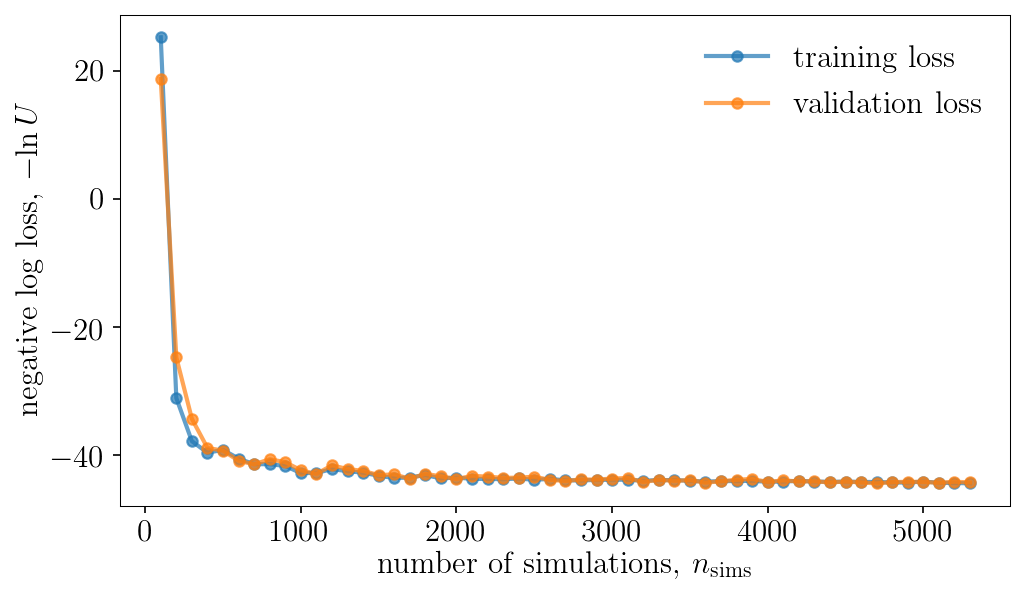

Population 53/150
Sampling proposal density...
Done.


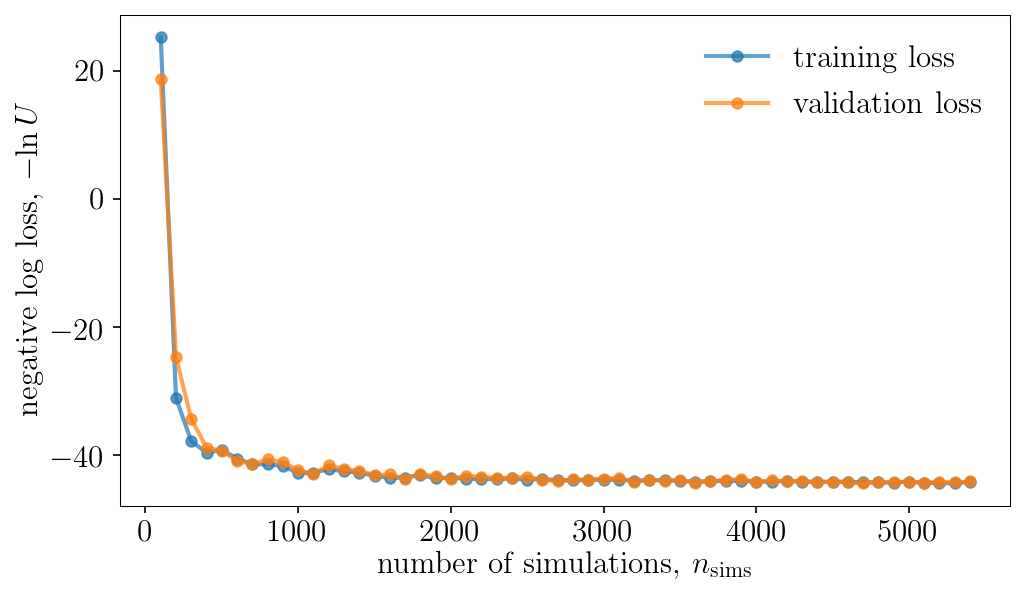

Population 54/150
Sampling proposal density...
Done.


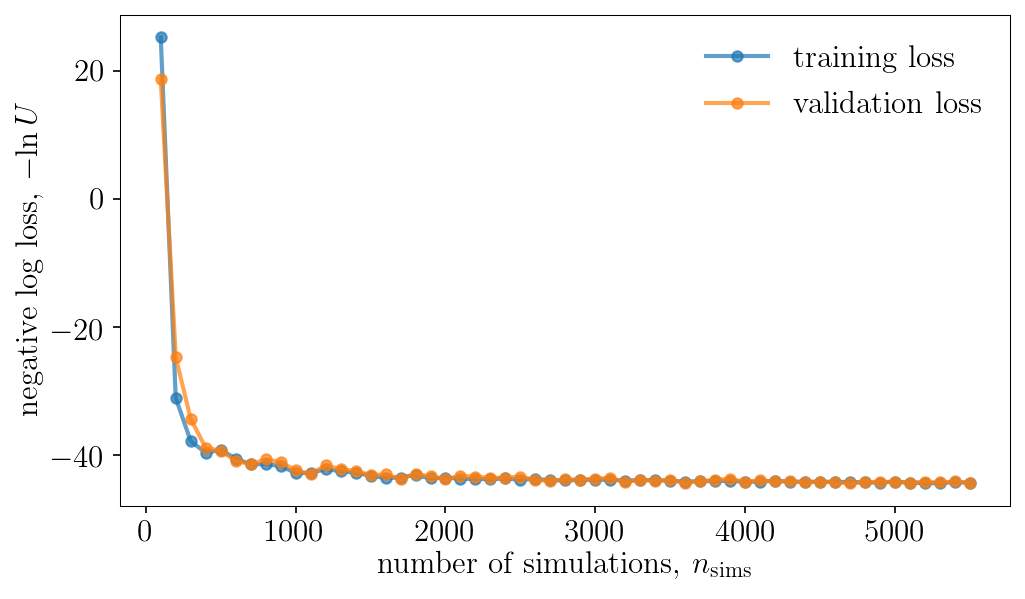

Population 55/150
Sampling proposal density...
Done.


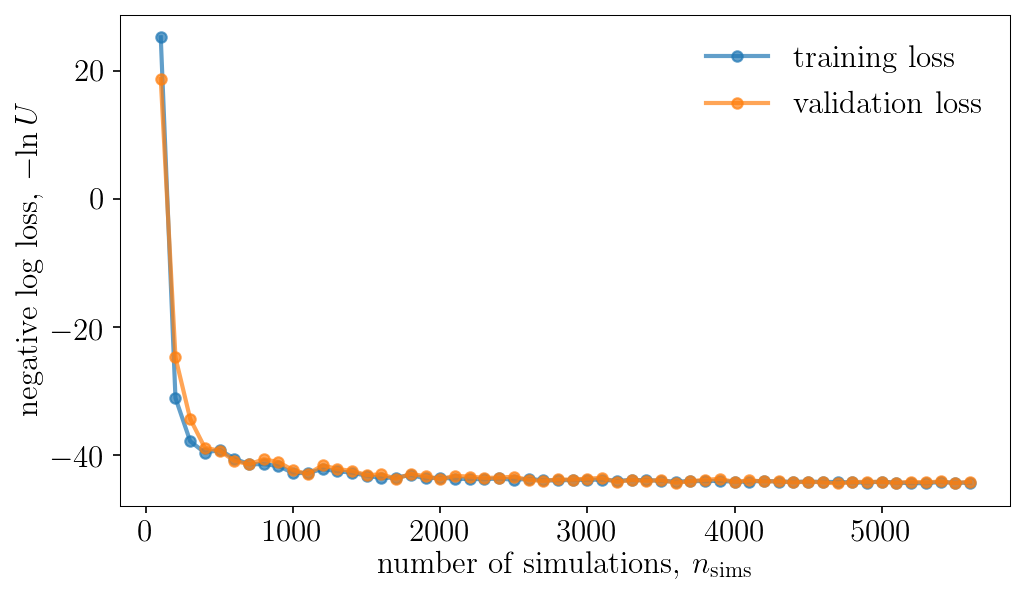

Population 56/150
Sampling proposal density...
Done.


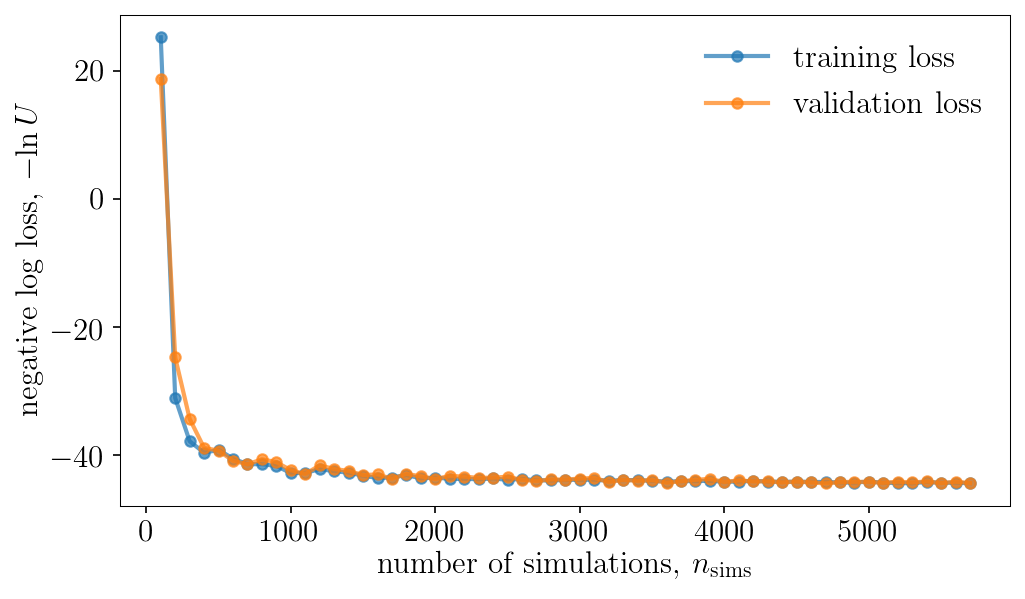

Population 57/150
Sampling proposal density...
Done.


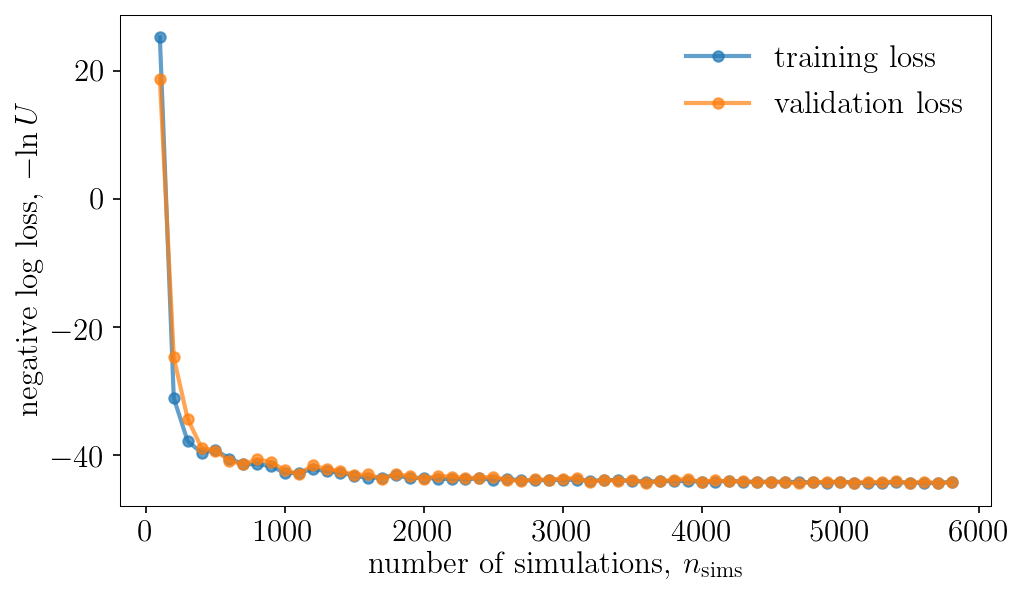

Population 58/150
Sampling proposal density...
Done.


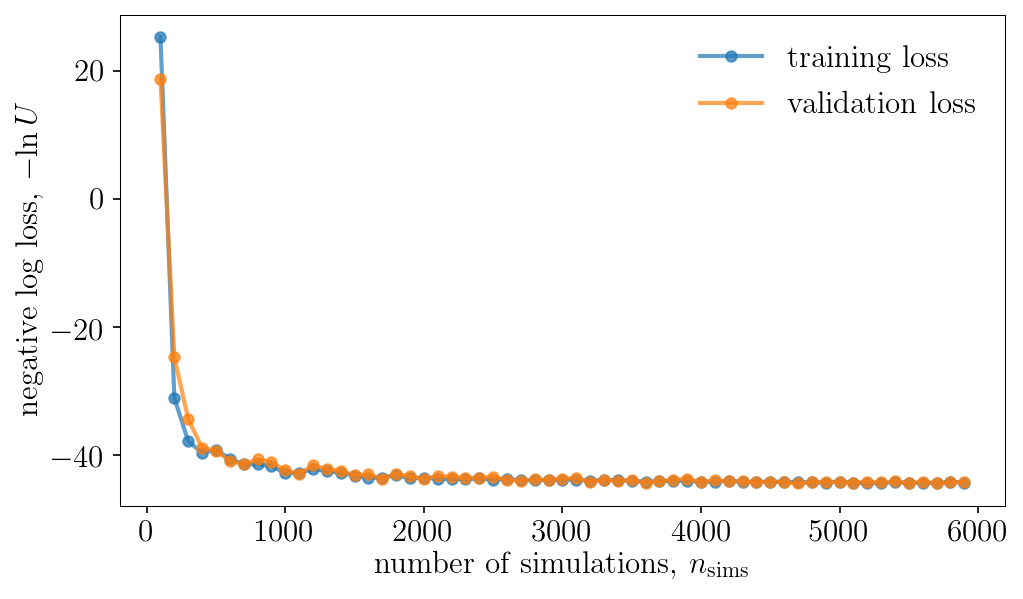

Population 59/150
Sampling proposal density...
Done.


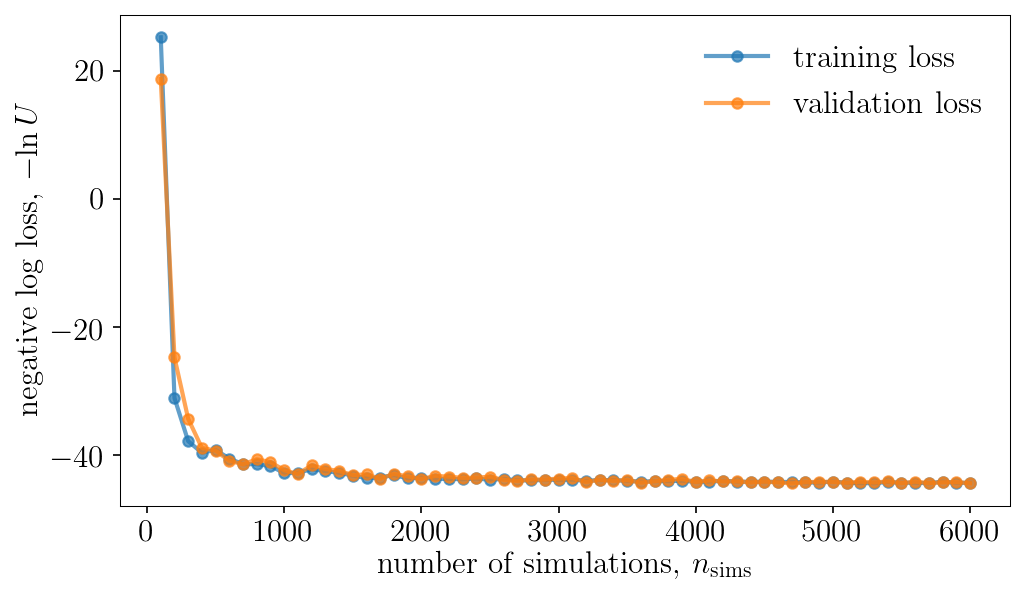

Population 60/150
Sampling proposal density...
Done.


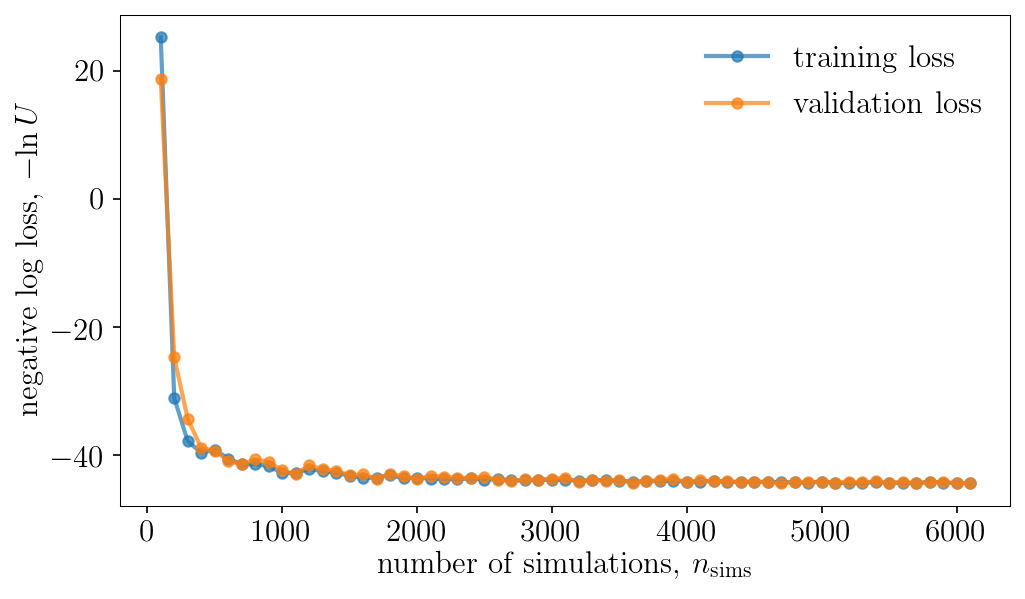

Population 61/150
Sampling proposal density...
Done.


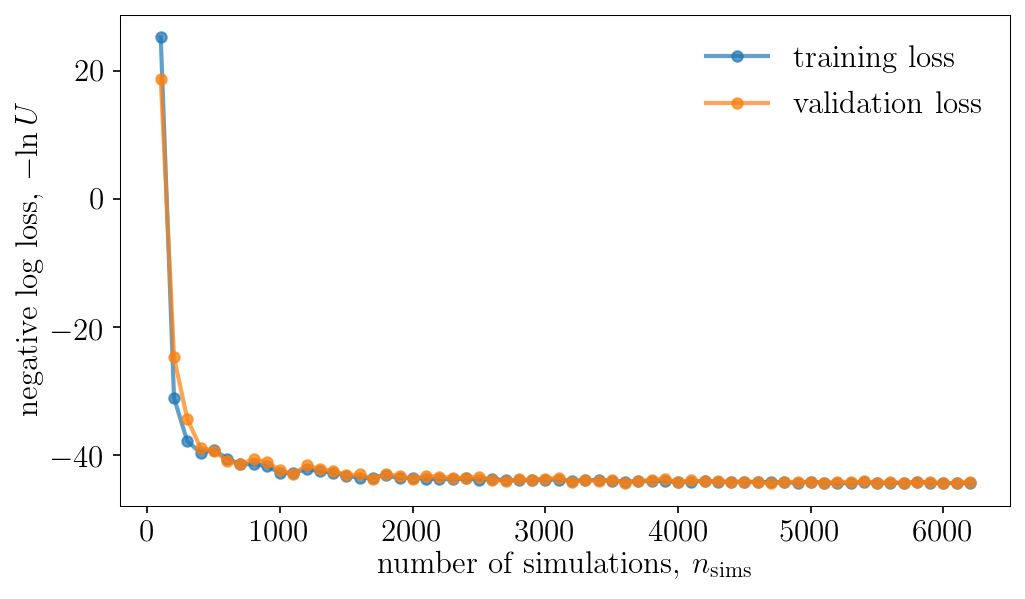

Population 62/150
Sampling proposal density...
Done.


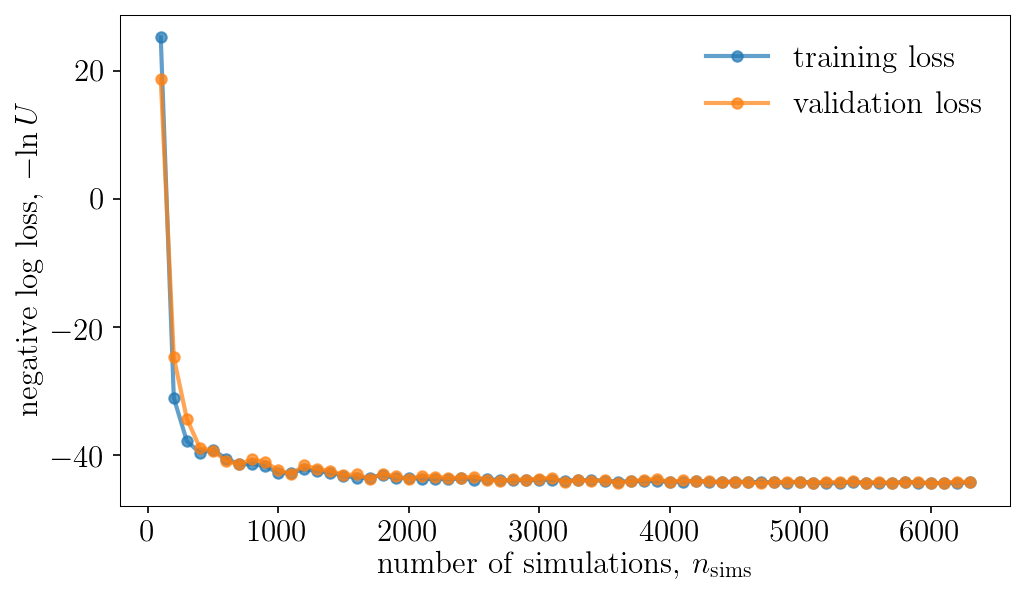

Population 63/150
Sampling proposal density...
Done.


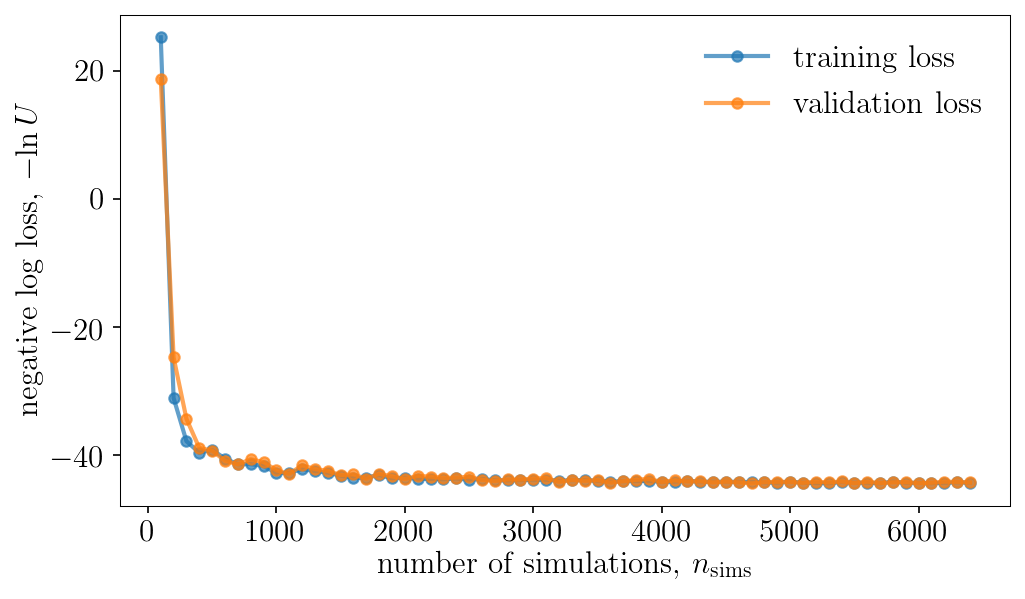

Population 64/150
Sampling proposal density...
Done.


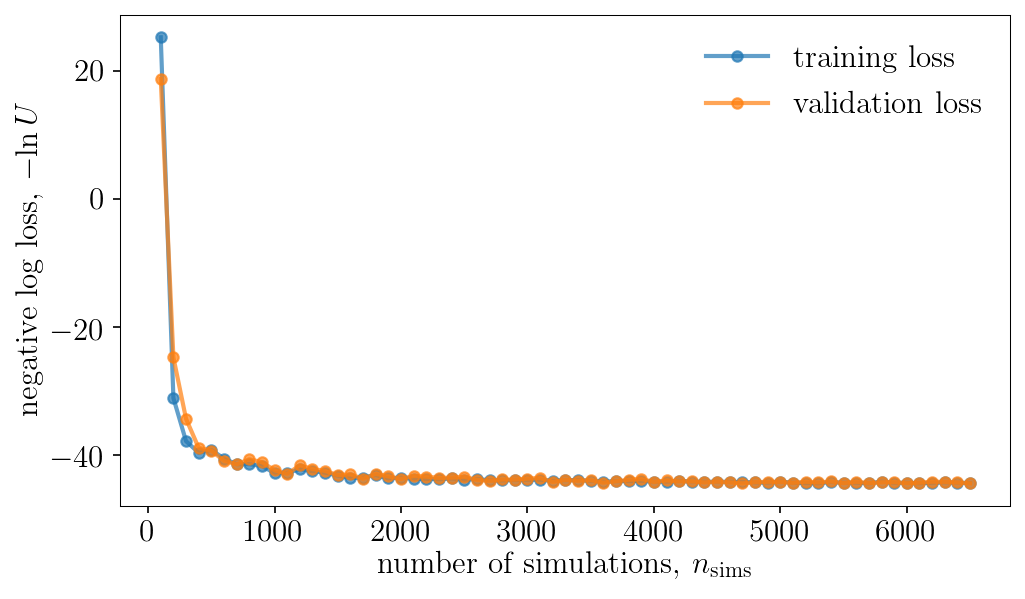

Population 65/150
Sampling proposal density...
Done.


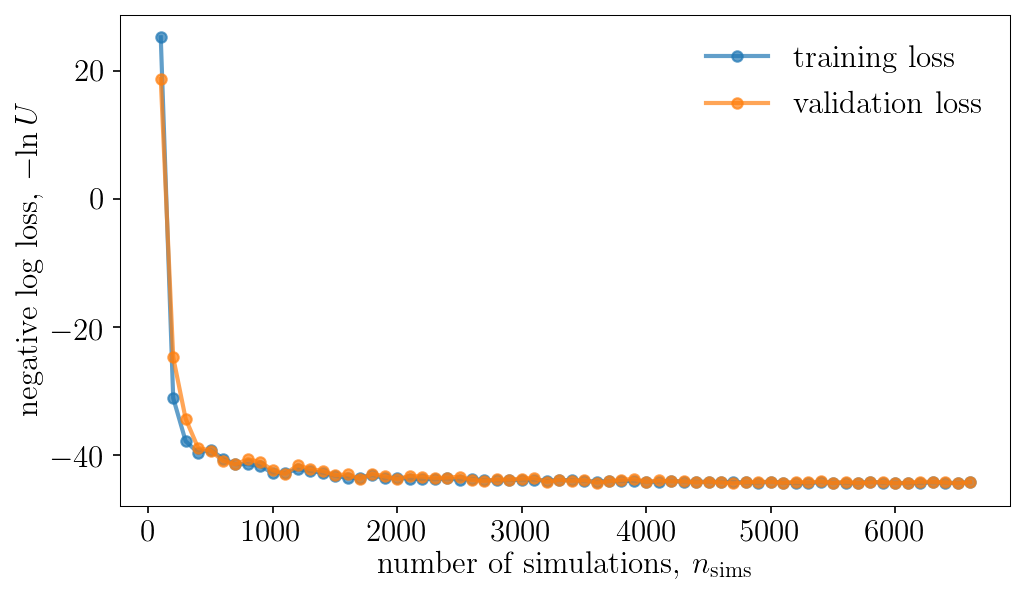

Population 66/150
Sampling proposal density...
Done.


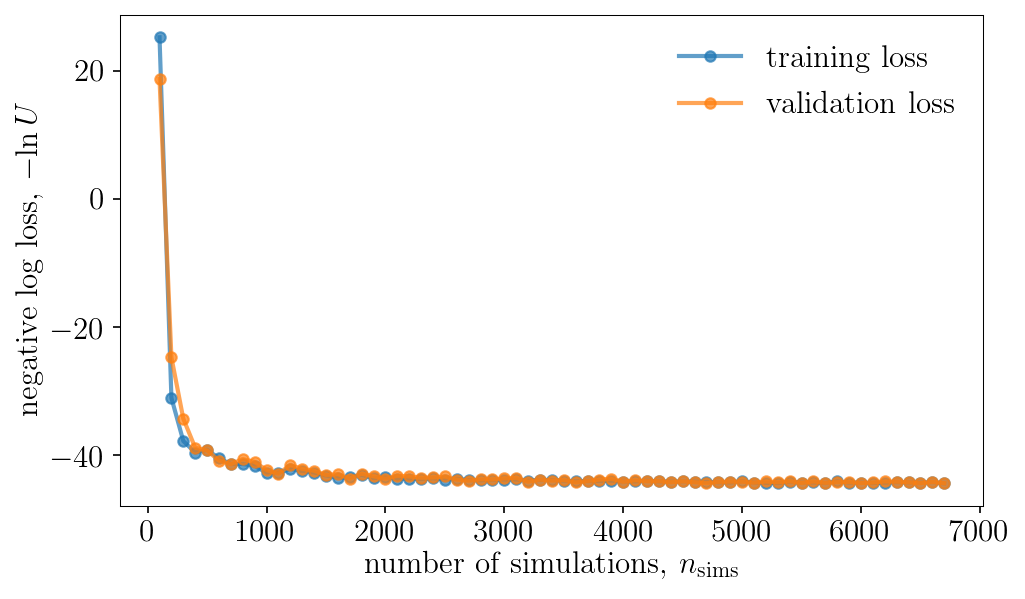

Population 67/150
Sampling proposal density...
Done.


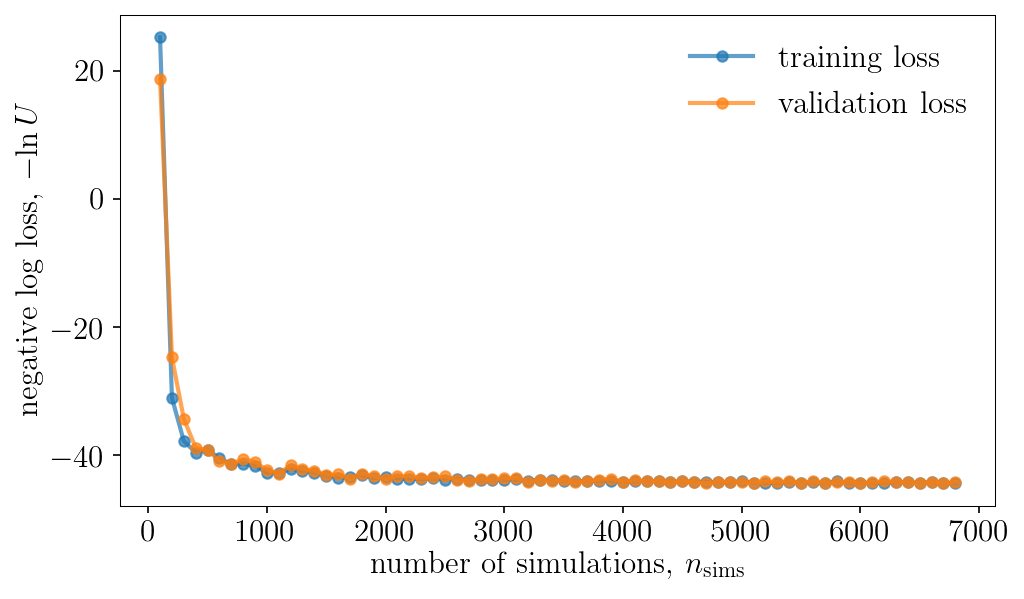

Population 68/150
Sampling proposal density...
Done.


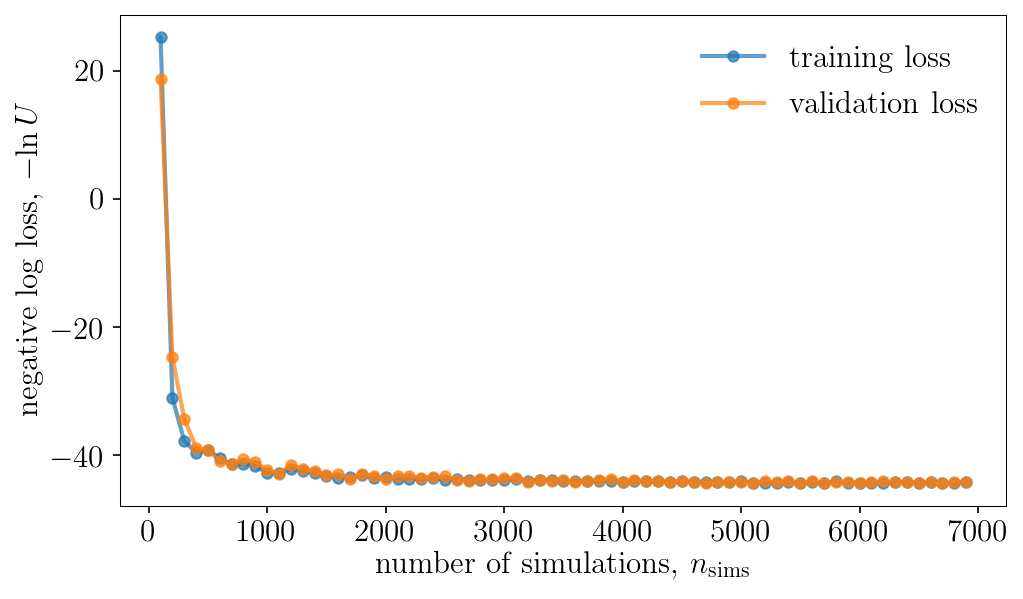

Population 69/150
Sampling proposal density...
Done.


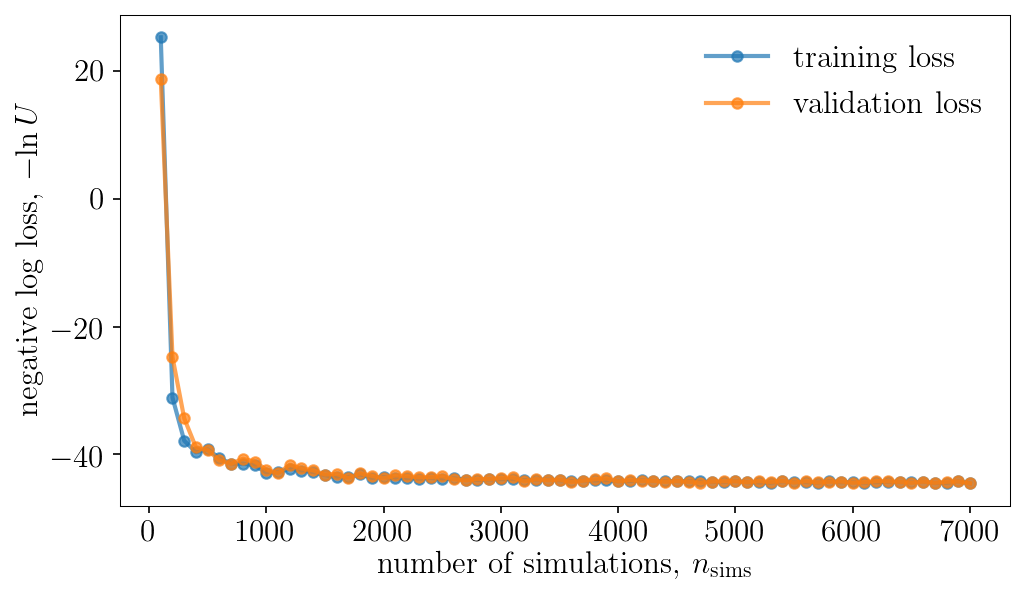

Population 70/150
Sampling proposal density...
Done.


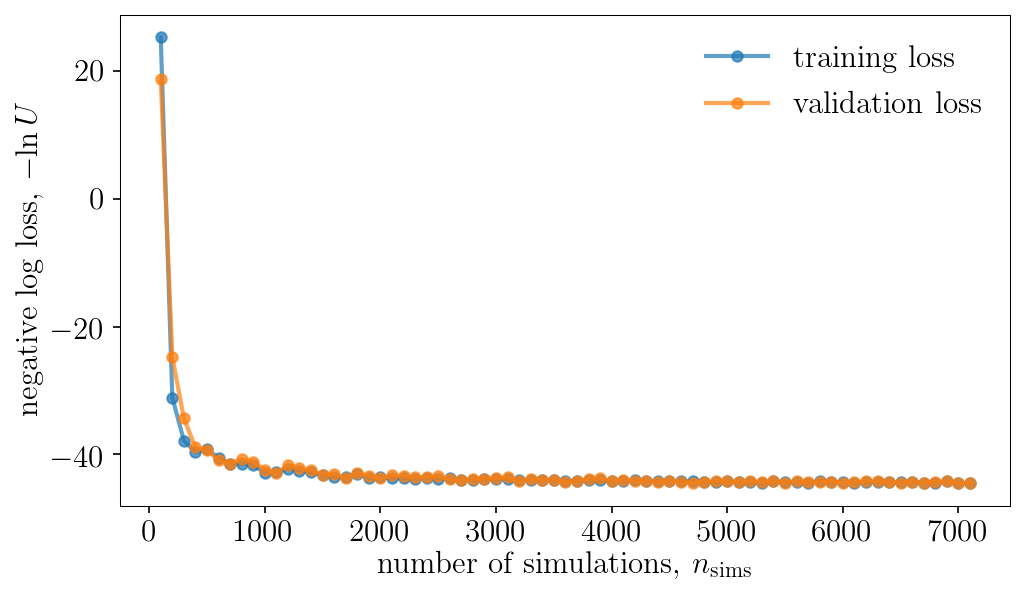

Population 71/150
Sampling proposal density...
Done.


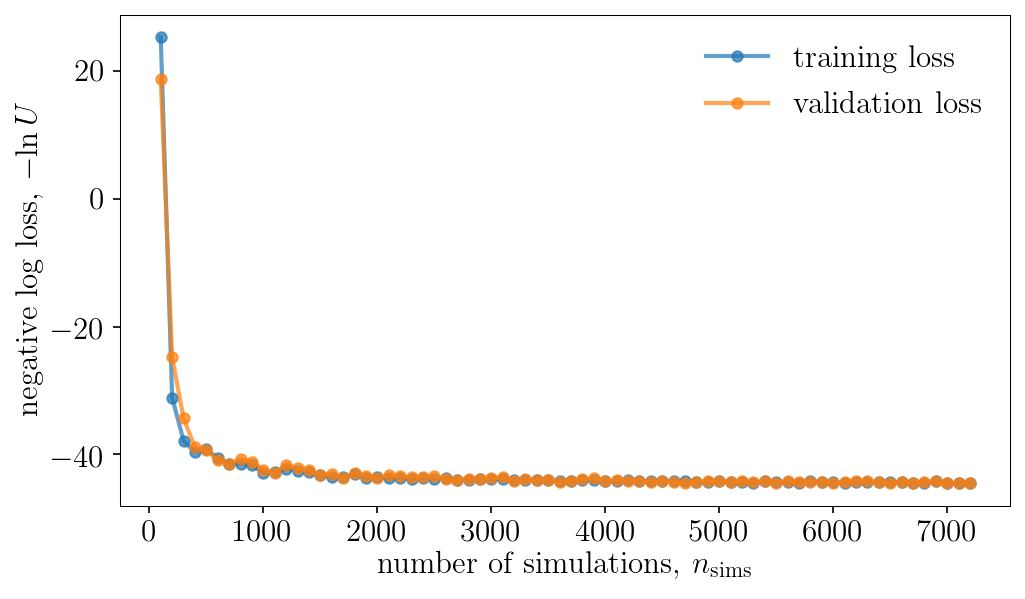

Population 72/150
Sampling proposal density...
Done.


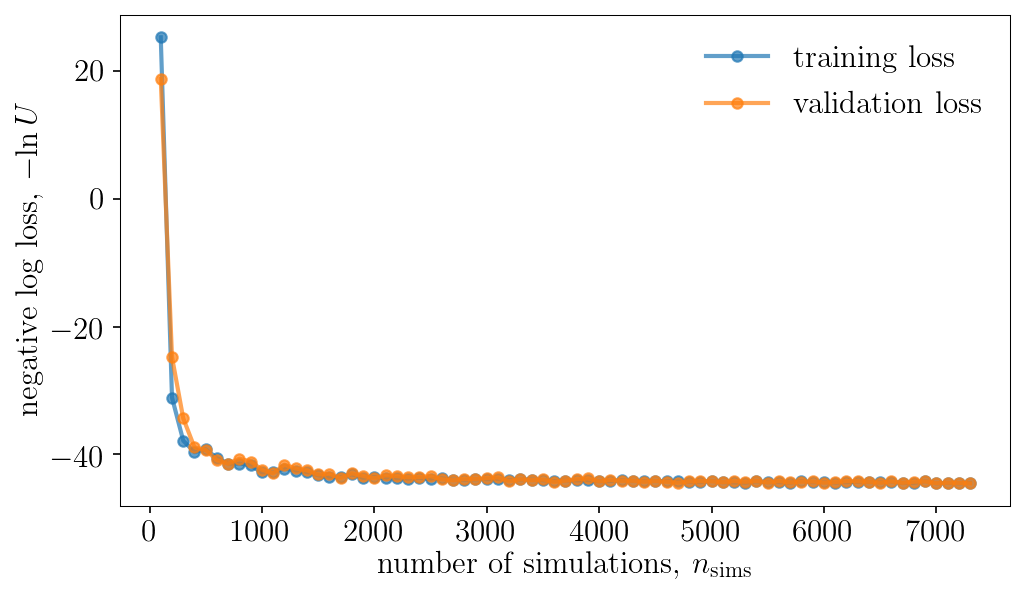

Population 73/150
Sampling proposal density...
Done.


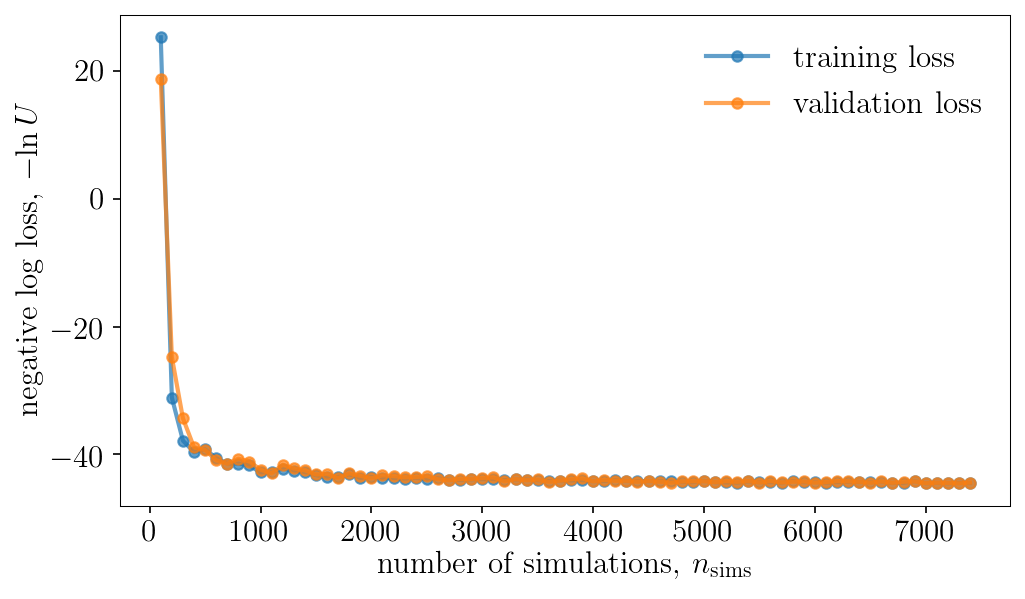

Population 74/150
Sampling proposal density...
Done.


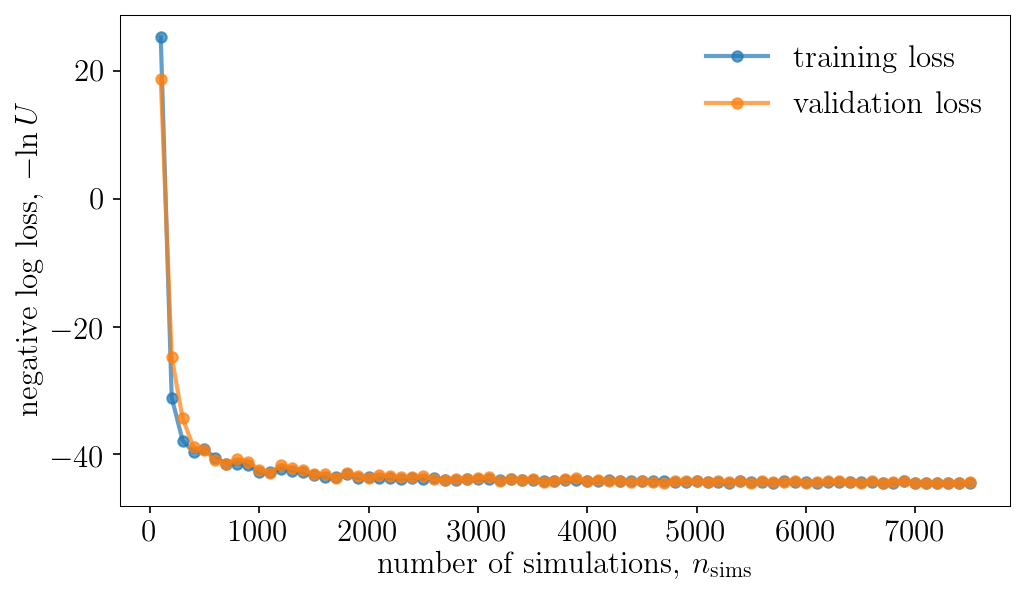

Population 75/150
Sampling proposal density...
Done.


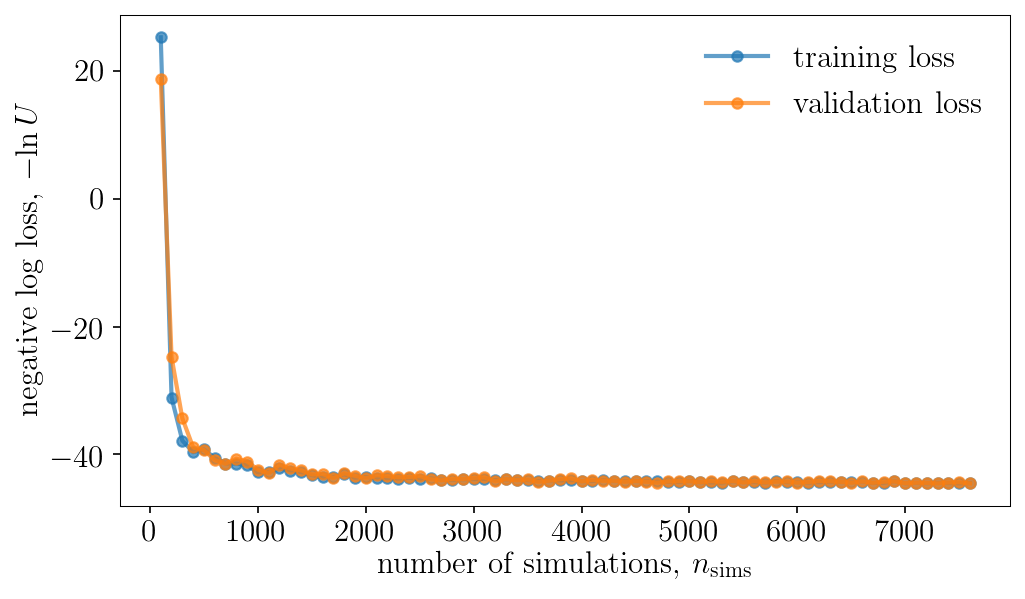

Population 76/150
Sampling proposal density...
Done.


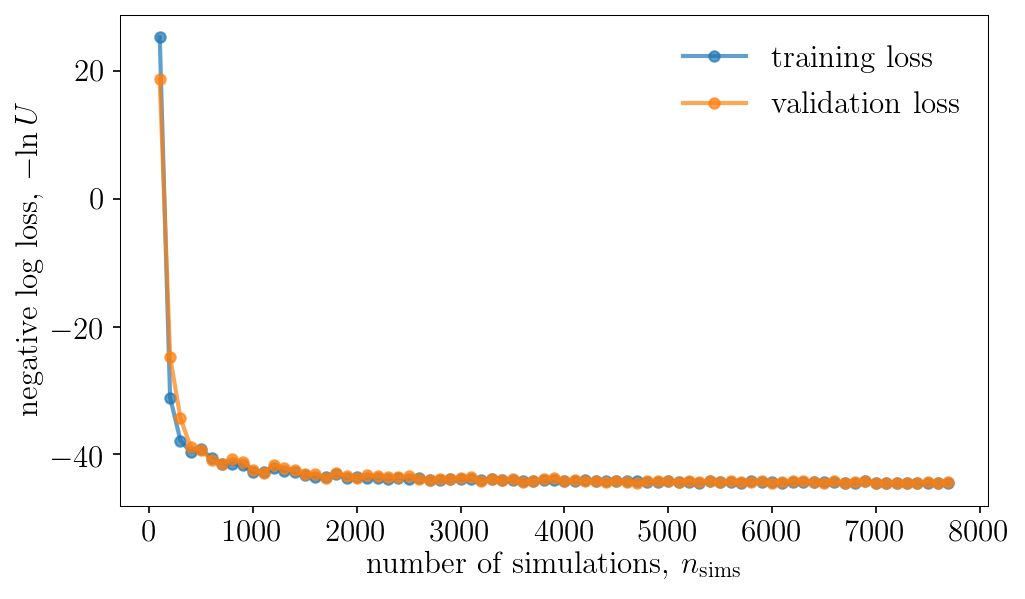

Population 77/150
Sampling proposal density...
Done.


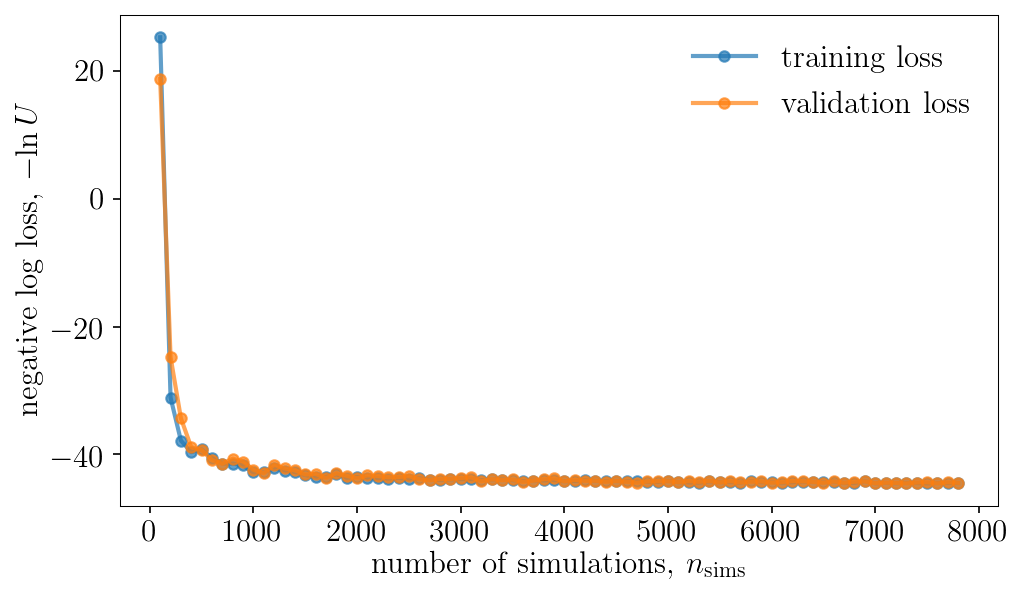

Population 78/150
Sampling proposal density...
Done.


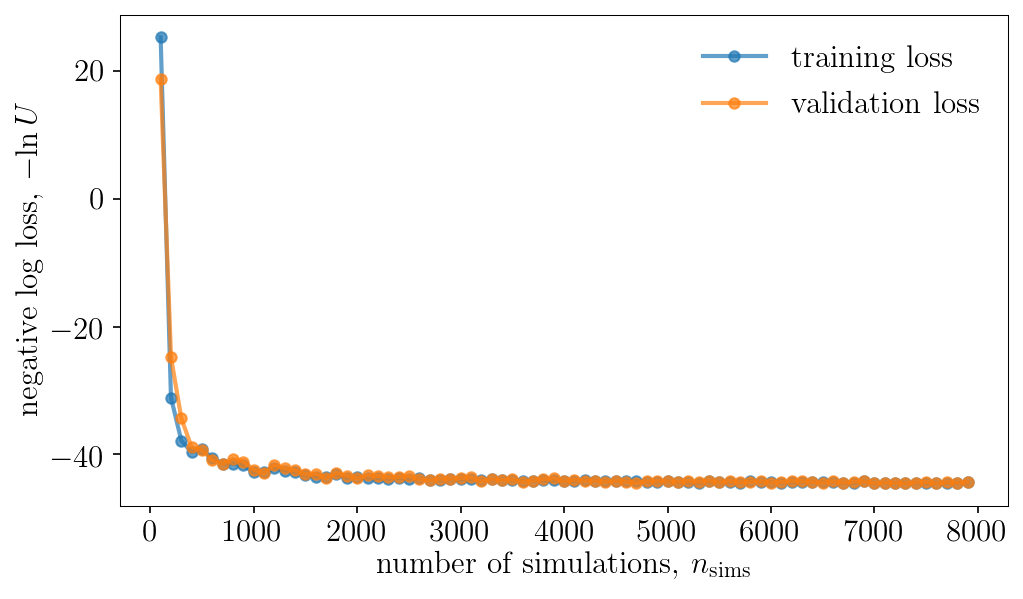

Population 79/150
Sampling proposal density...
Done.


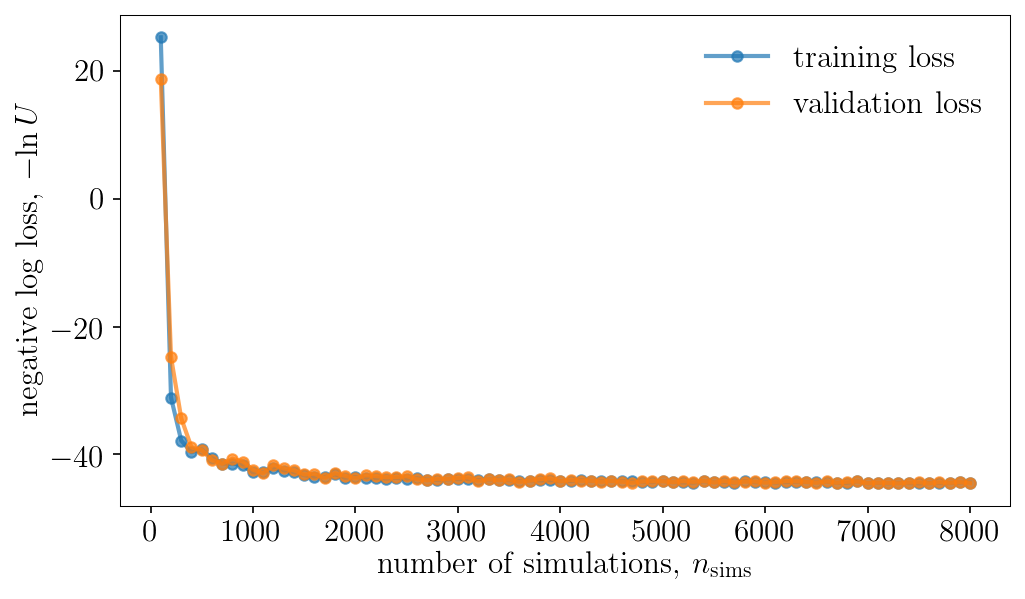

Population 80/150
Sampling proposal density...
Done.


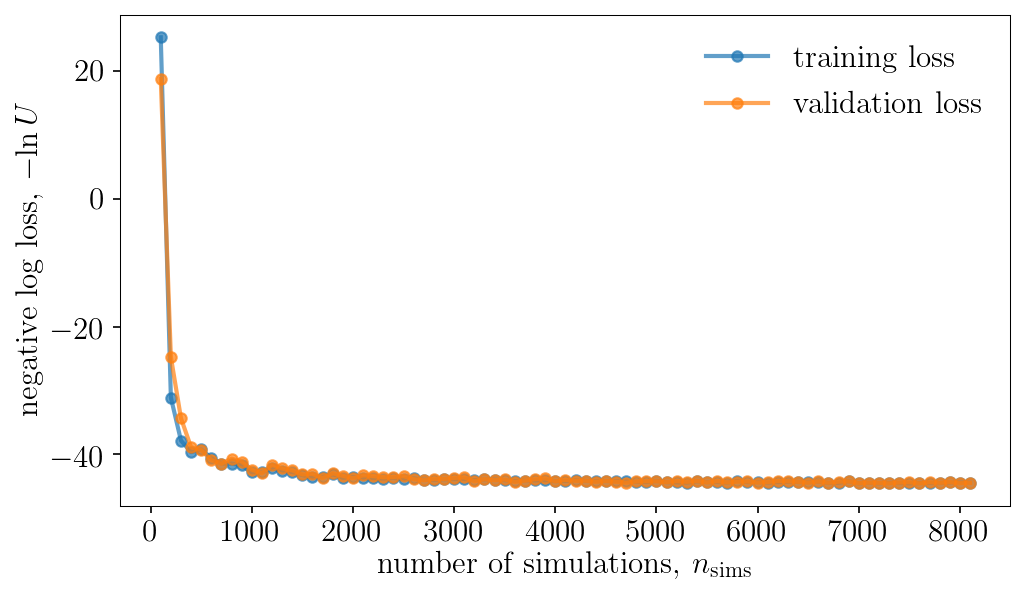

Population 81/150
Sampling proposal density...
Done.


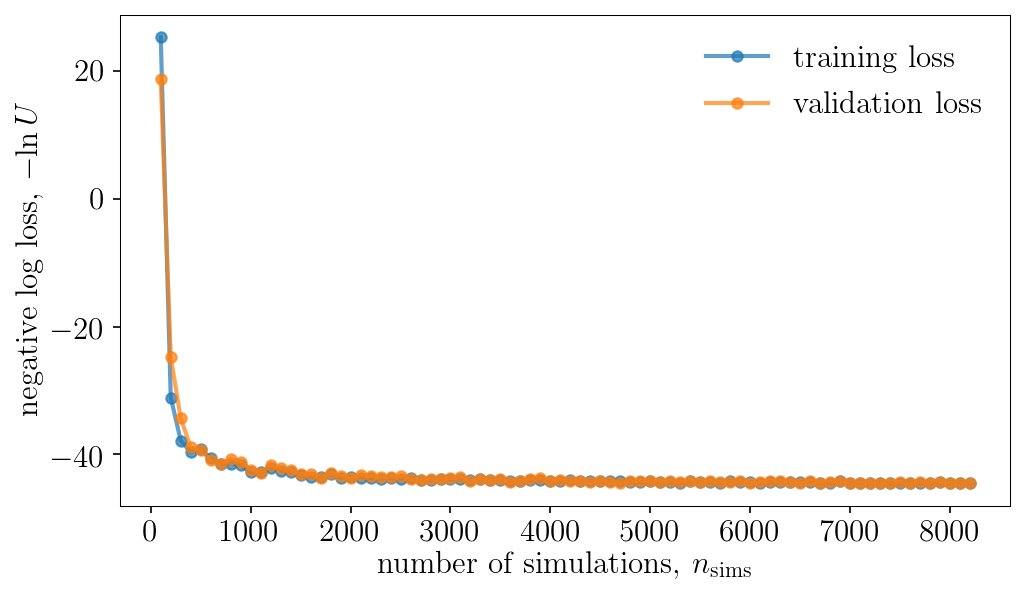

Population 82/150
Sampling proposal density...
Done.


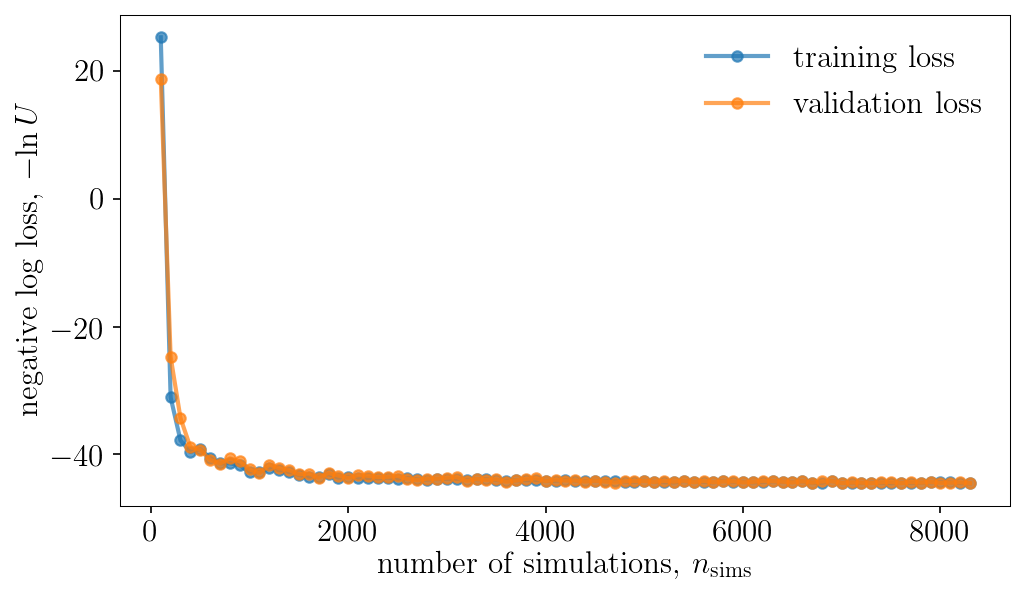

Population 83/150
Sampling proposal density...
Done.


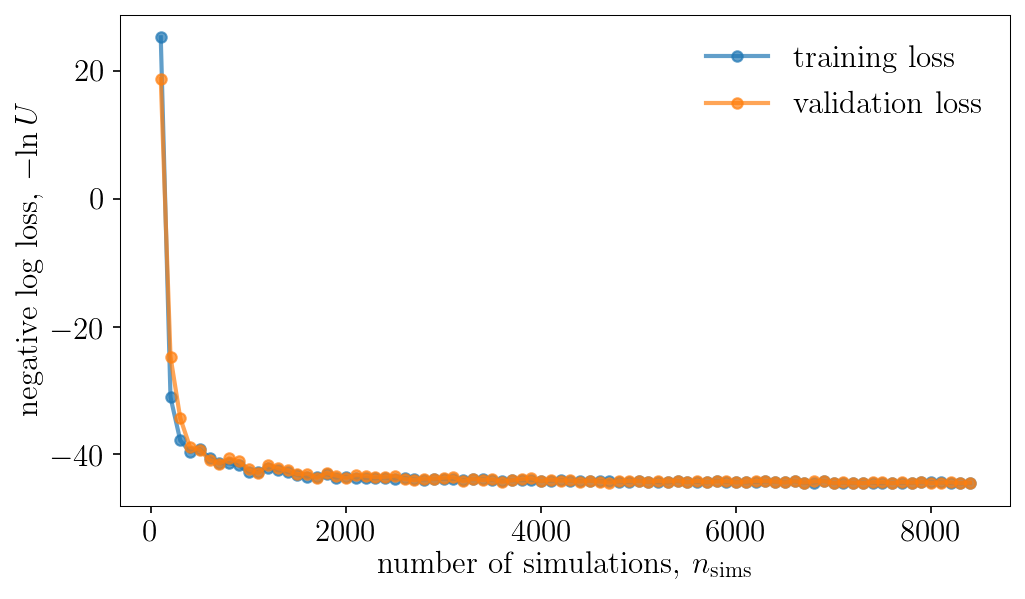

Population 84/150
Sampling proposal density...
Done.


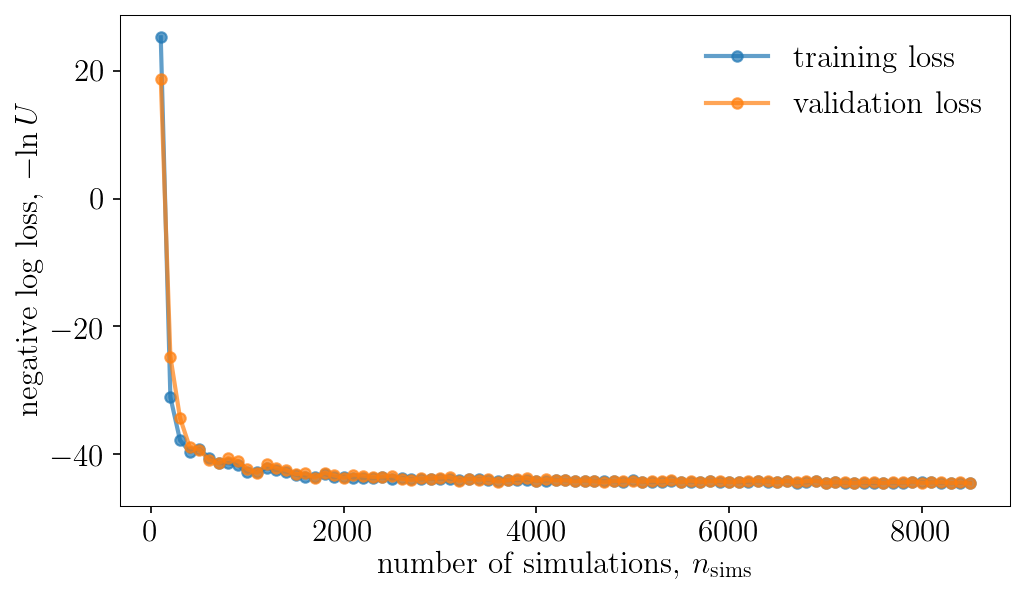

Population 85/150
Sampling proposal density...
Done.


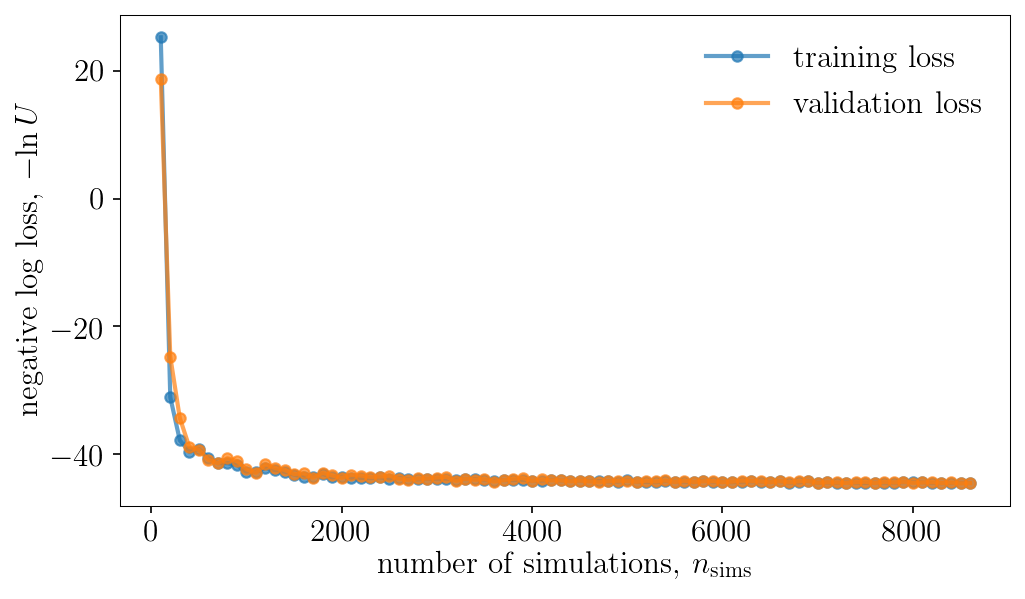

Population 86/150
Sampling proposal density...
Done.


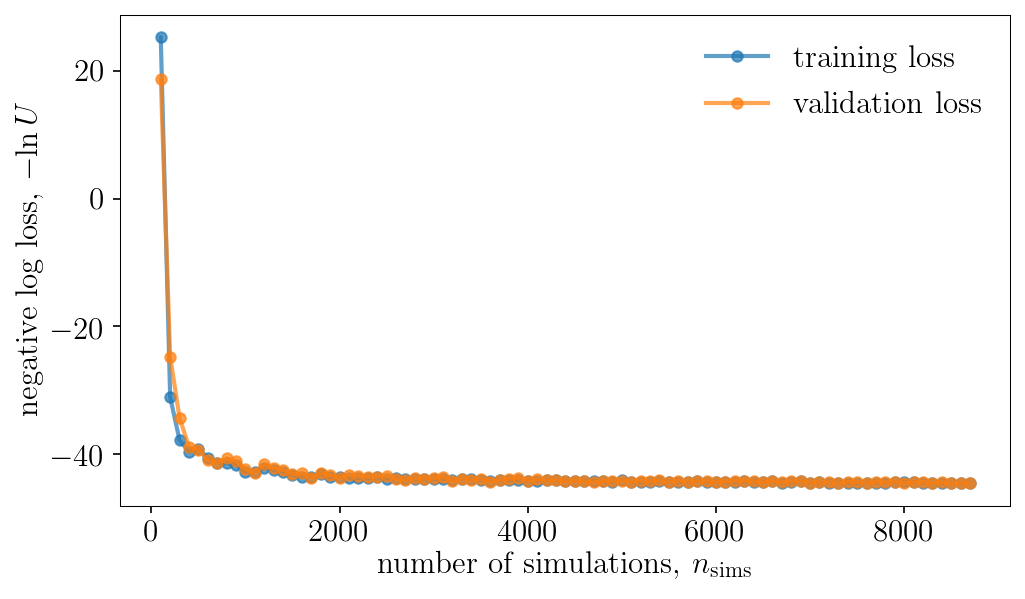

Population 87/150
Sampling proposal density...
Done.


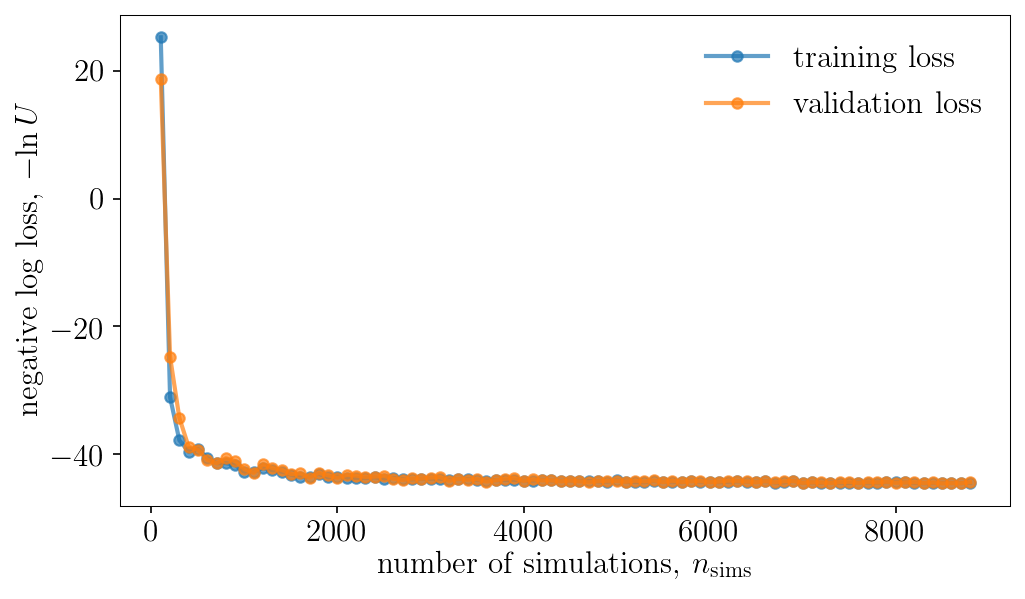

Population 88/150
Sampling proposal density...
Done.


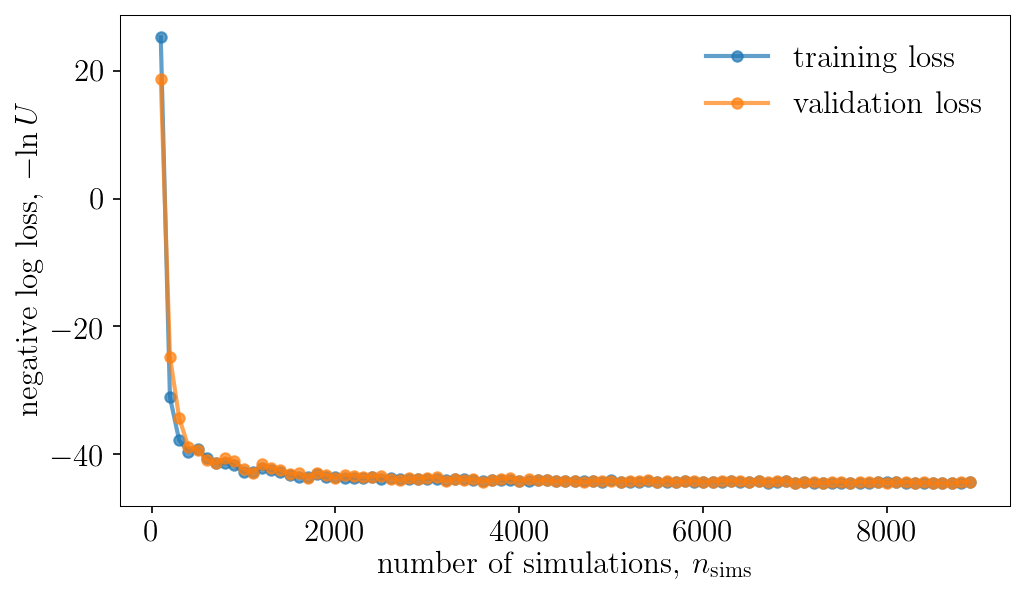

Population 89/150
Sampling proposal density...
Done.


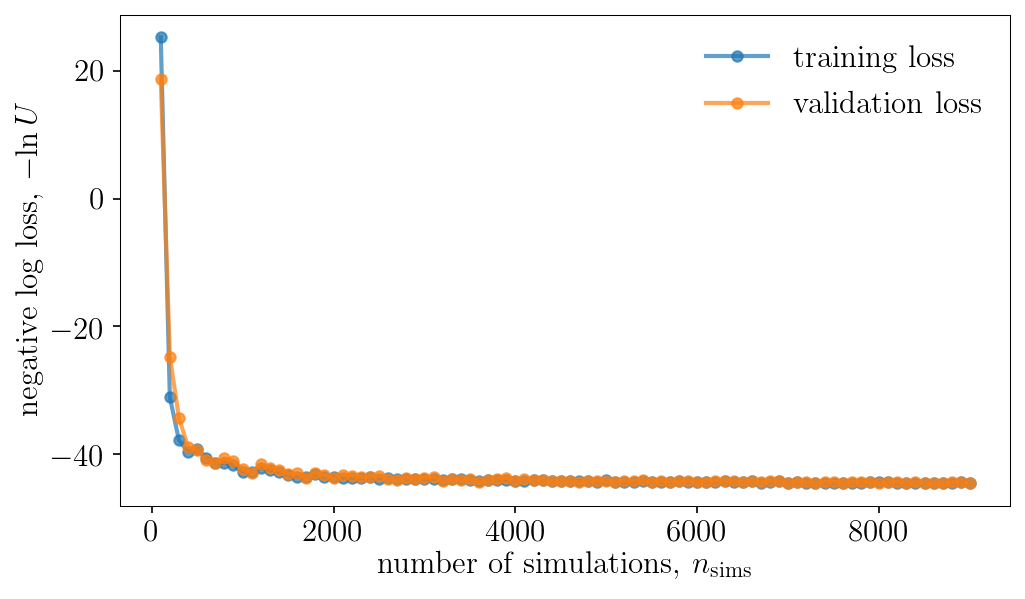

Population 90/150
Sampling proposal density...
Done.


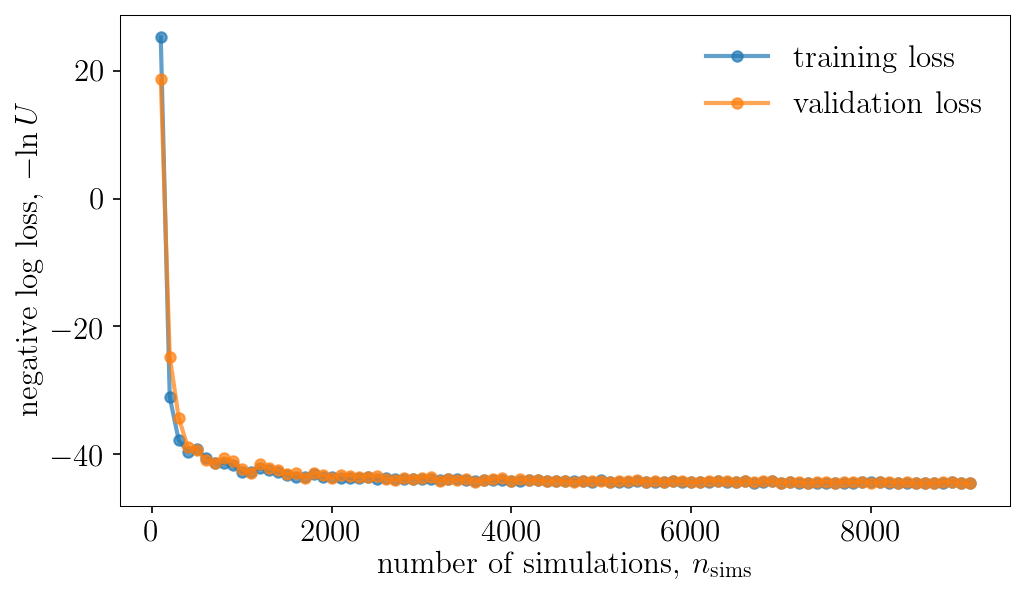

Population 91/150
Sampling proposal density...
Done.


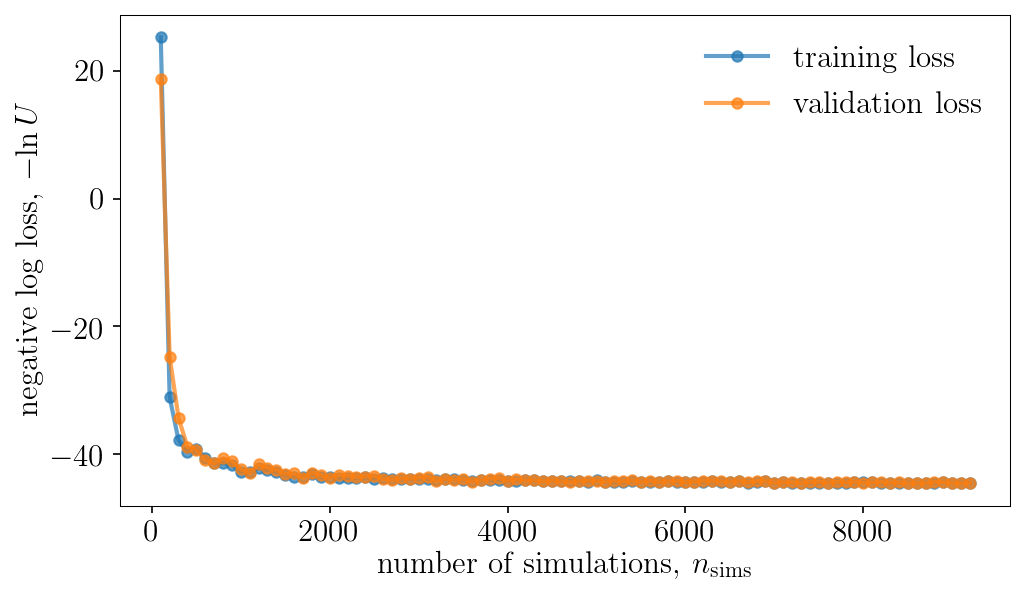

Population 92/150
Sampling proposal density...
Done.


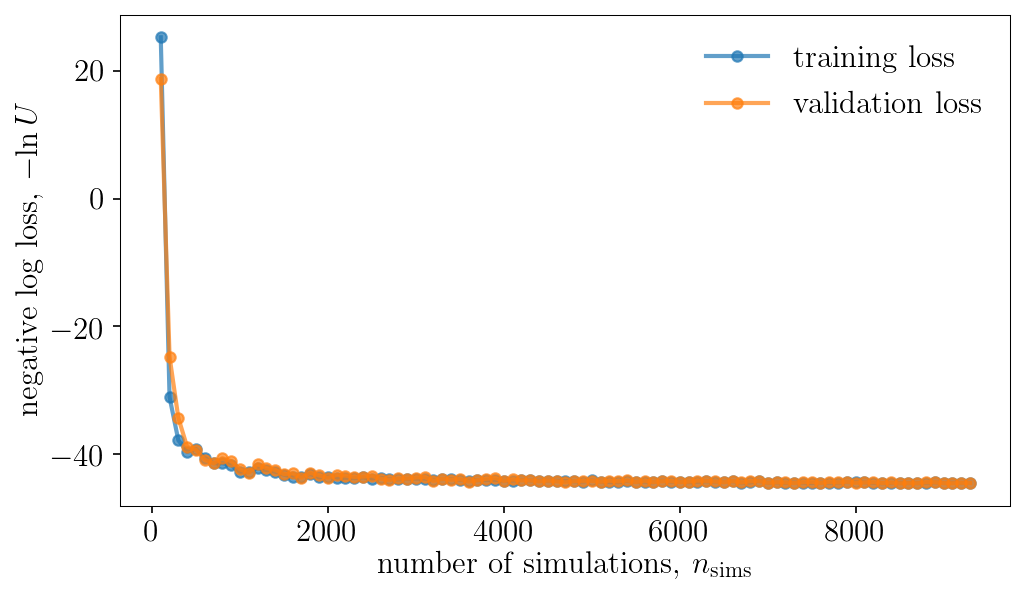

Population 93/150
Sampling proposal density...
Done.


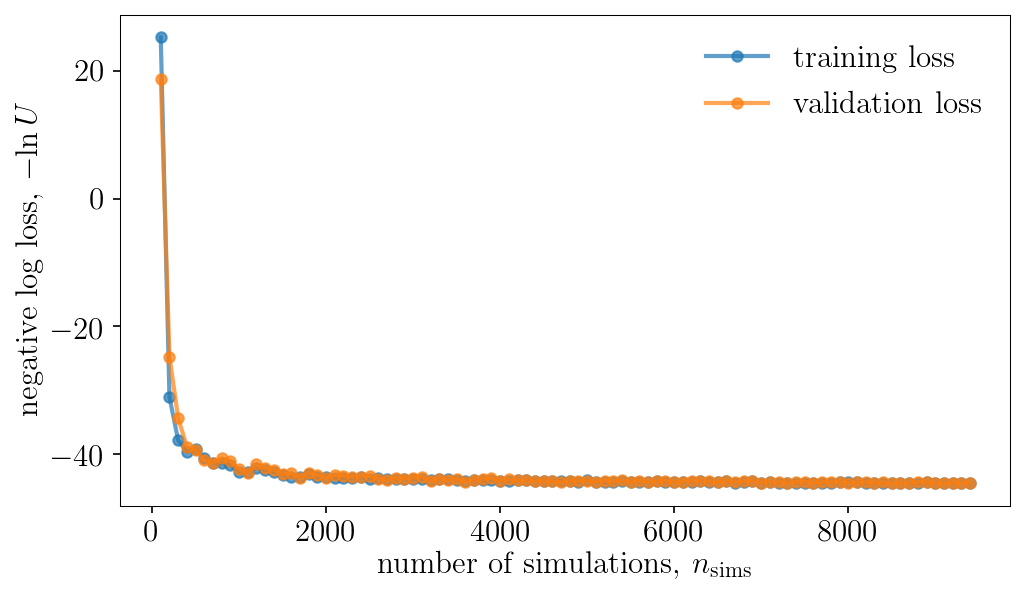

Population 94/150
Sampling proposal density...
Done.


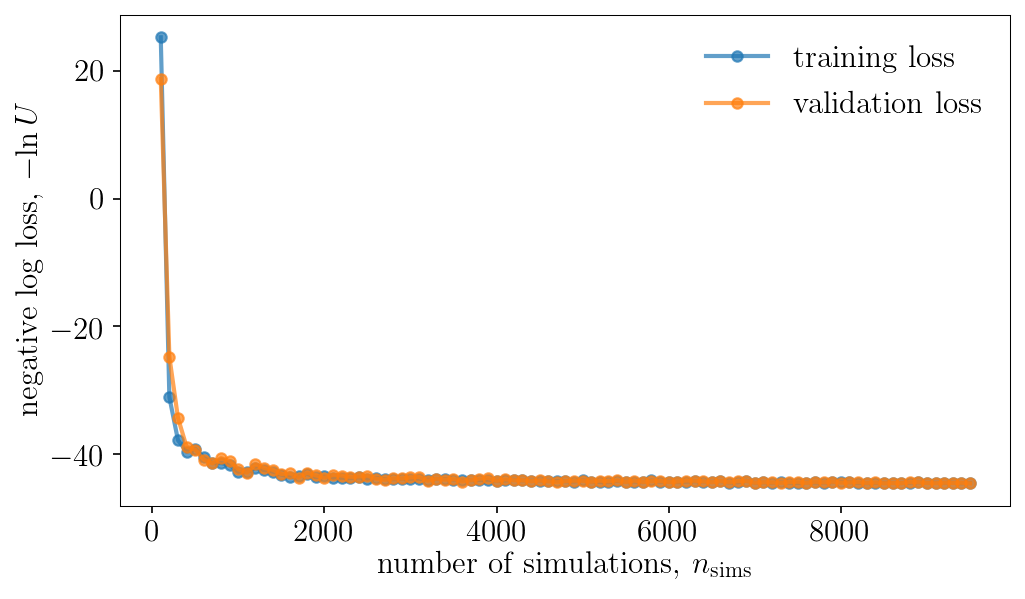

Population 95/150
Sampling proposal density...
Done.


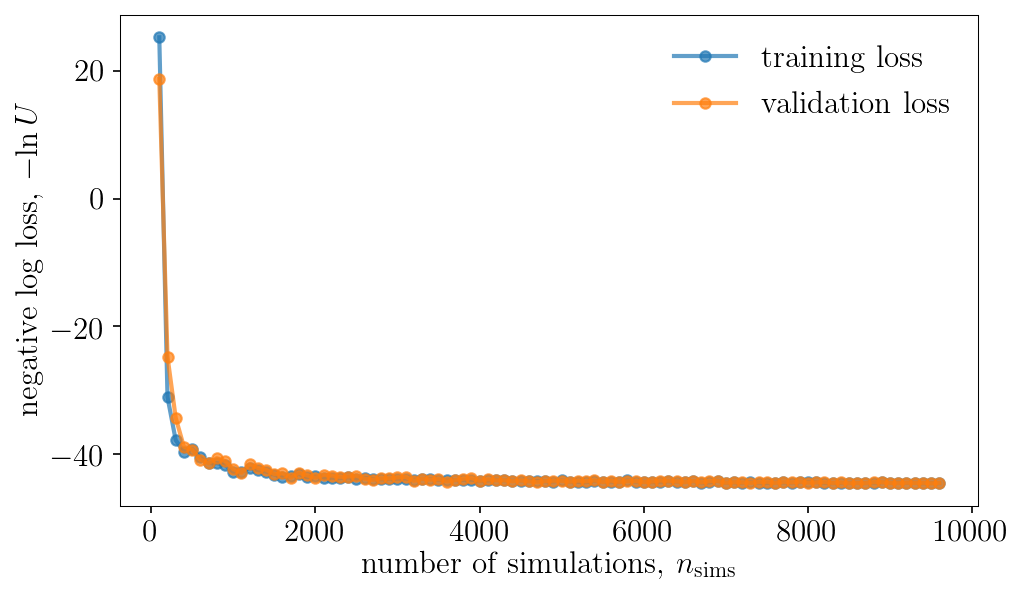

Population 96/150
Sampling proposal density...
Done.


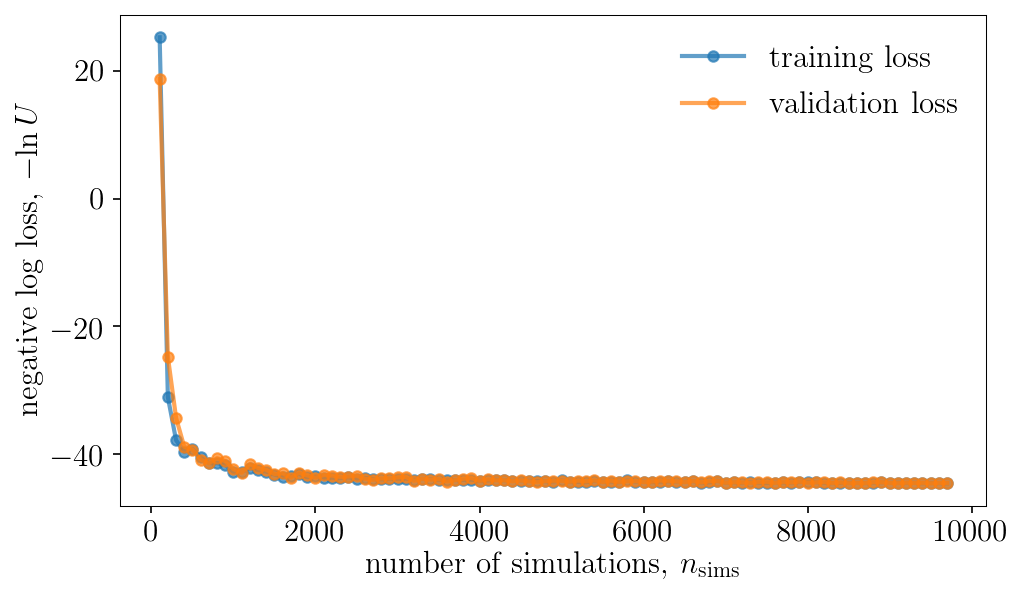

Population 97/150
Sampling proposal density...
Done.


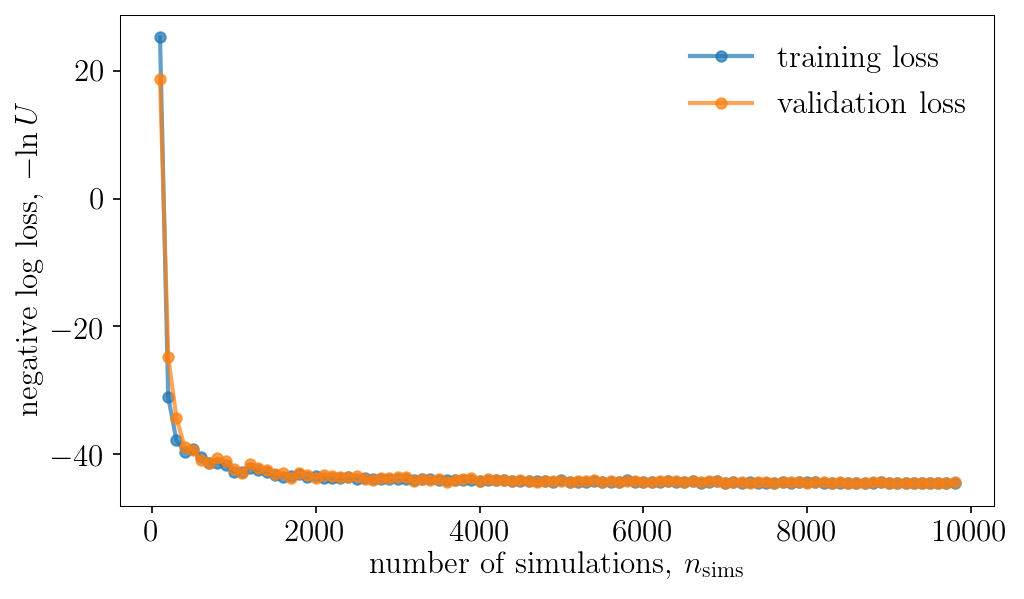

Population 98/150
Sampling proposal density...
Done.


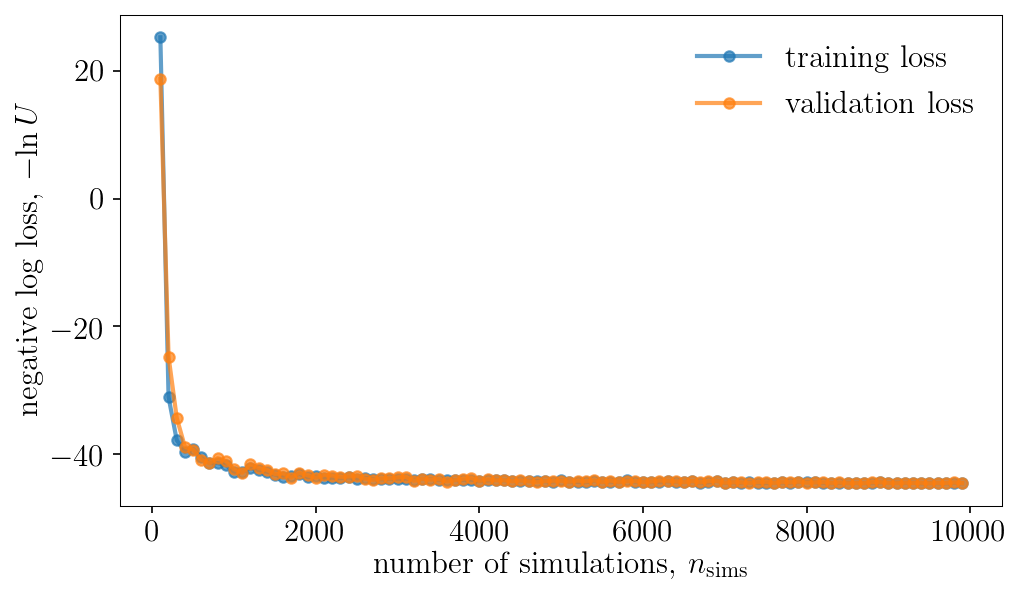

Population 99/150
Sampling proposal density...
Done.


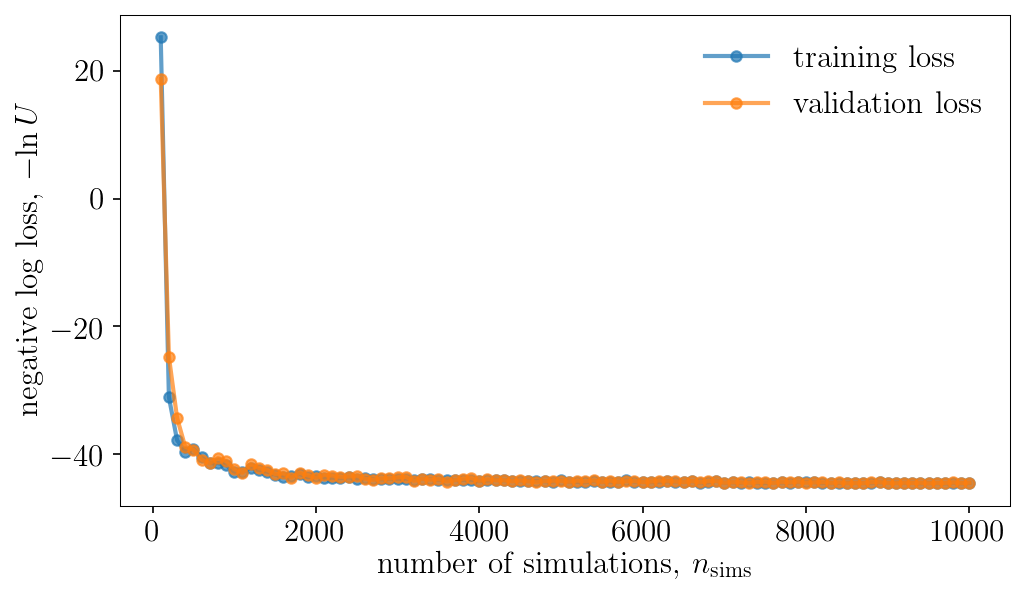

Population 100/150
Sampling proposal density...
Done.


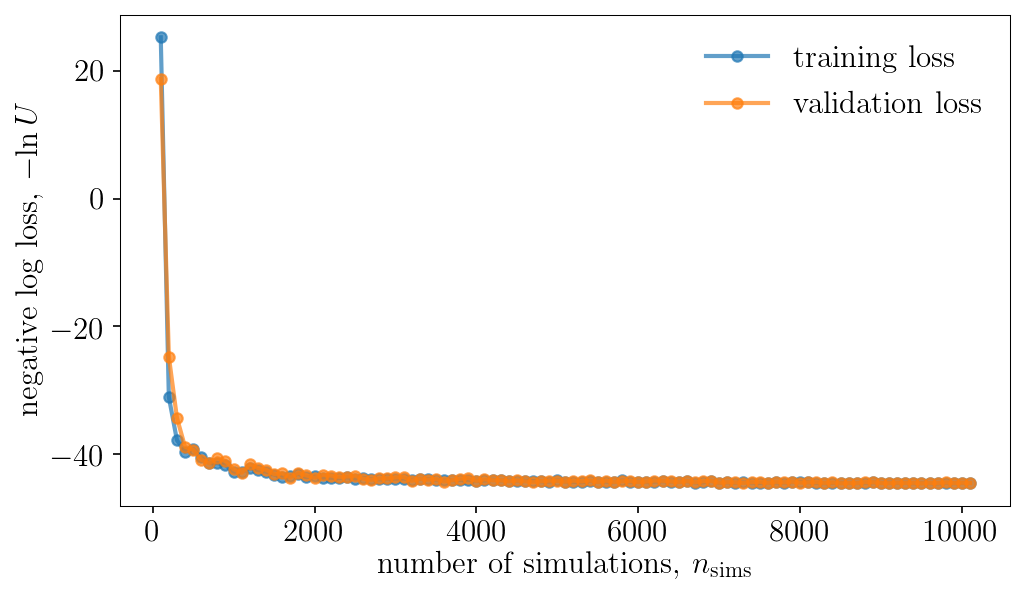

Population 101/150
Sampling proposal density...
Done.


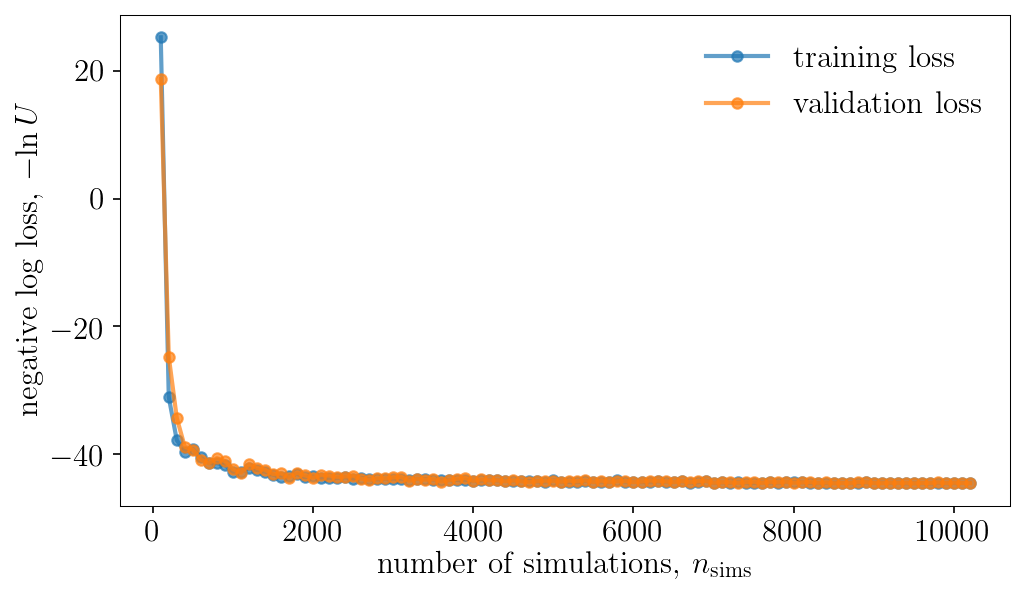

Population 102/150
Sampling proposal density...
Done.


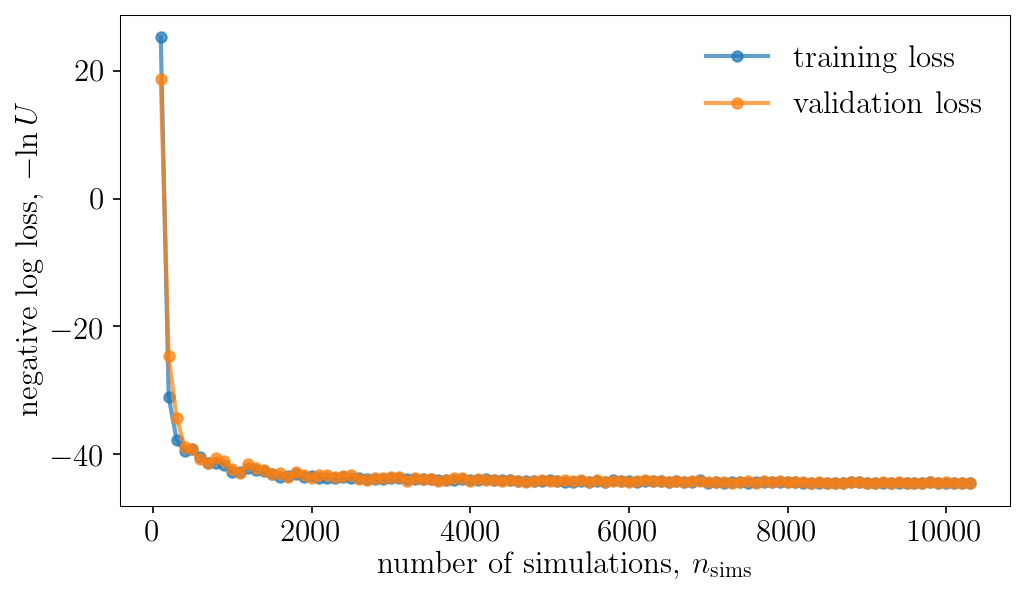

Population 103/150
Sampling proposal density...
Done.


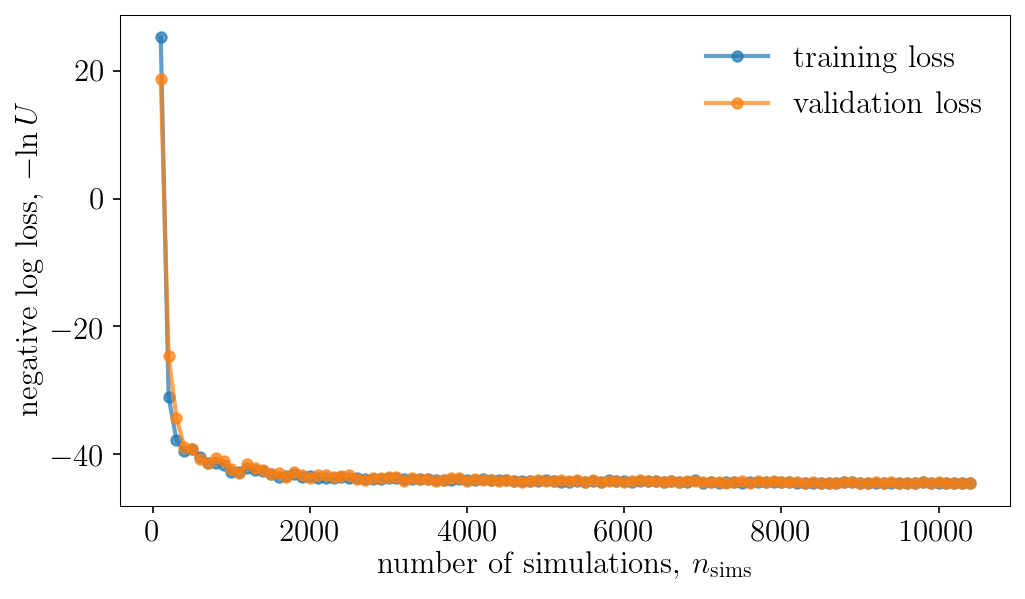

Population 104/150
Sampling proposal density...
Done.


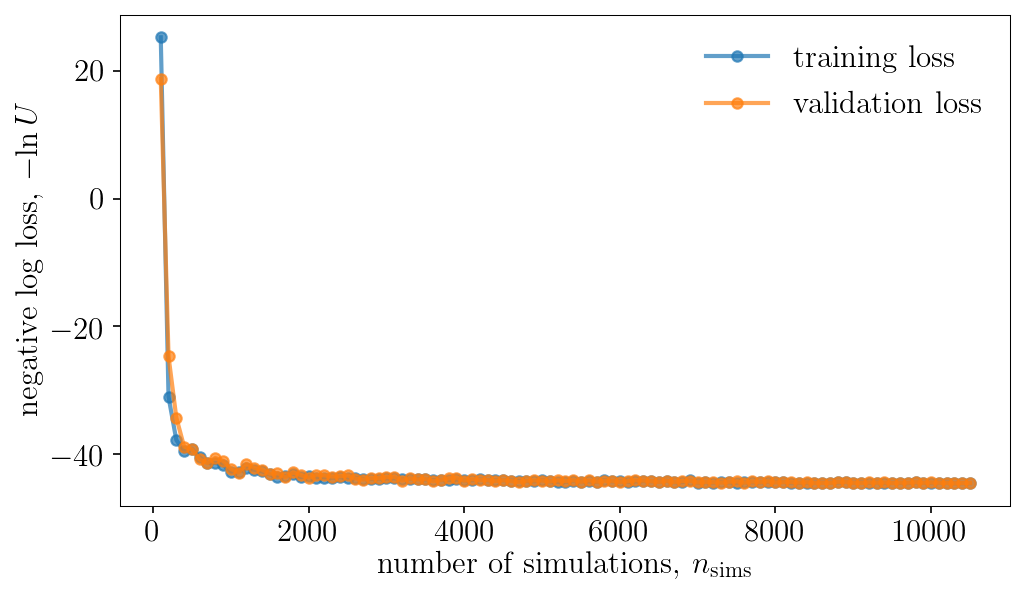

Population 105/150
Sampling proposal density...
Done.


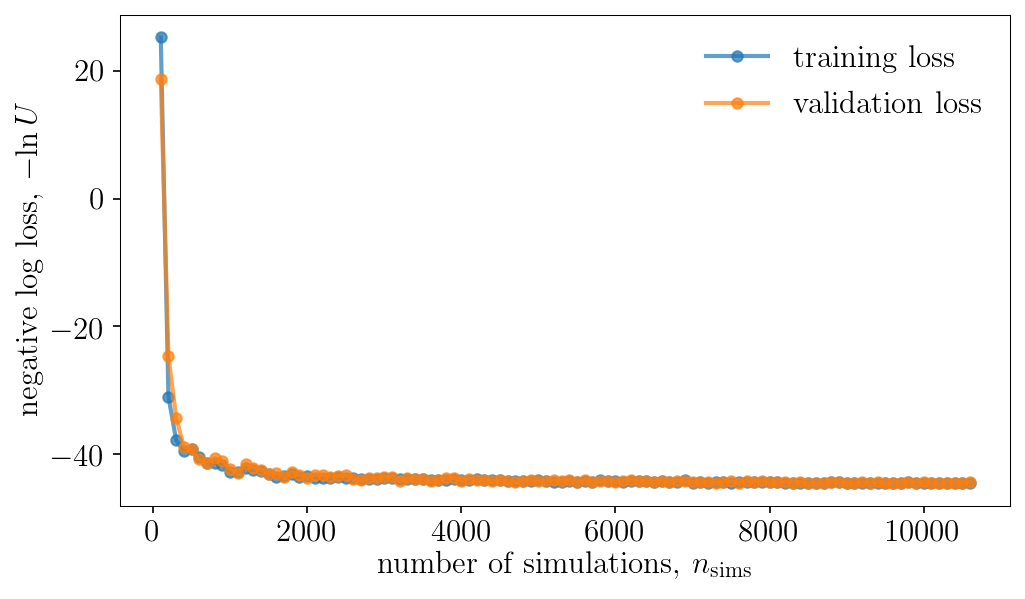

Population 106/150
Sampling proposal density...
Done.


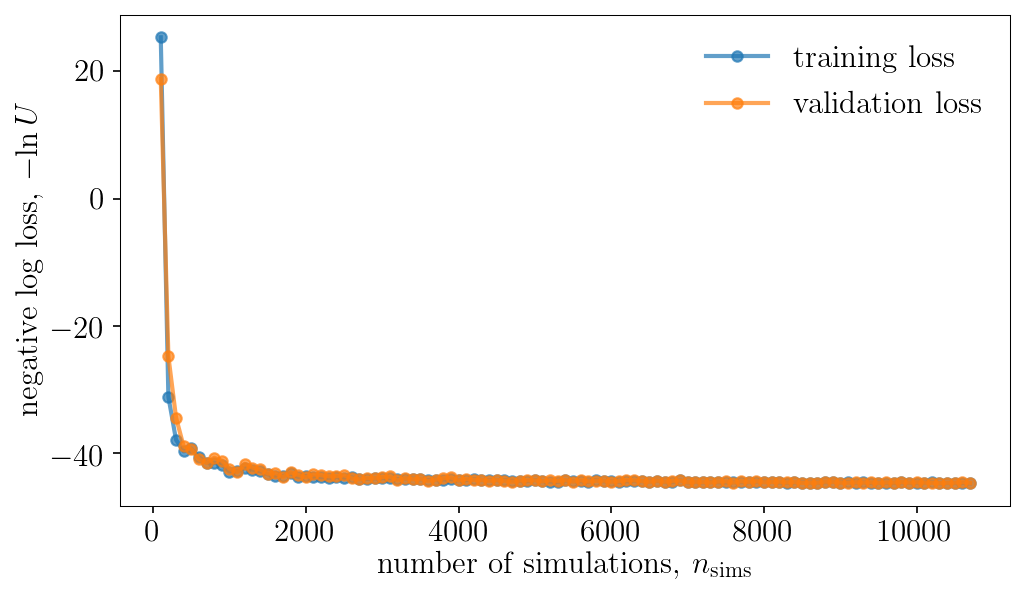

Population 107/150
Sampling proposal density...
Done.


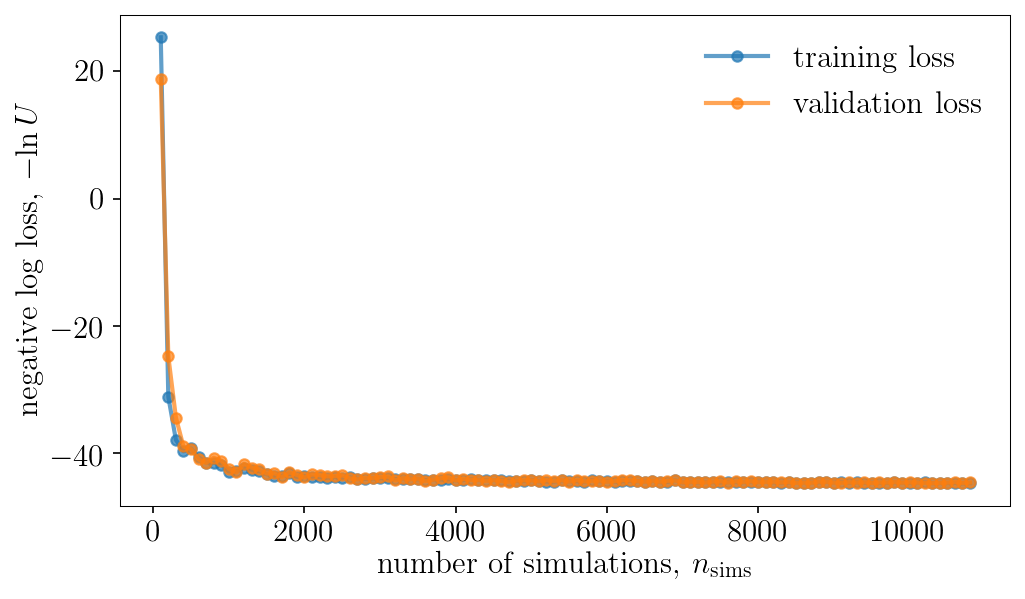

Population 108/150
Sampling proposal density...
Done.


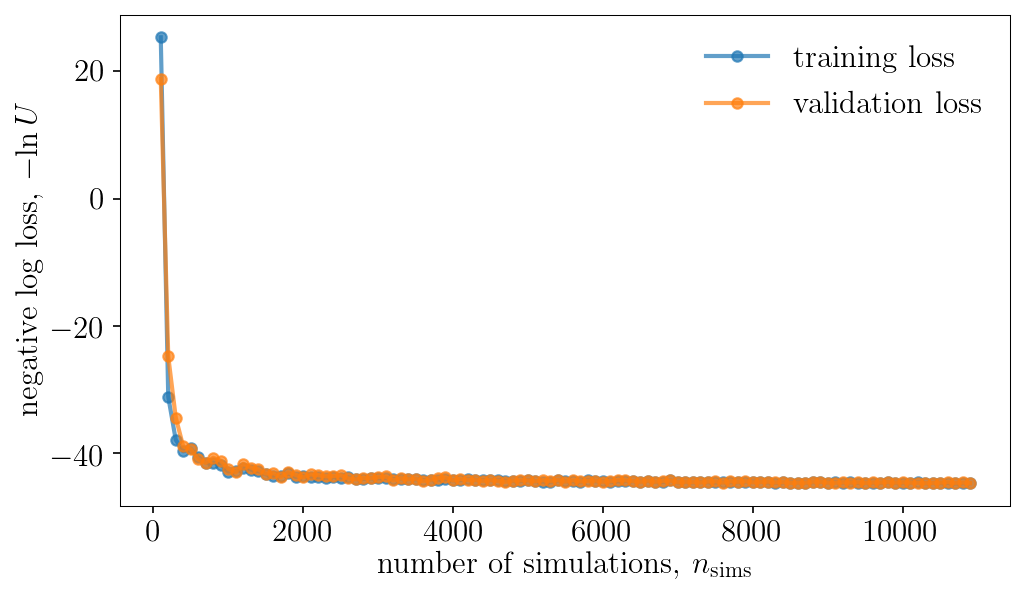

Population 109/150
Sampling proposal density...
Done.


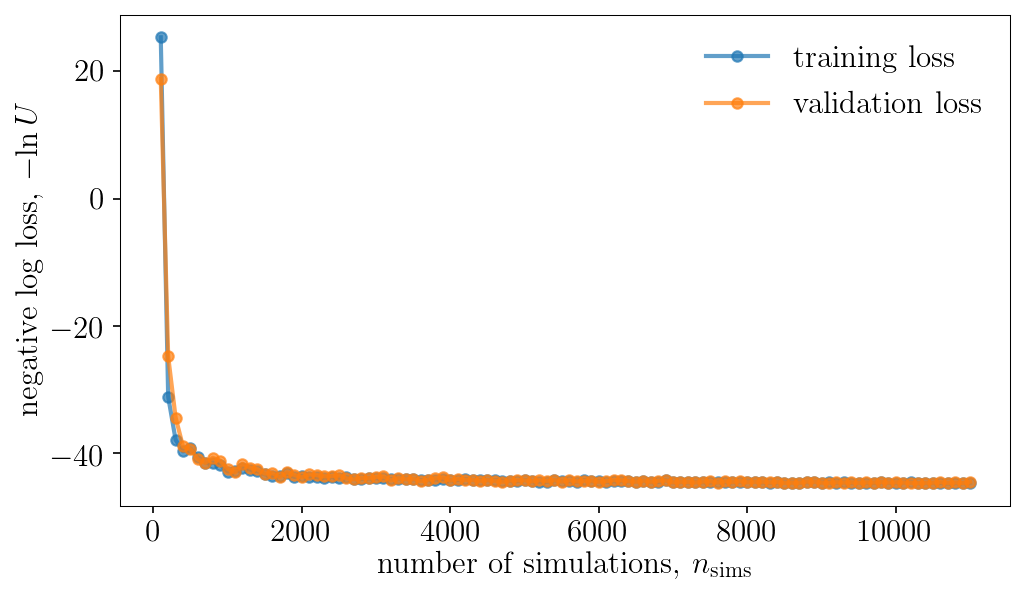

Population 110/150
Sampling proposal density...
Done.


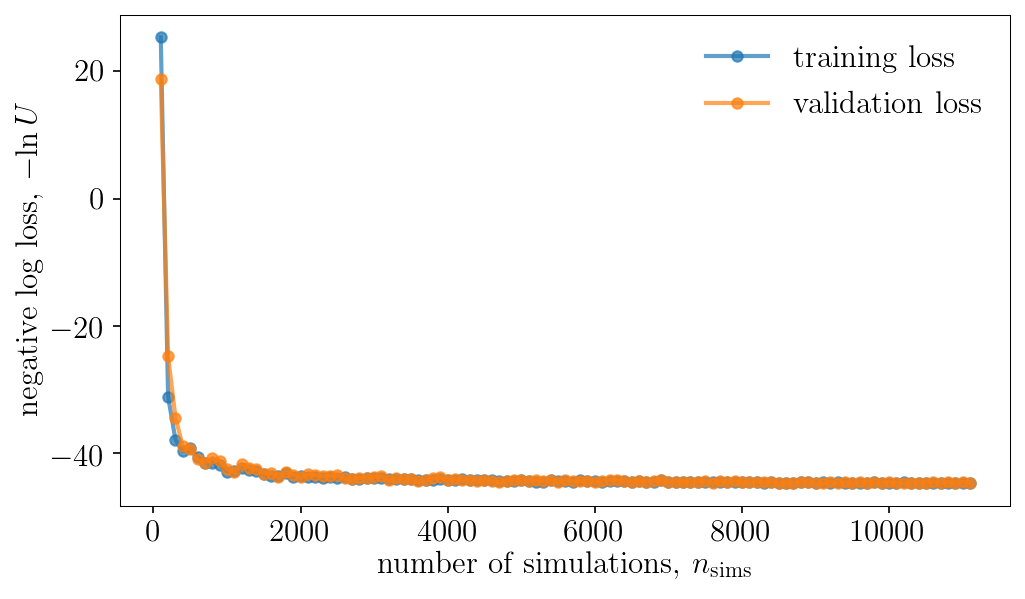

Population 111/150
Sampling proposal density...
Done.


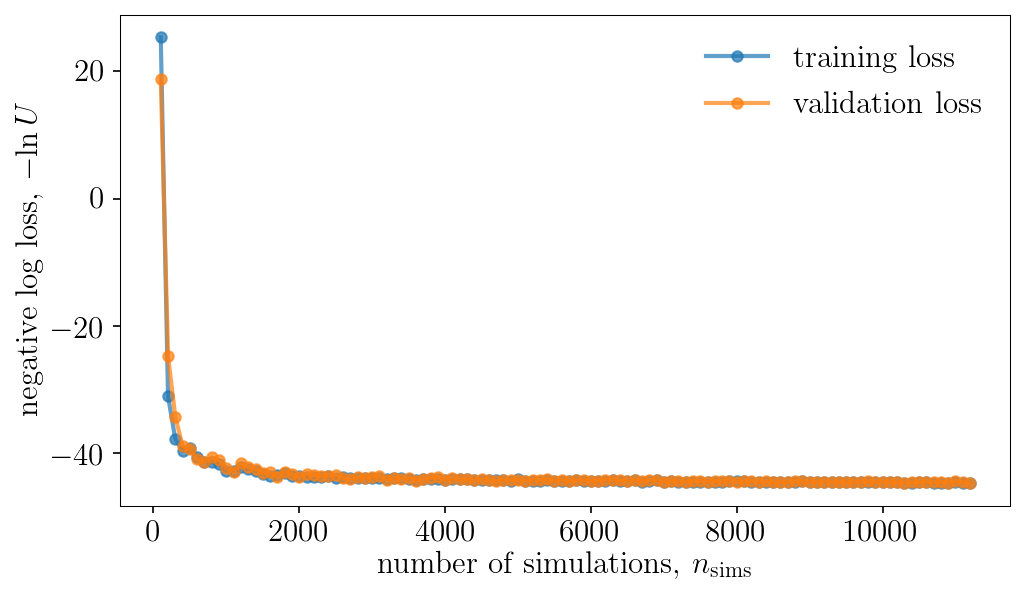

Population 112/150
Sampling proposal density...
Done.


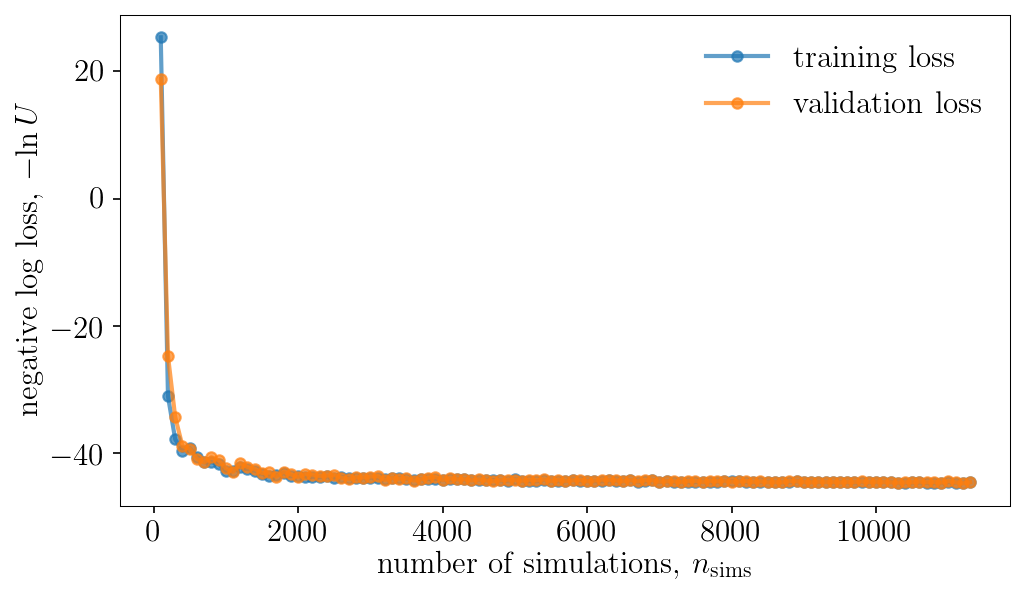

Population 113/150
Sampling proposal density...
Done.


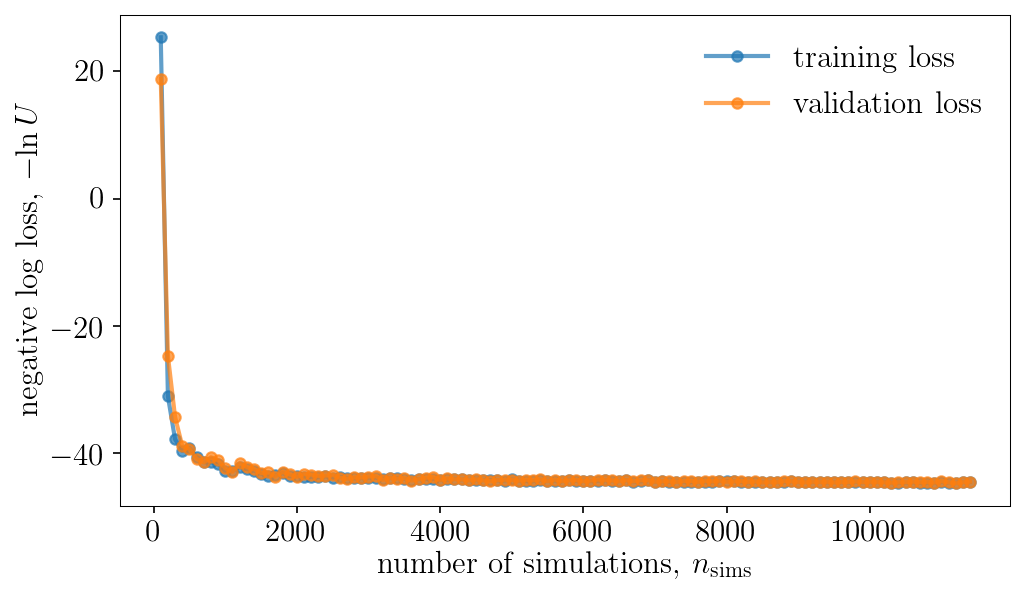

Population 114/150
Sampling proposal density...
Done.


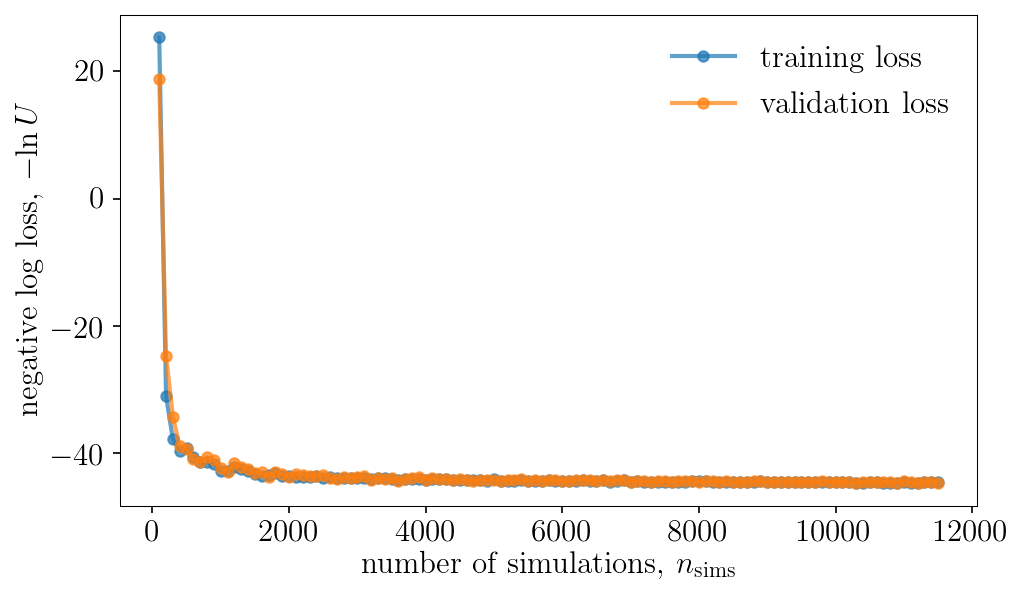

Population 115/150
Sampling proposal density...
Done.


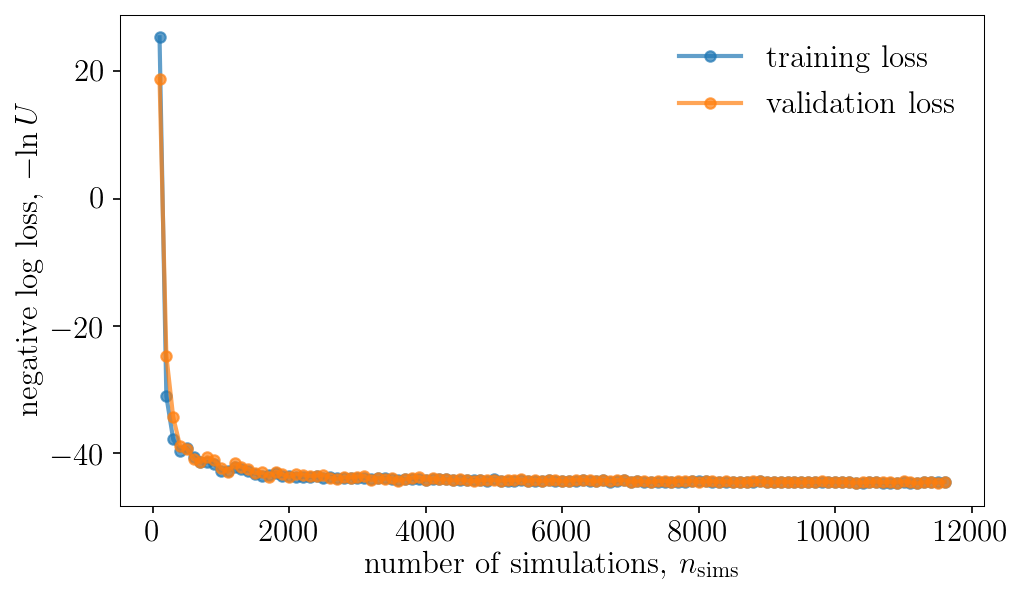

Population 116/150
Sampling proposal density...
Done.


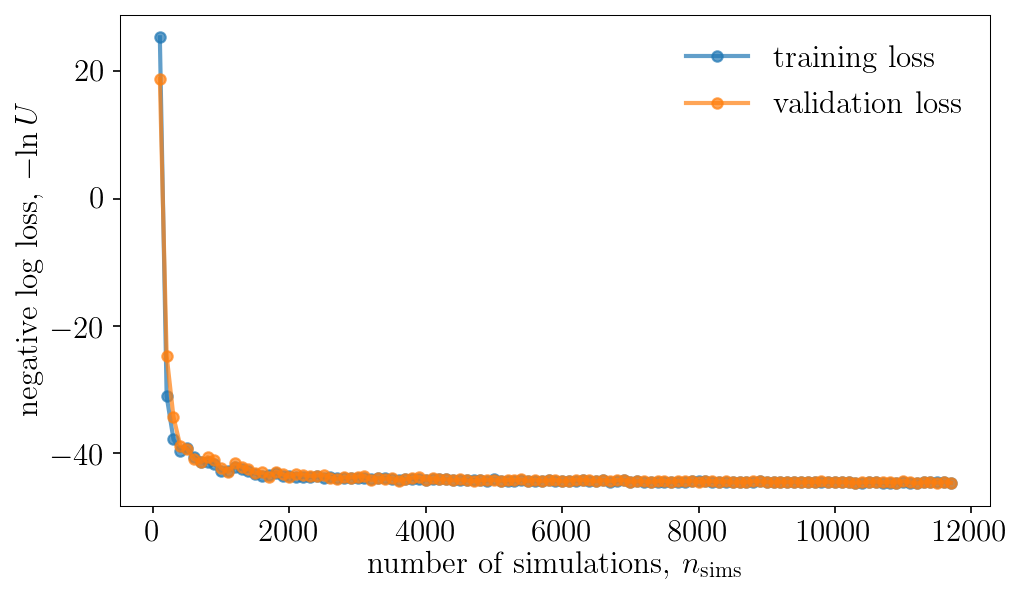

Population 117/150
Sampling proposal density...
Done.


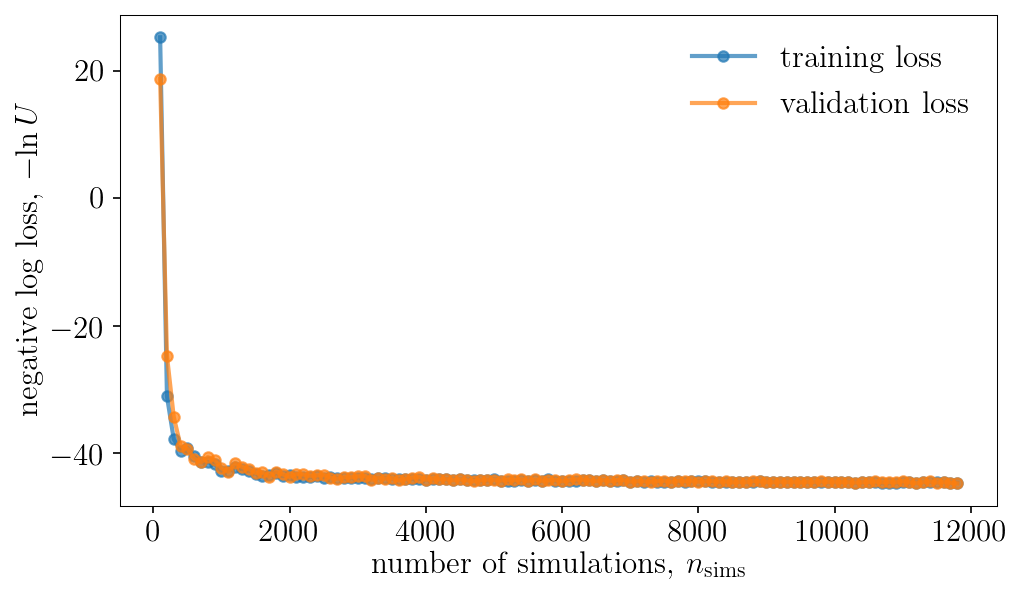

Population 118/150
Sampling proposal density...
Done.


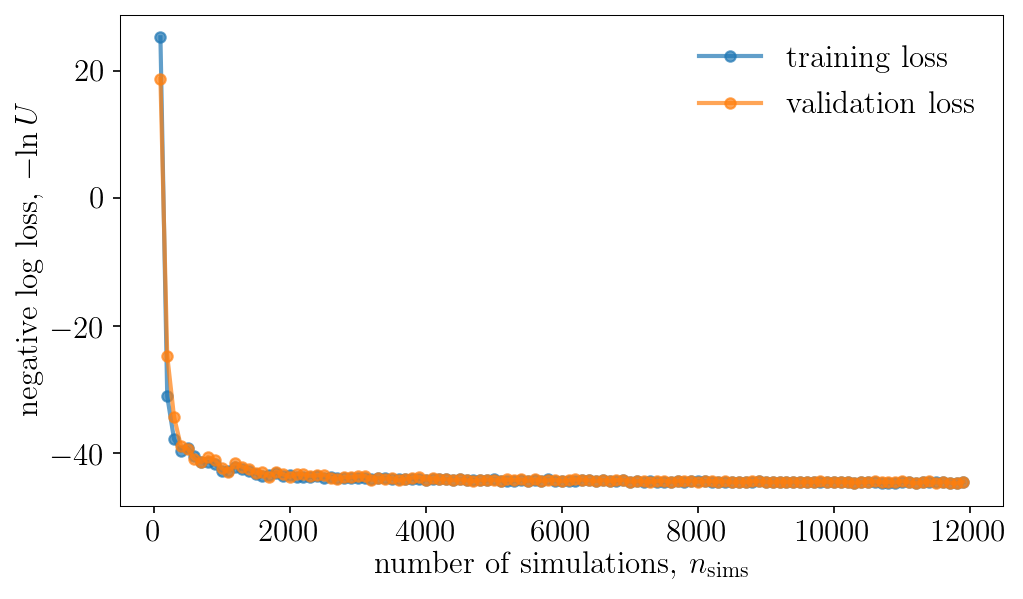

Population 119/150
Sampling proposal density...
Done.


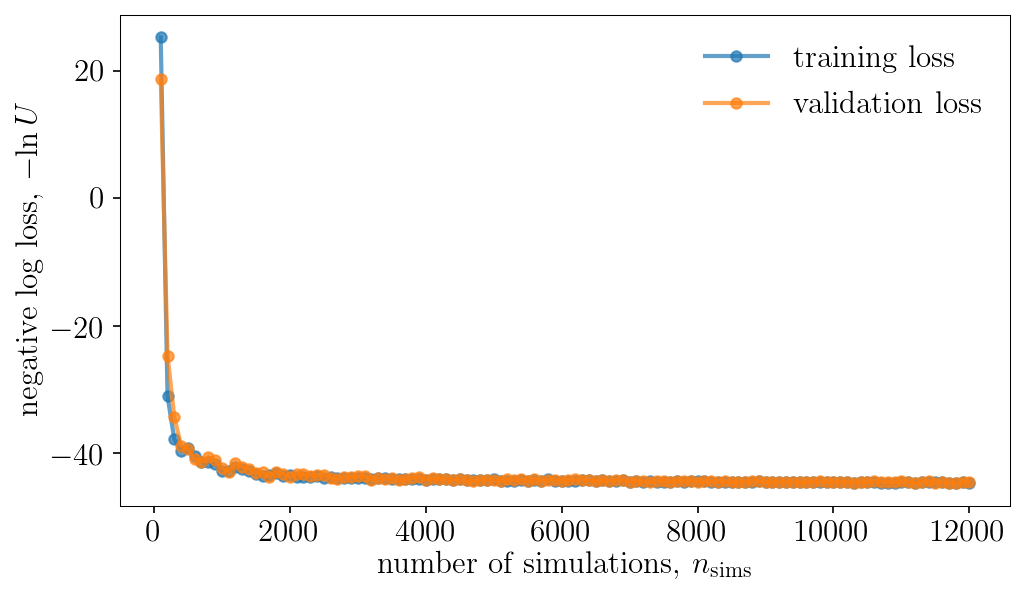

Population 120/150
Sampling proposal density...
Done.


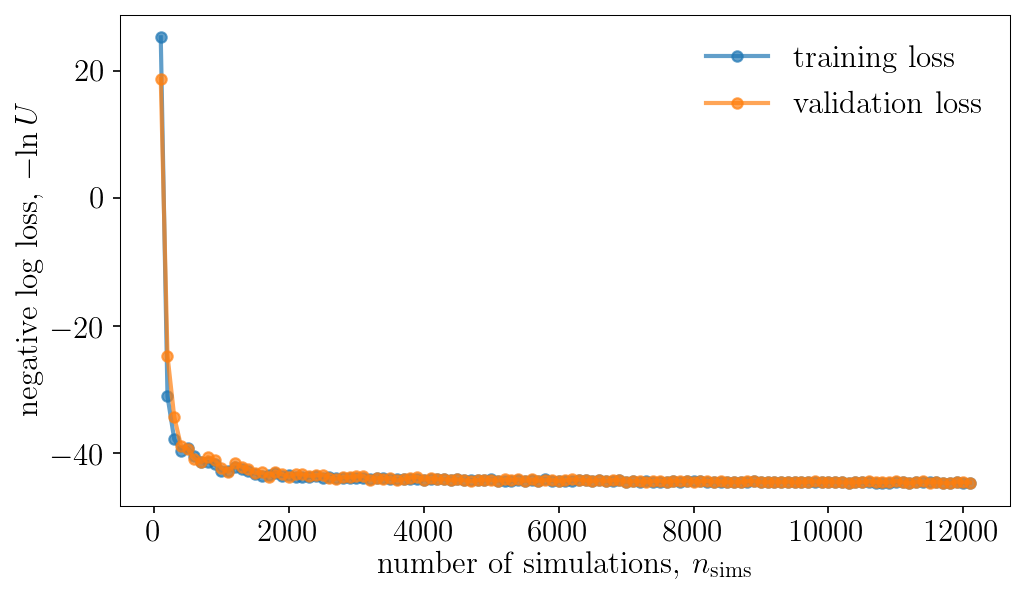

Population 121/150
Sampling proposal density...
Done.


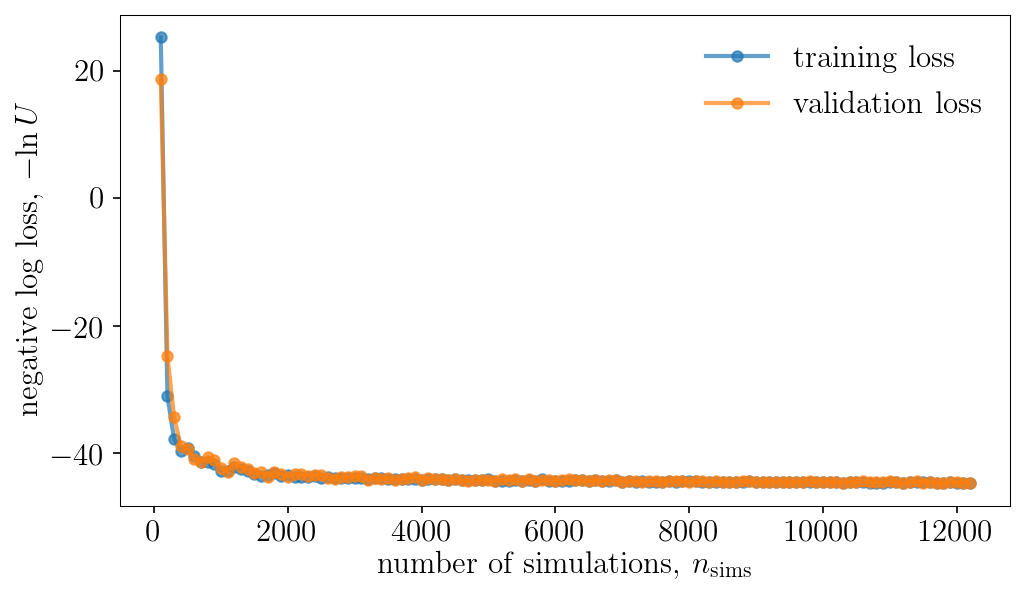

Population 122/150
Sampling proposal density...
Done.


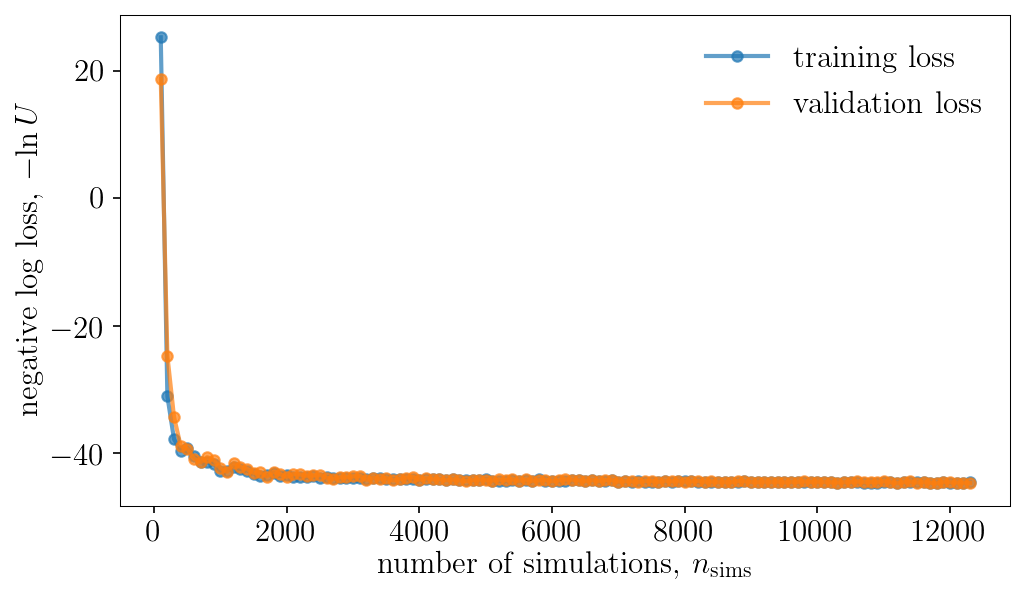

Population 123/150
Sampling proposal density...
Done.


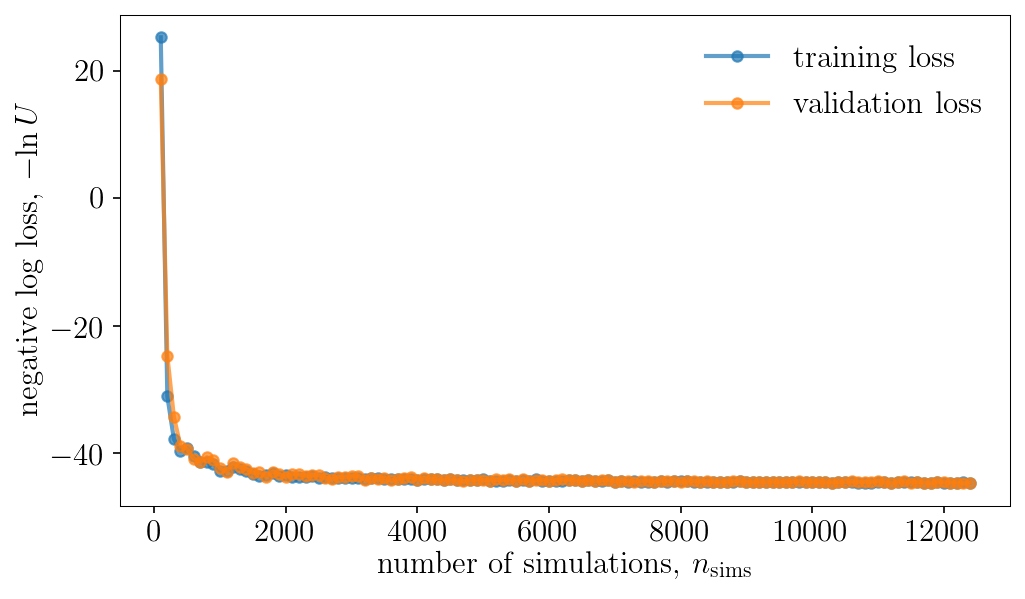

Population 124/150
Sampling proposal density...
Done.


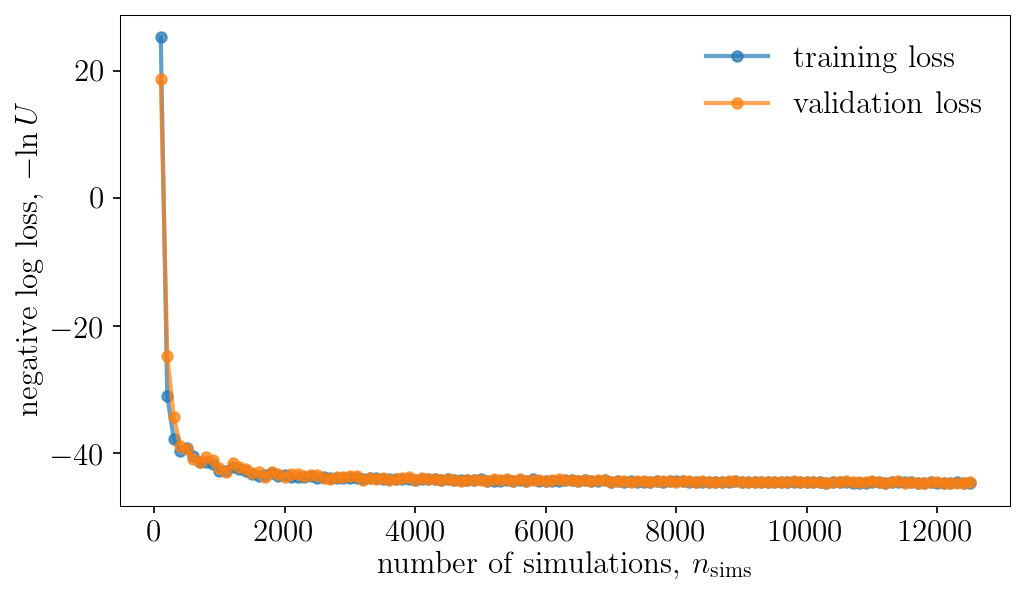

Population 125/150
Sampling proposal density...
Done.


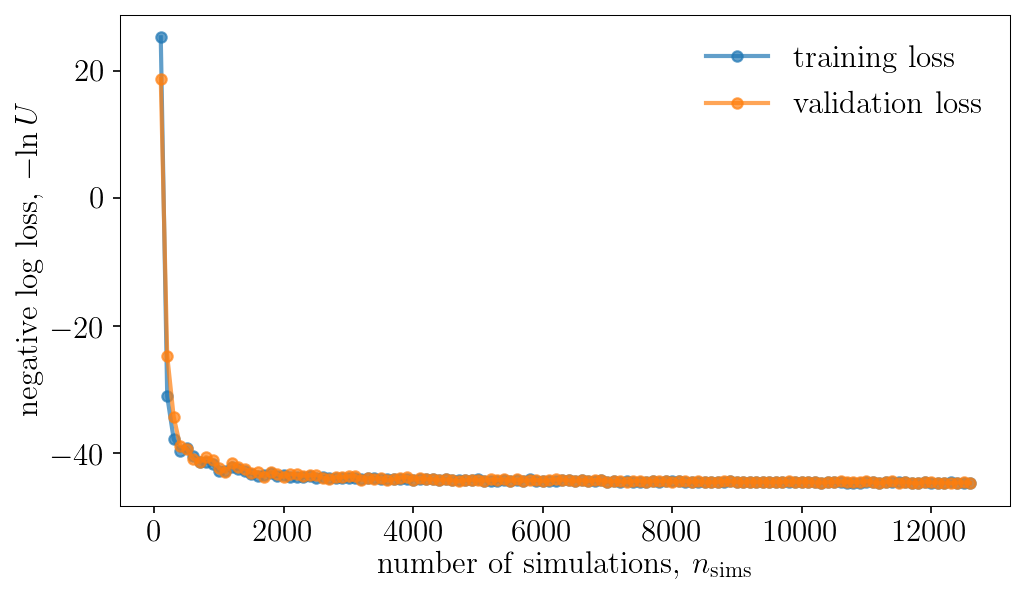

Population 126/150
Sampling proposal density...
Done.


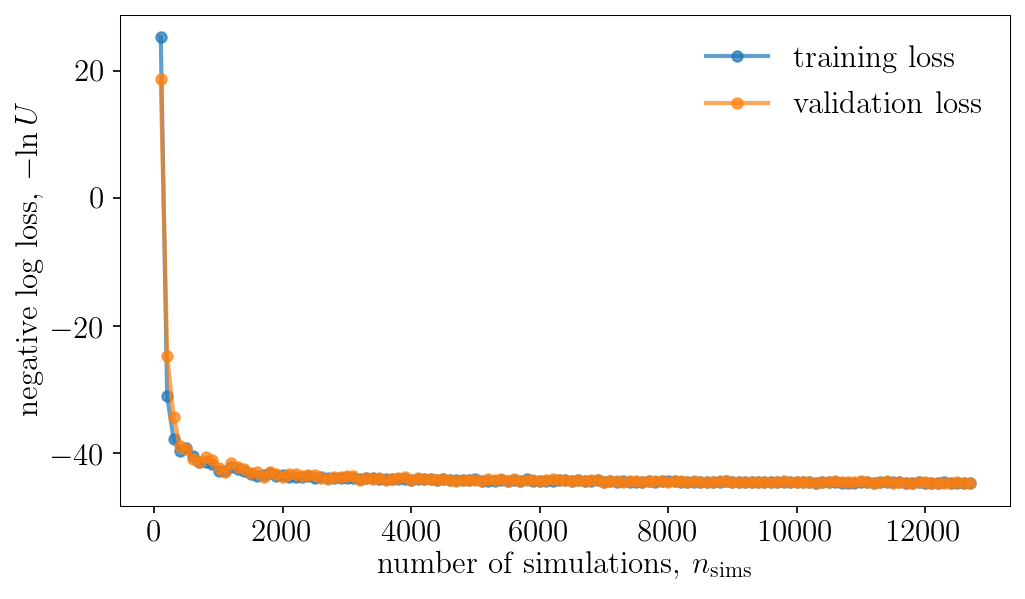

Population 127/150
Sampling proposal density...
Done.


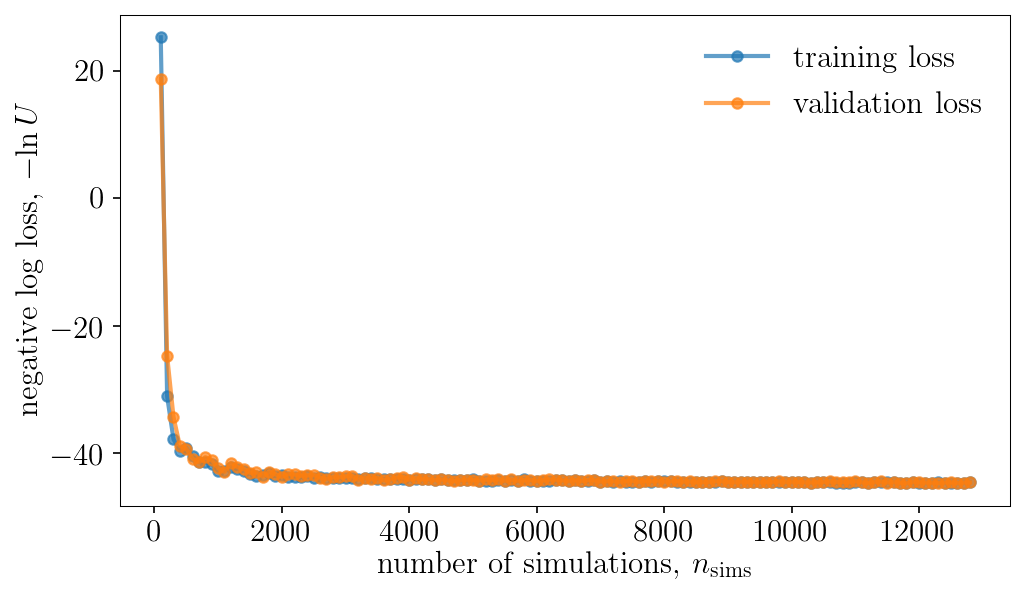

Population 128/150
Sampling proposal density...
Done.


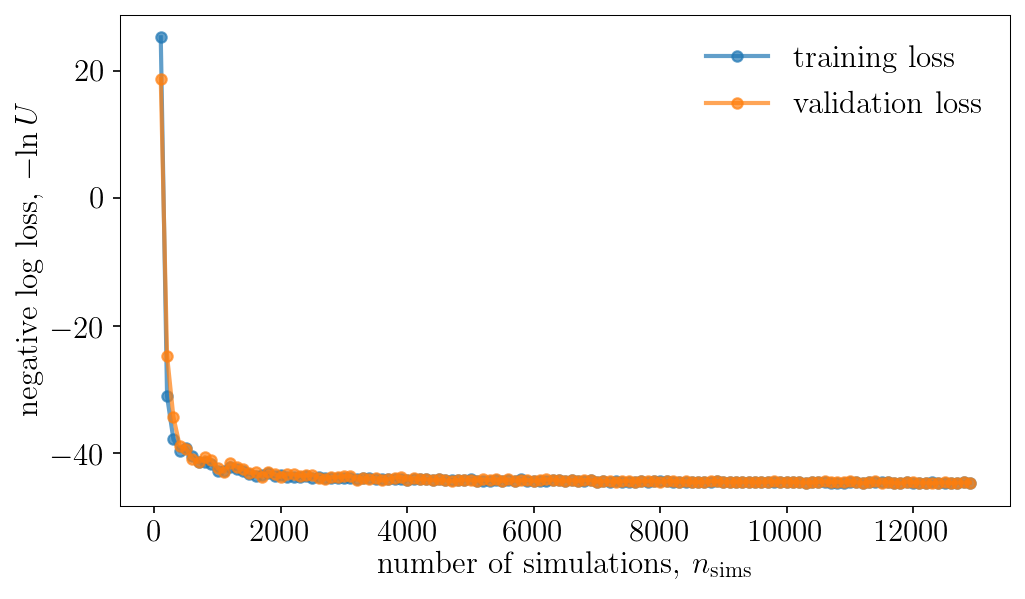

Population 129/150
Sampling proposal density...
Done.


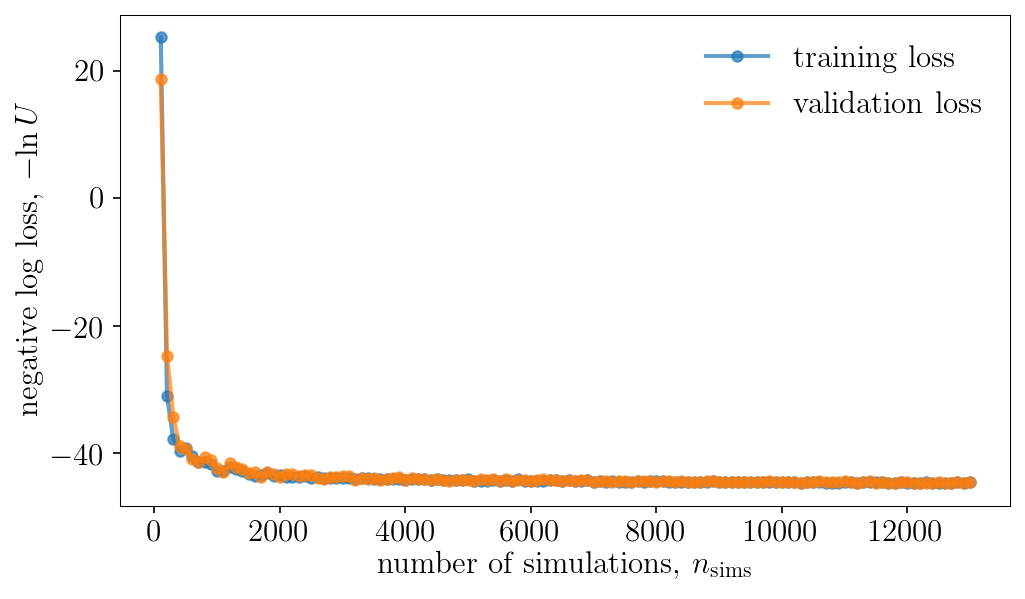

Population 130/150
Sampling proposal density...
Done.


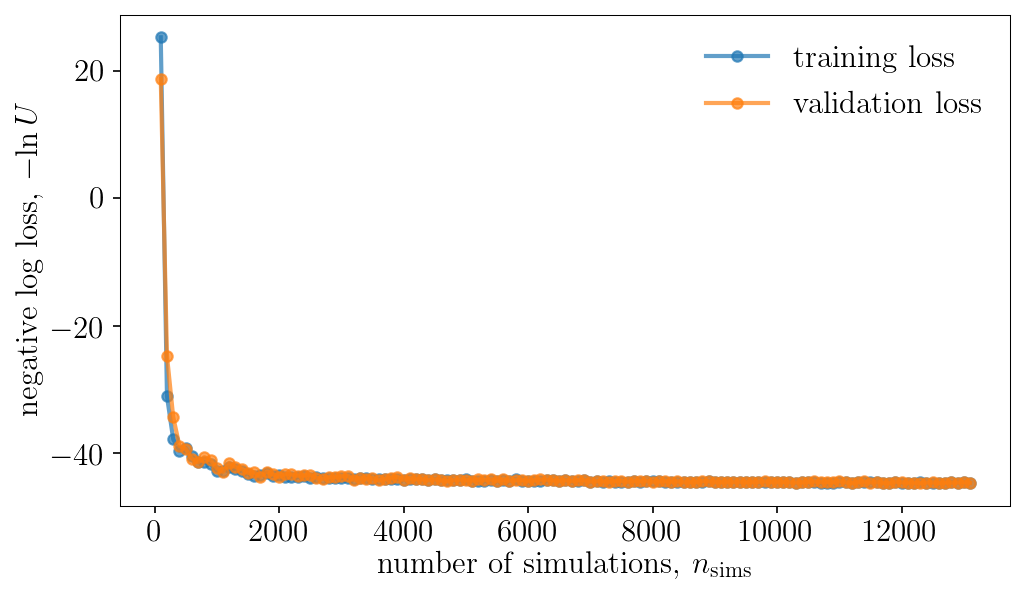

Population 131/150
Sampling proposal density...
Done.


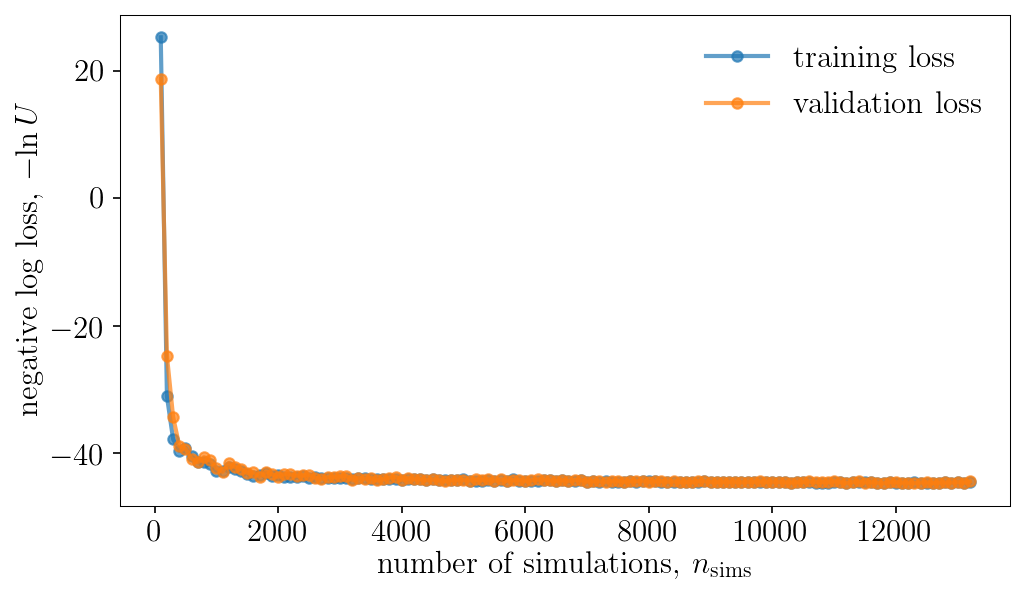

Population 132/150
Sampling proposal density...
Done.


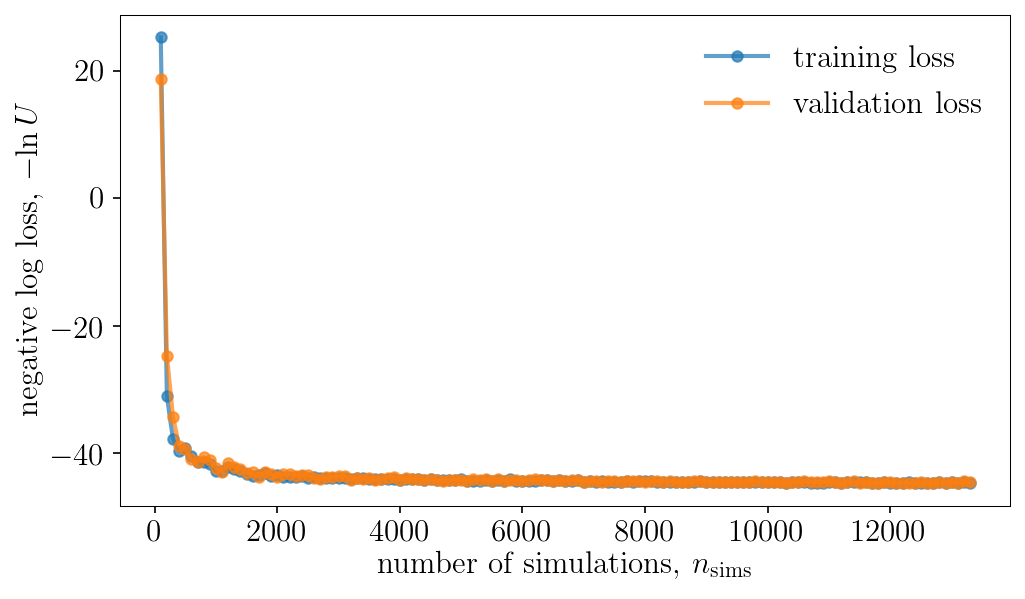

Population 133/150
Sampling proposal density...
Done.


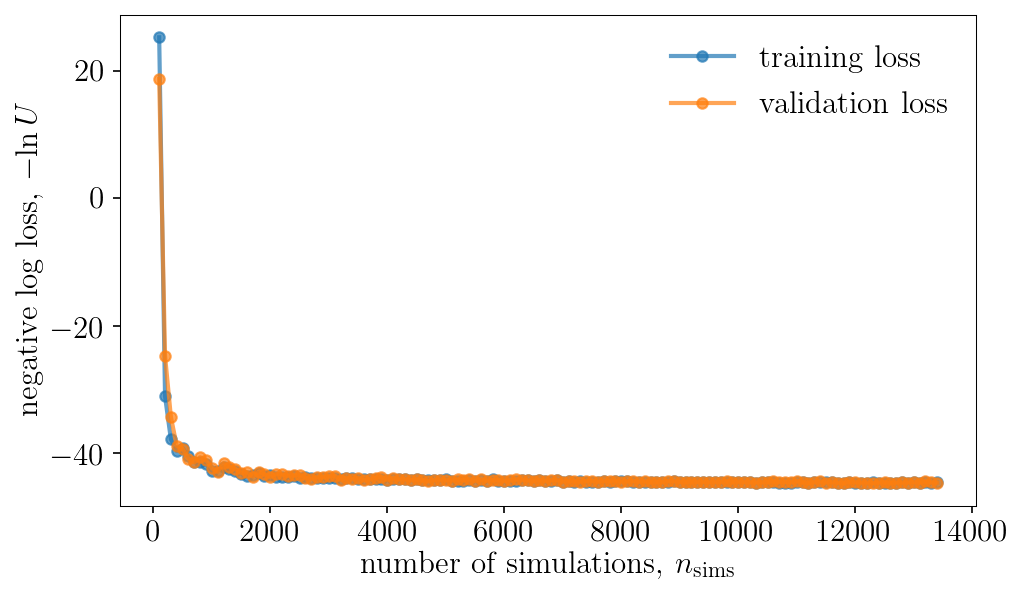

Population 134/150
Sampling proposal density...
Done.


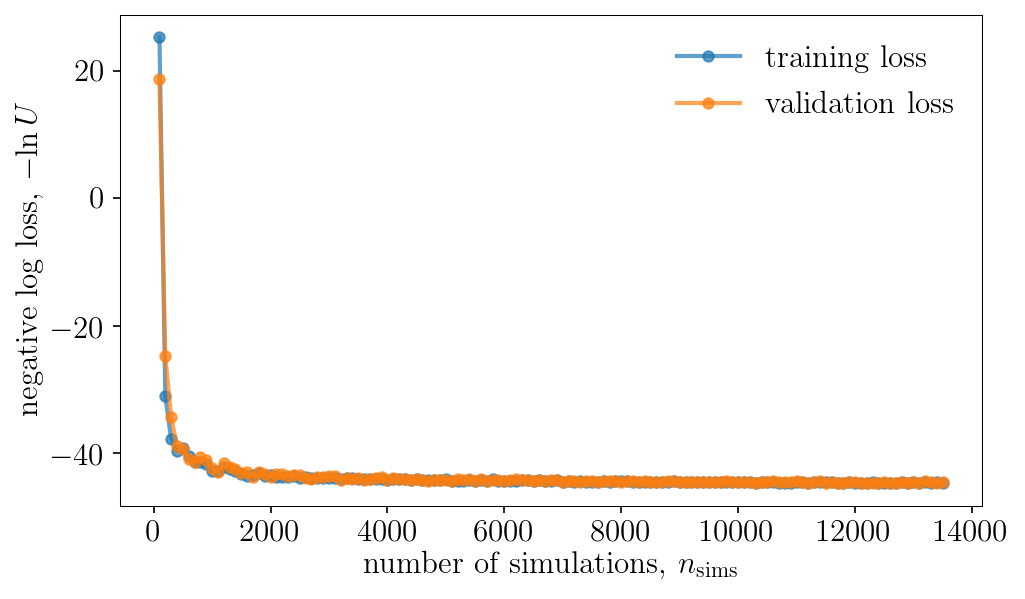

Population 135/150
Sampling proposal density...
Done.


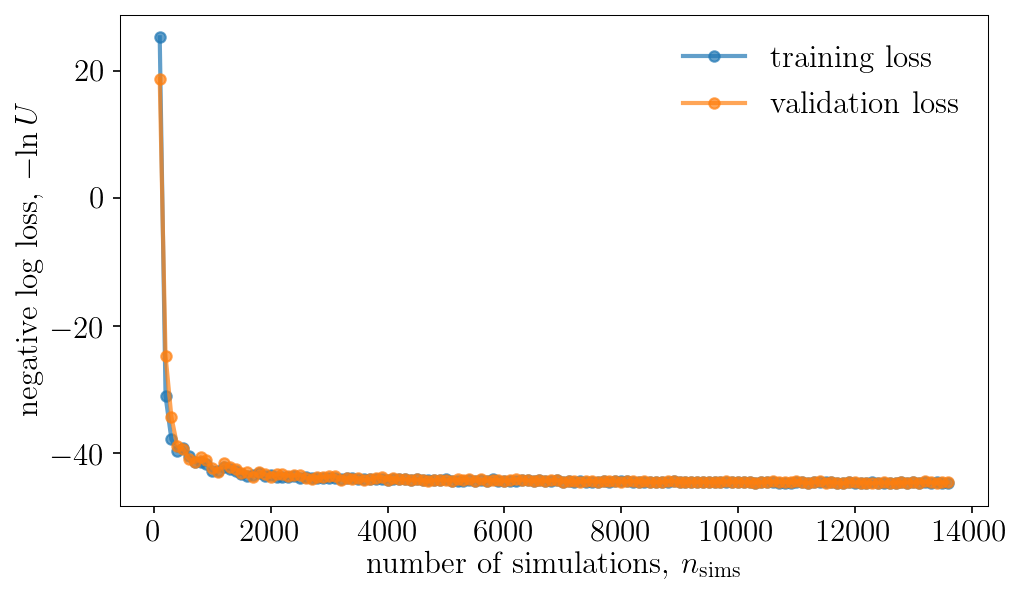

Population 136/150
Sampling proposal density...
Done.


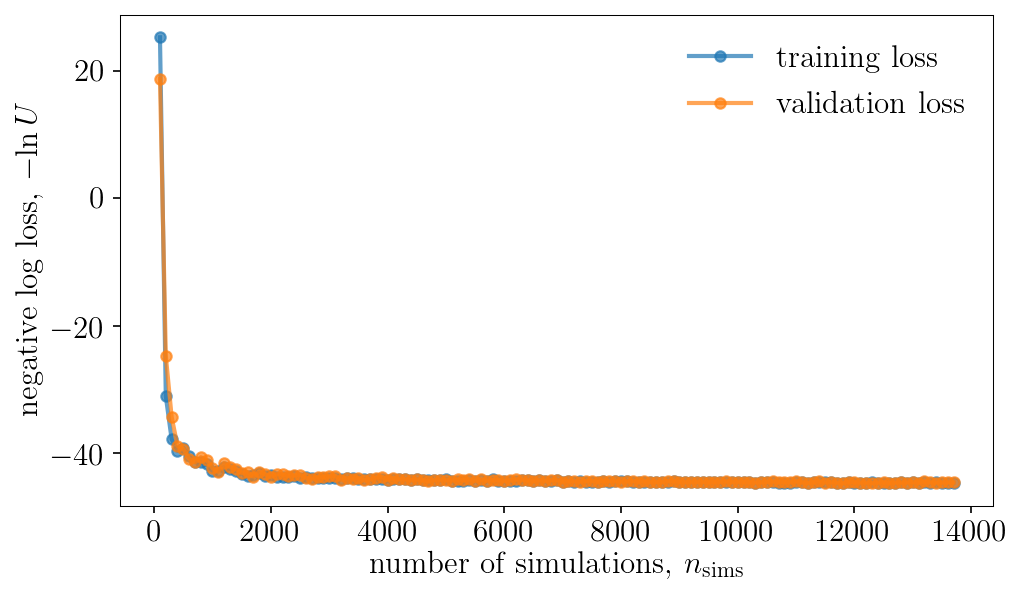

Population 137/150
Sampling proposal density...
Done.


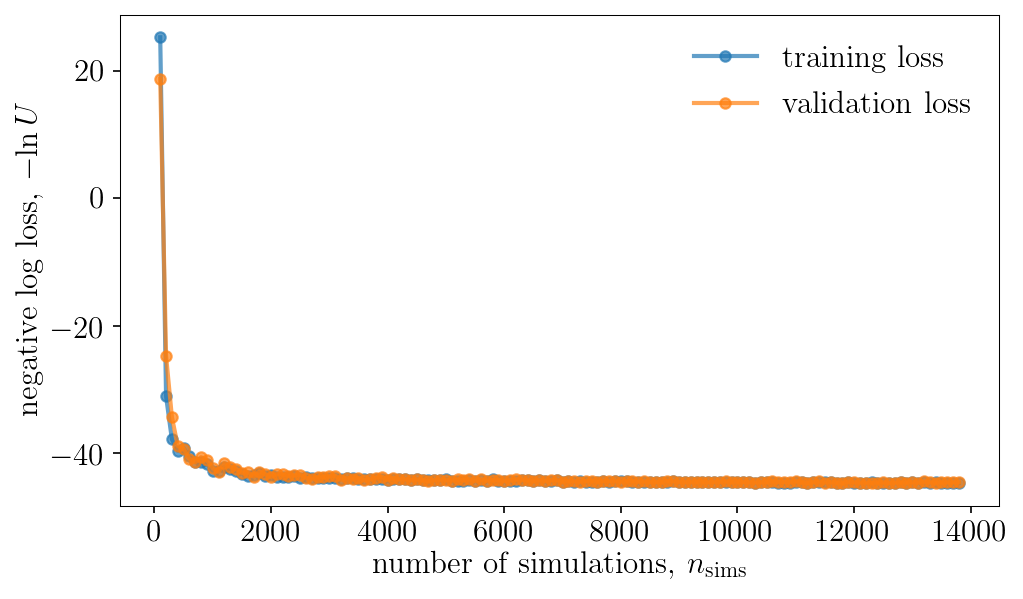

Population 138/150
Sampling proposal density...
Done.


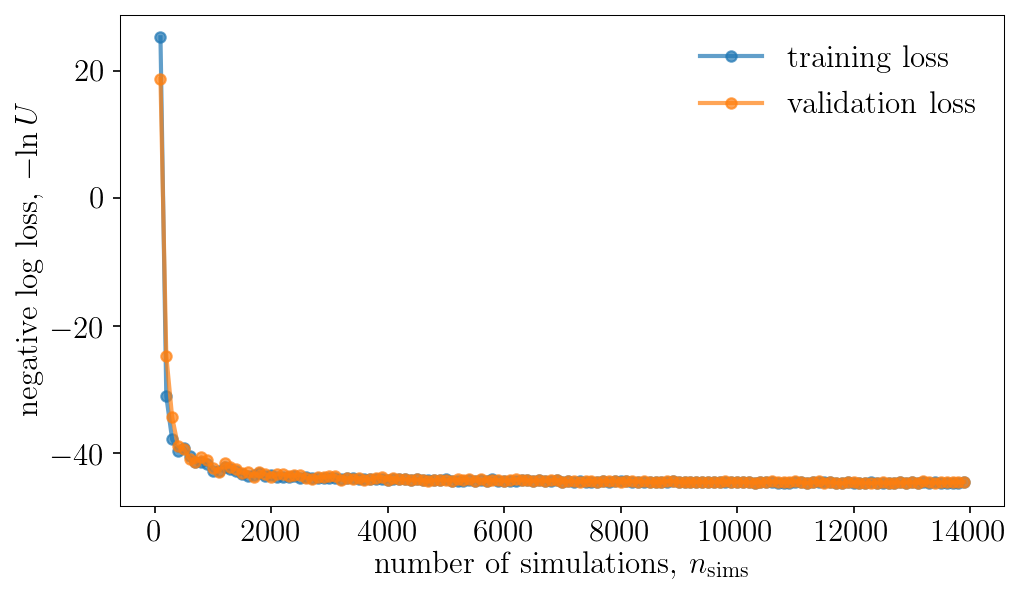

Population 139/150
Sampling proposal density...
Done.


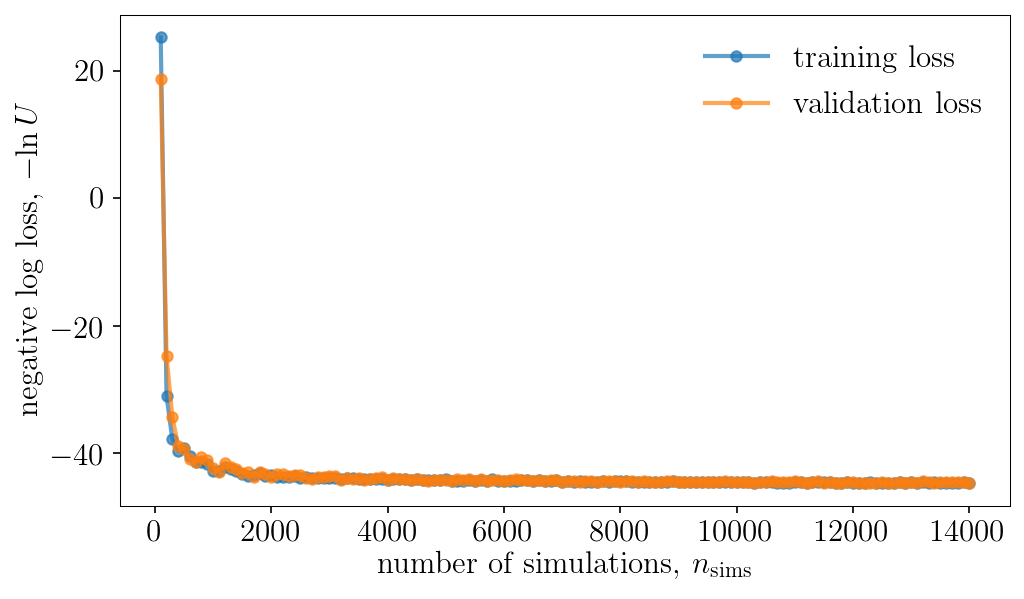

Population 140/150
Sampling proposal density...
Done.


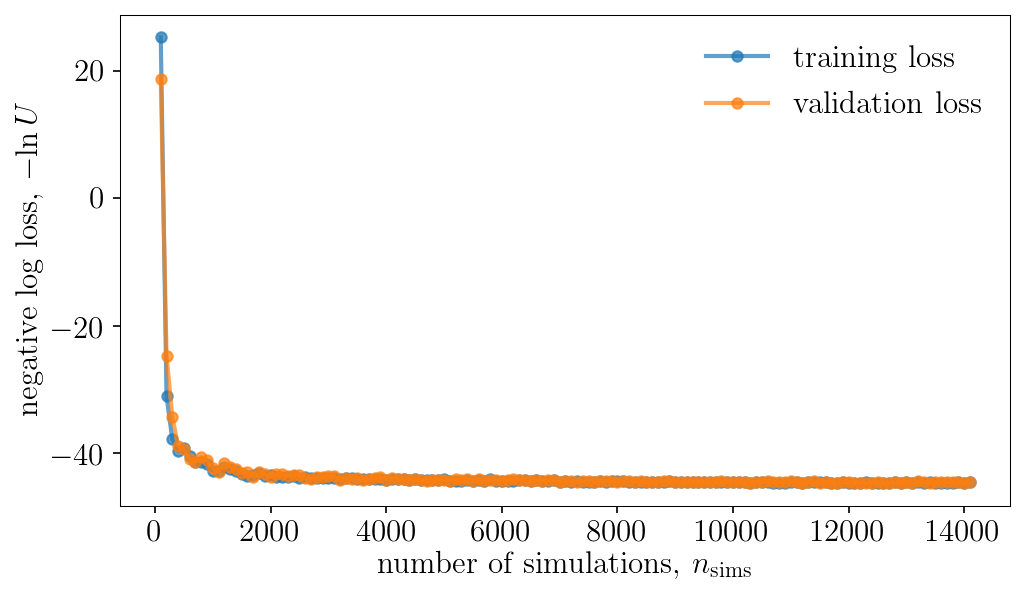

Population 141/150
Sampling proposal density...
Done.


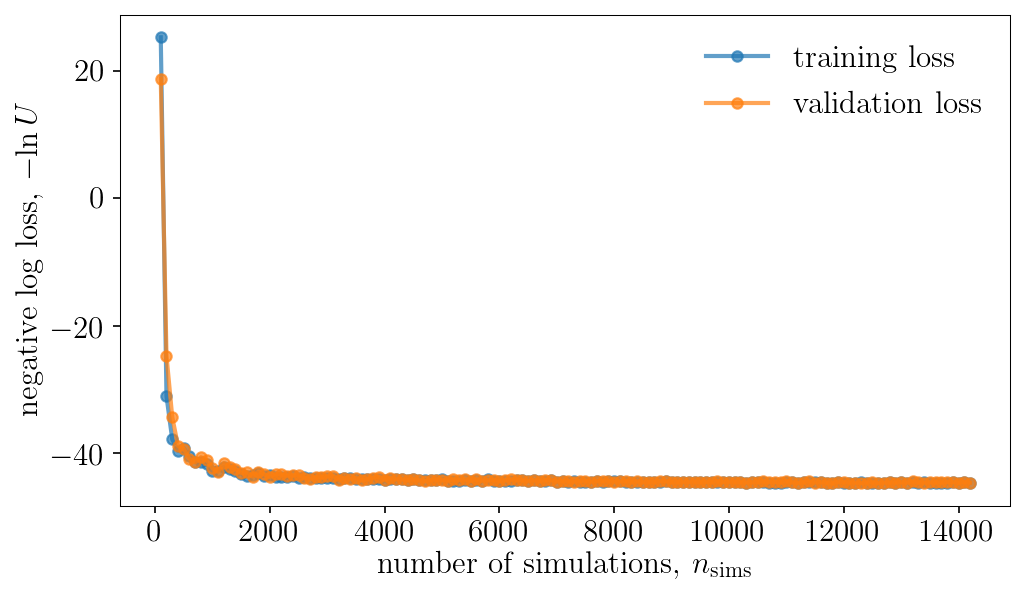

Population 142/150
Sampling proposal density...
Done.


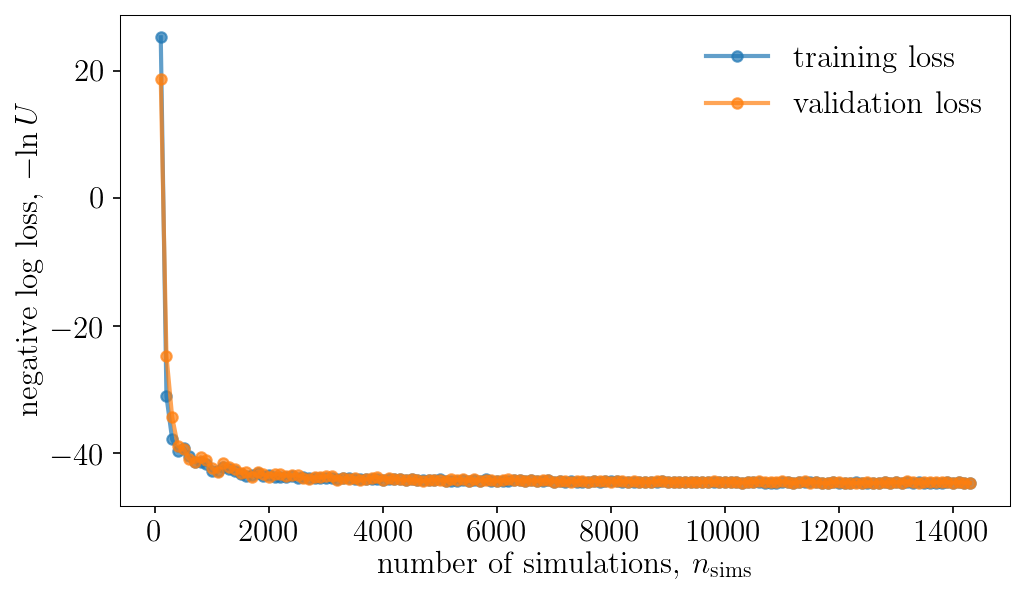

Population 143/150
Sampling proposal density...
Done.


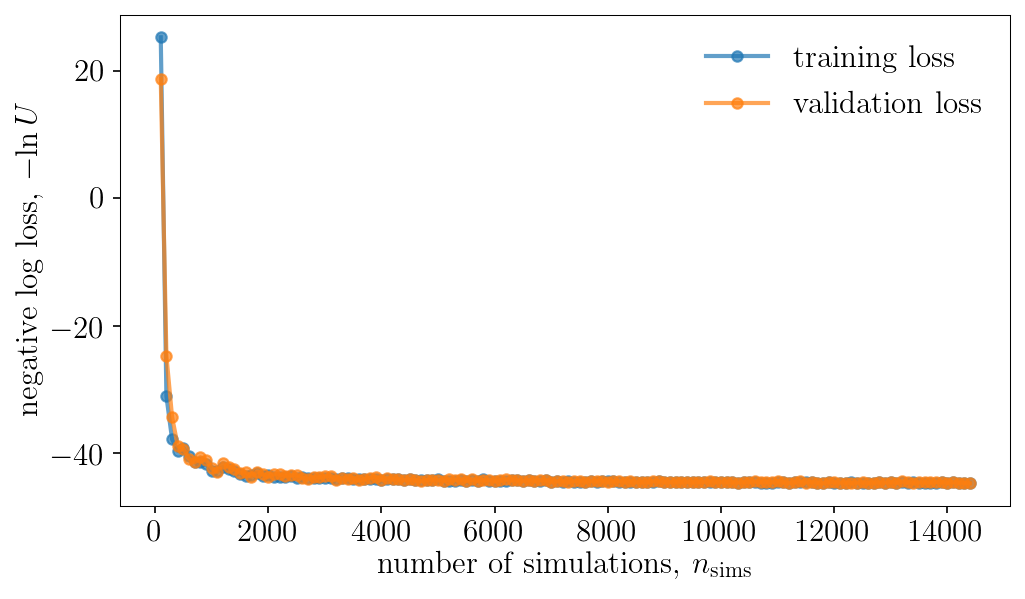

Population 144/150
Sampling proposal density...
Done.


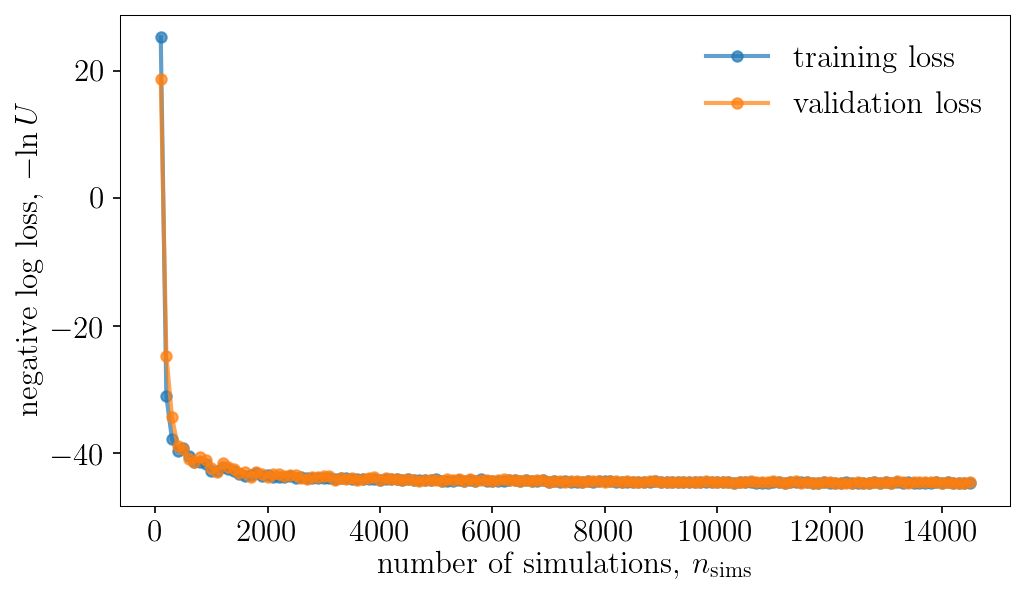

Population 145/150
Sampling proposal density...
Done.


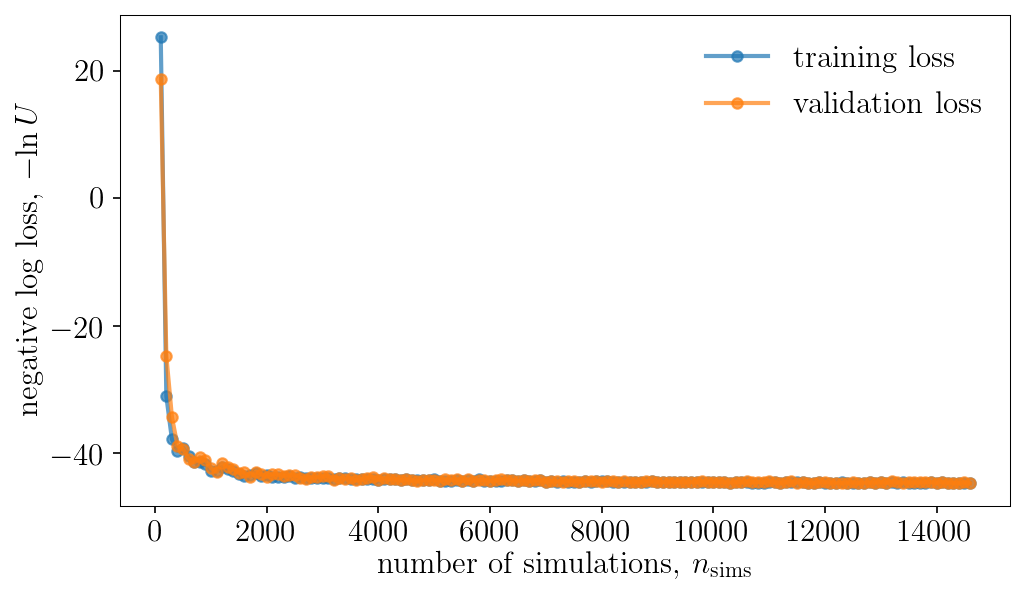

Population 146/150
Sampling proposal density...
Done.


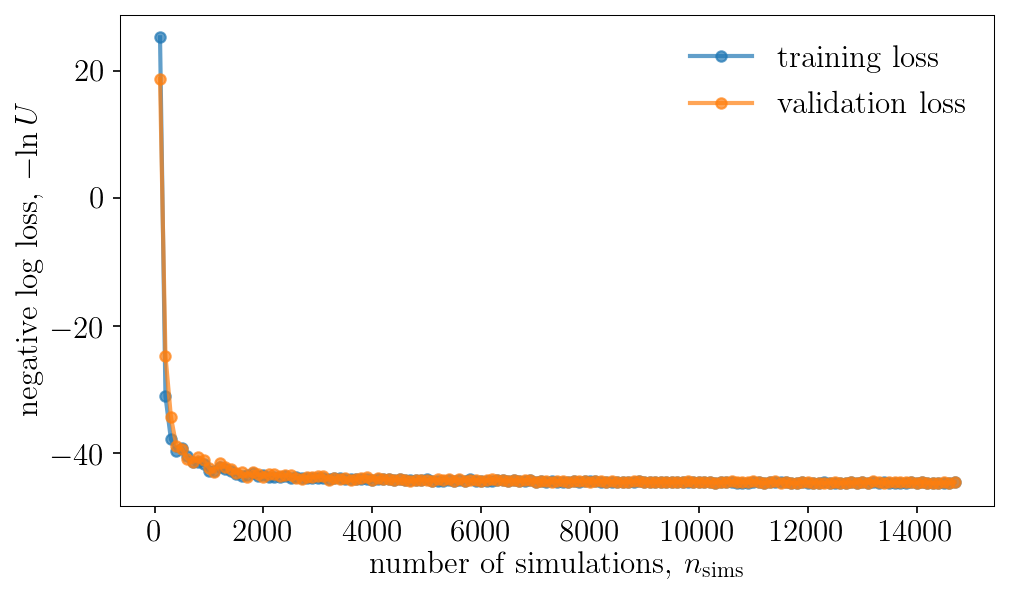

Population 147/150
Sampling proposal density...
Done.


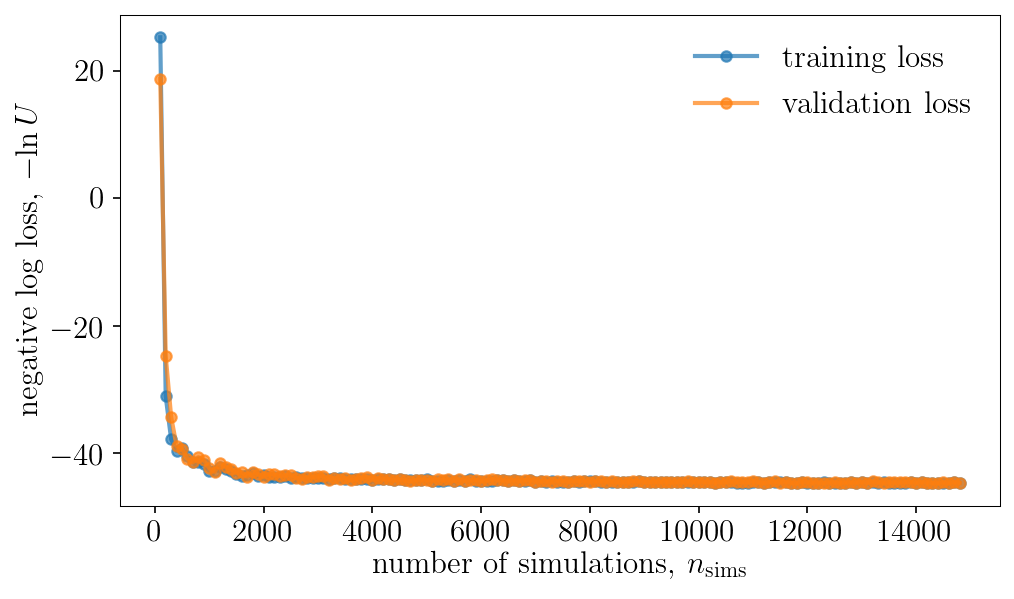

Population 148/150
Sampling proposal density...
Done.


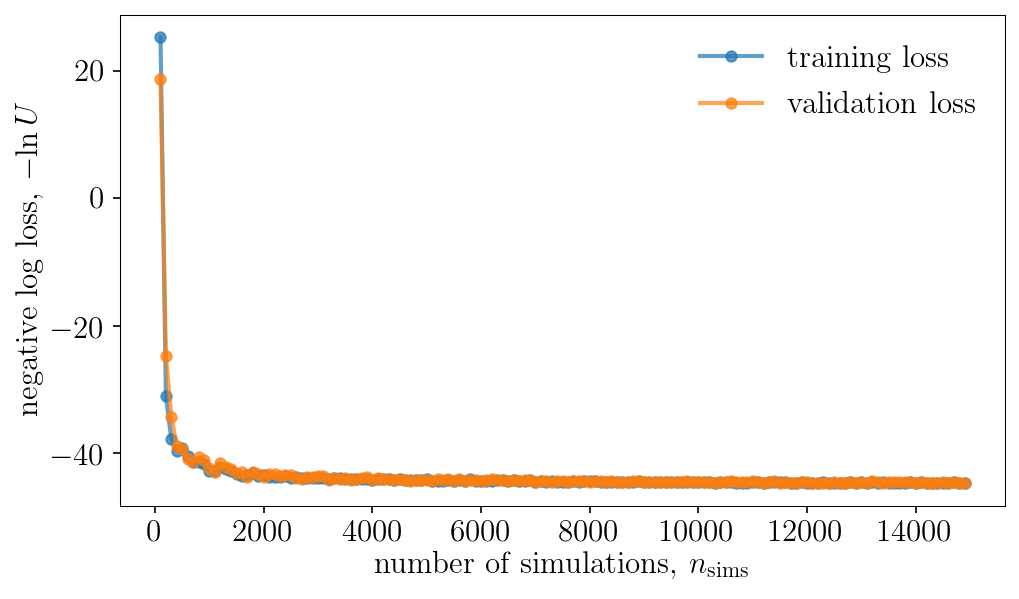

Population 149/150
Sampling proposal density...
Done.


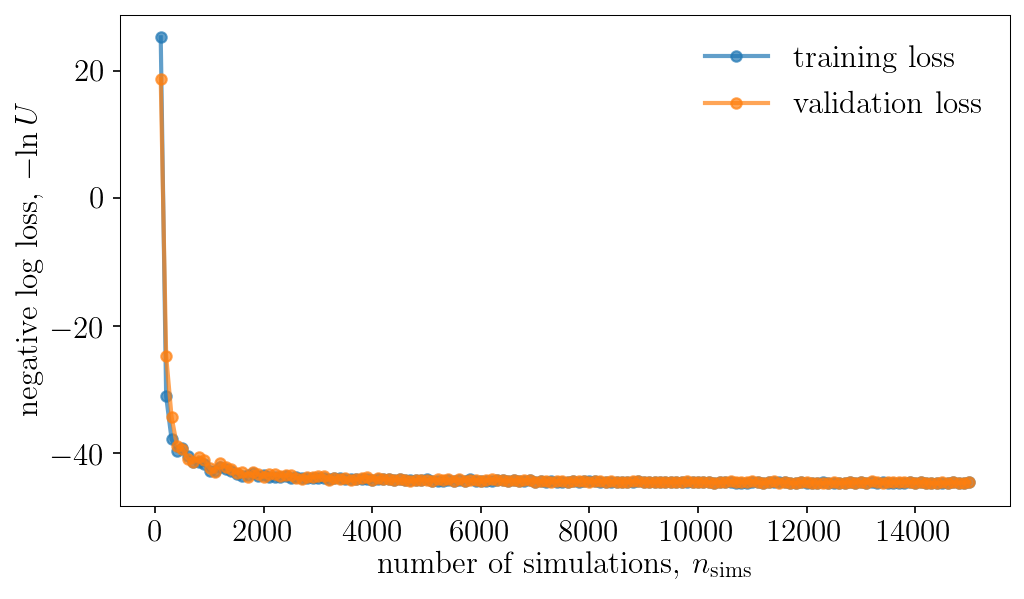

Population 150/150
Sampling proposal density...
Done.


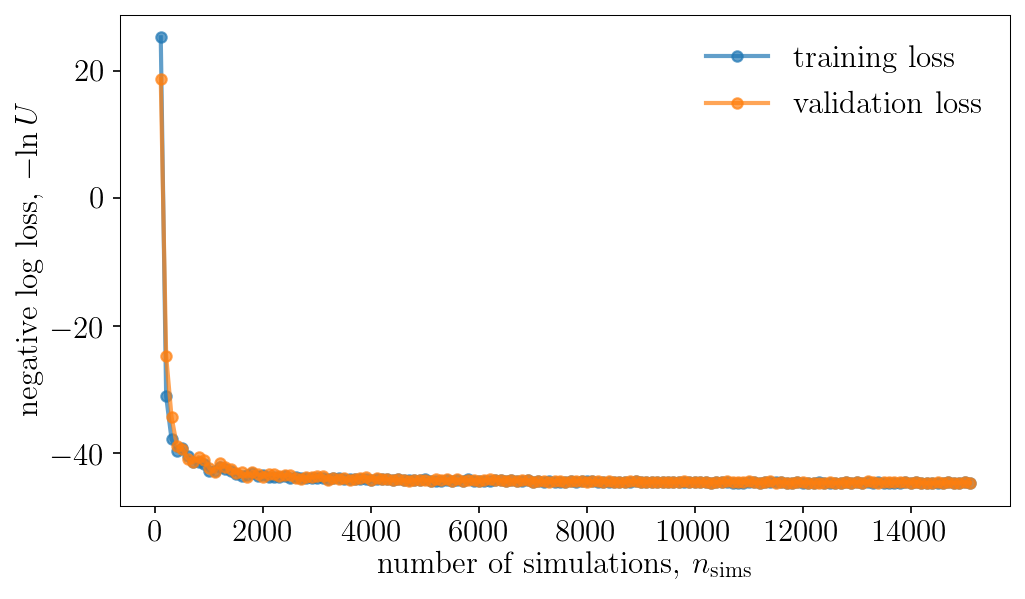

In [20]:
DelfiEnsemble0.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

## Sample the learned posterior

In [21]:
x0 = DelfiEnsemble0.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble0.posterior_samples)), 
                                                       p=DelfiEnsemble0.posterior_weights.astype(np.float32)/sum(DelfiEnsemble0.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble0.nwalkers),:]
posterior_samples_0, posterior_weights_0, log_prob_0 = DelfiEnsemble0.emcee_sample(x0=x0)

Removed no burn in


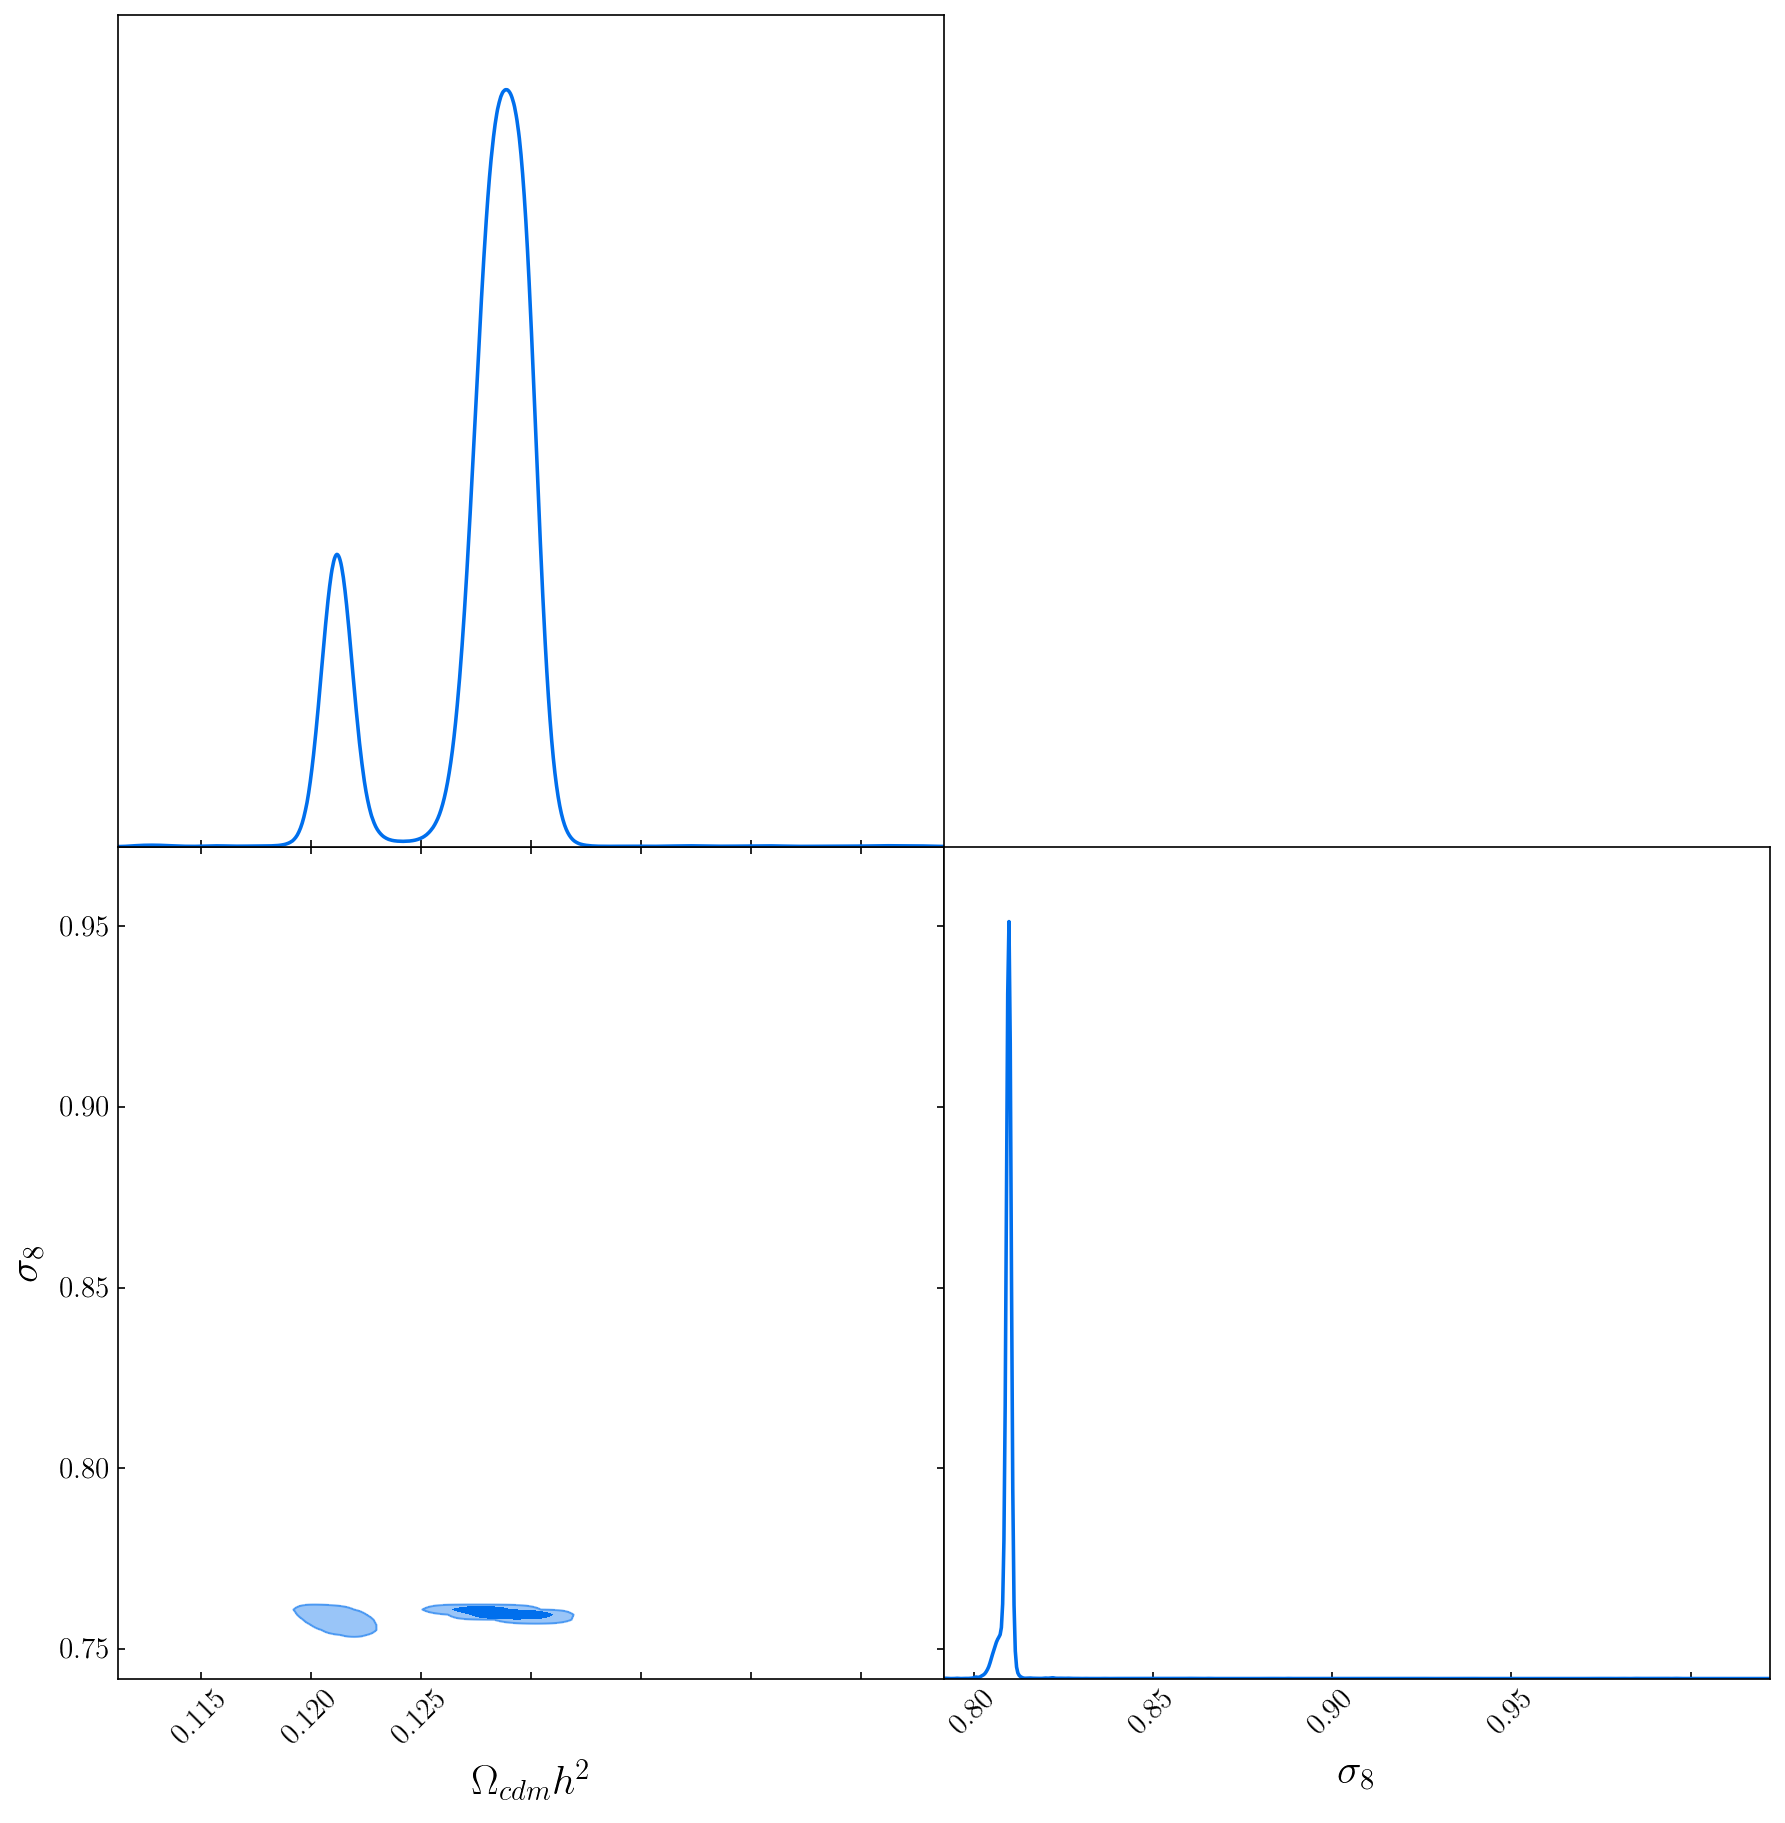

In [22]:
DelfiEnsemble0.triangle_plot(samples=[posterior_samples_0], weights=[posterior_weights_0])

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [23]:
np.savetxt(DelfiEnsemble0.results_dir+'posterior_samples.npy', posterior_samples_0)
np.savetxt(DelfiEnsemble0.results_dir+'posterior_weights.npy', posterior_weights_0)

In [24]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator)
    
    return results_means, results_stdev

In [25]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples_0, posterior_weights_0)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

fiducial params[0.1197 0.76  ]
[0.11893015 0.76042306]
[0.00131779 0.01262816]


In [26]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
#print('On \omega_b: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')

Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11629456340319214, 0.12156573247917707 ]
On \sigma_8: [0.7351667375256065, 0.785679386675915 ]


In [27]:
DelfiEnsemble0.results_dir

'simulators/mass_function_n_counts/results_seed1_15000sims_3NDEs_2/'

In [28]:
posterior_samples, posterior_weights, log_prob = DelfiEnsemble0.emcee_sample(x0=x0, burn_in_chain=1000, main_chain=20000)



Removed no burn in


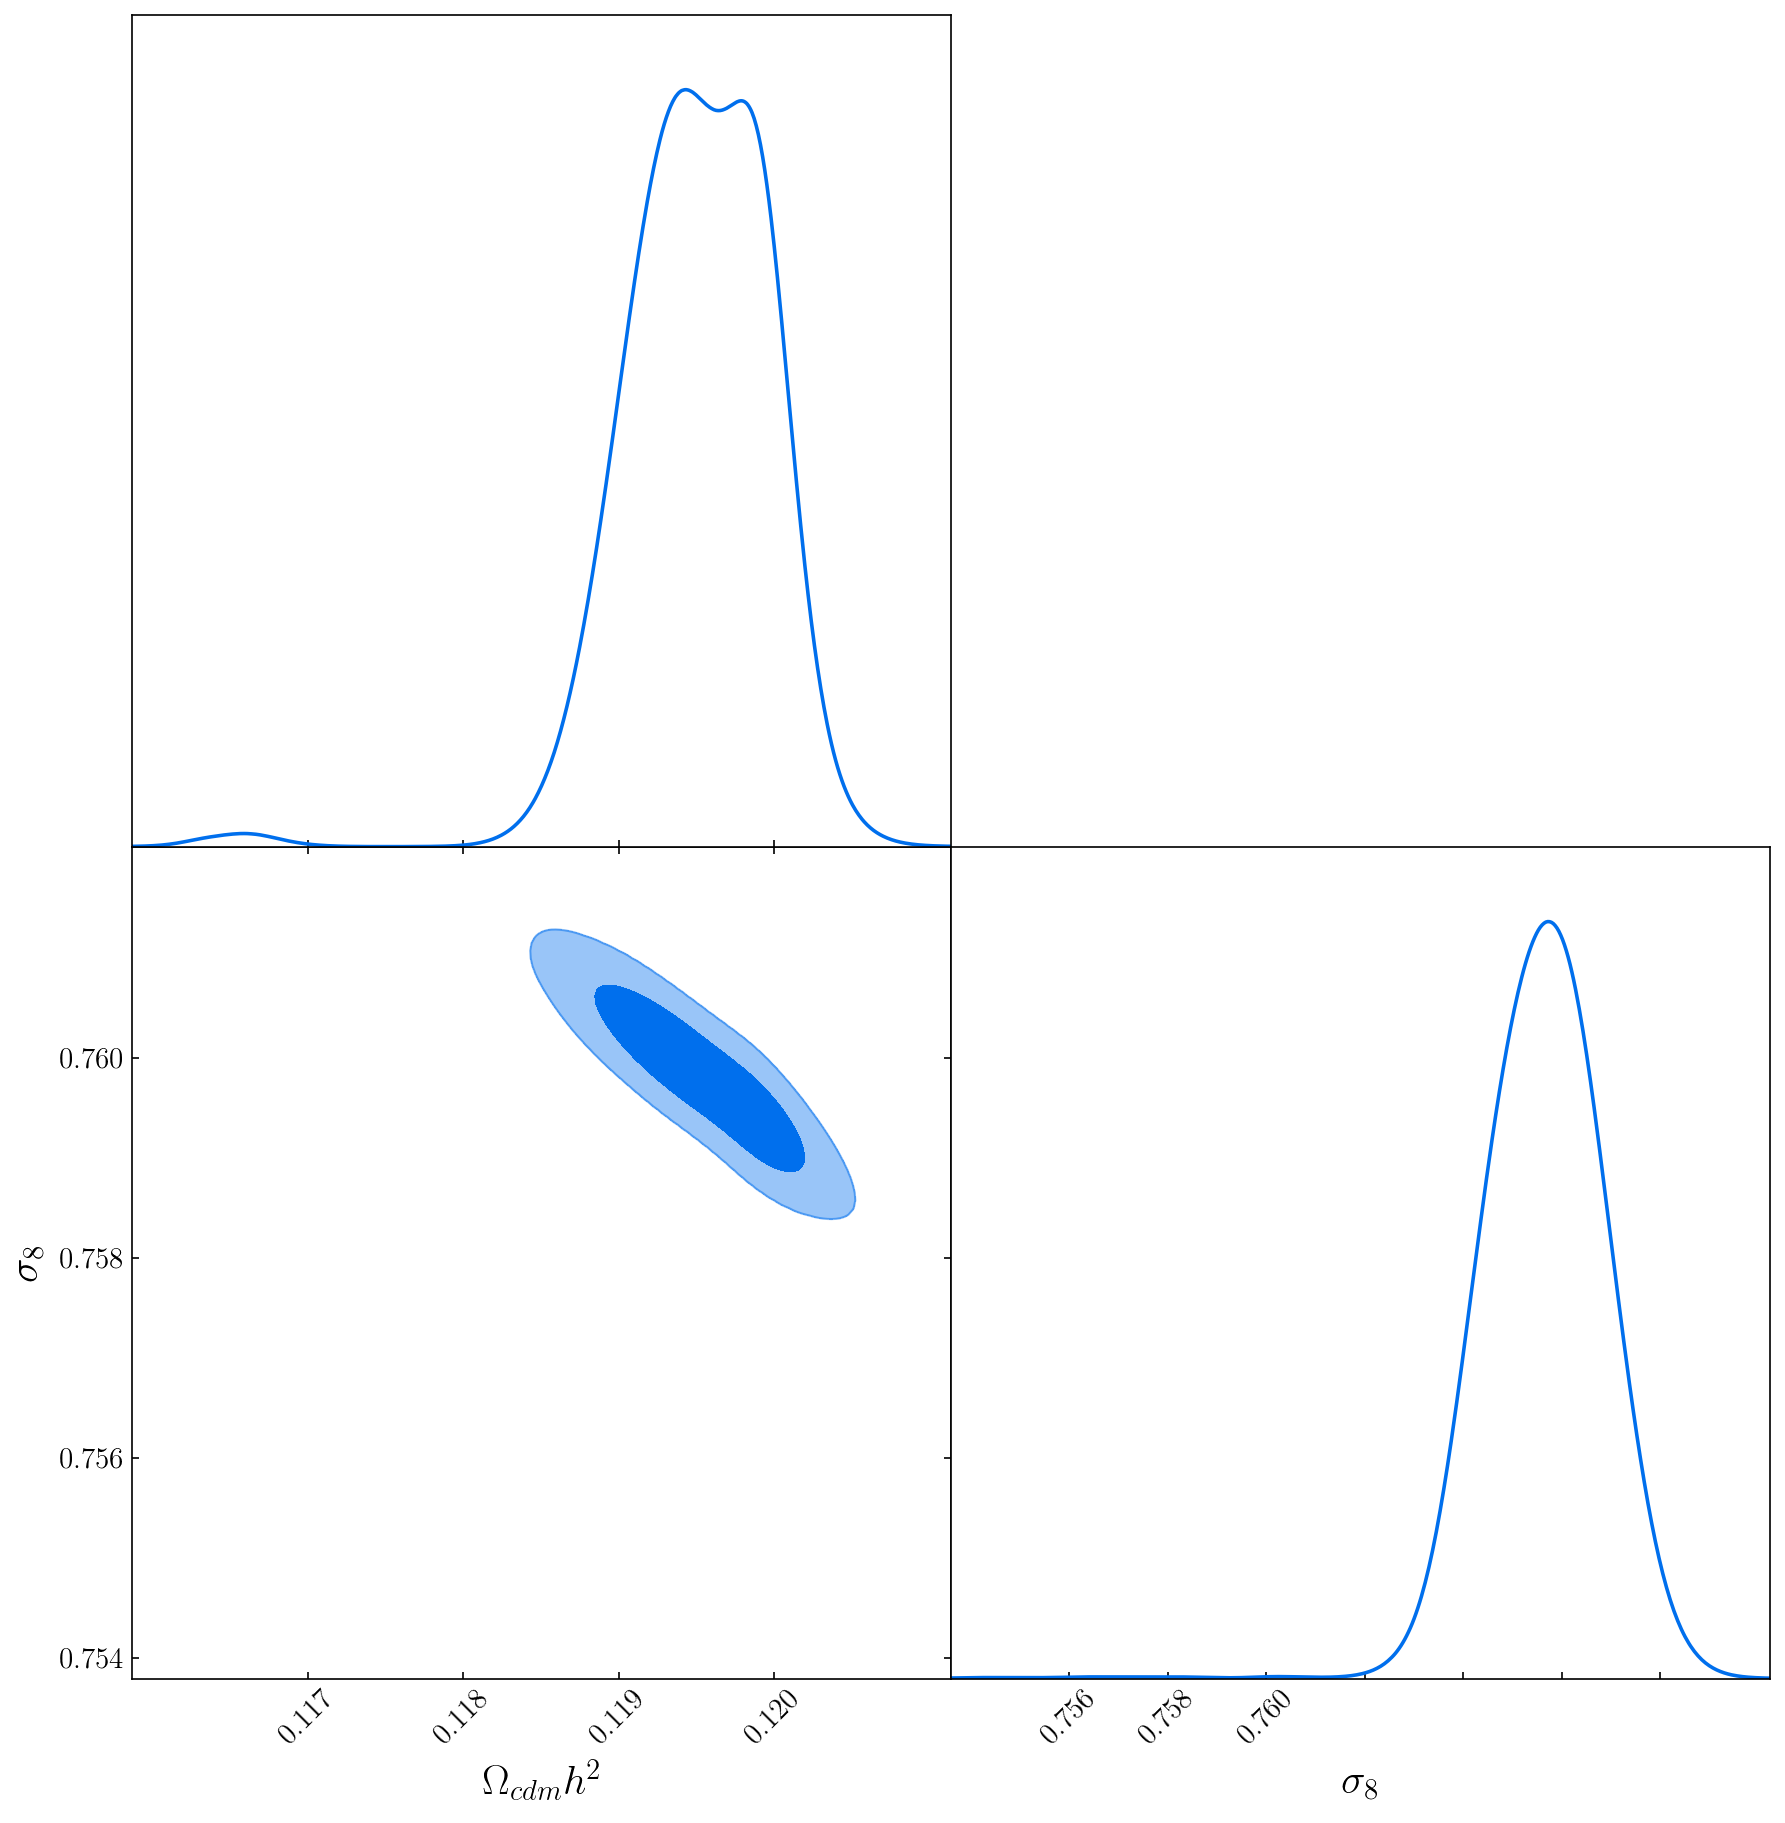

In [29]:
DelfiEnsemble0.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [30]:
np.savetxt(DelfiEnsemble0.results_dir+'posterior_samples.npy', posterior_samples)
np.savetxt(DelfiEnsemble0.results_dir+'posterior_weights.npy', posterior_weights)

In [31]:
DelfiEnsemble0.results_dir

'simulators/mass_function_n_counts/results_seed1_15000sims_3NDEs_2/'